# カーネル行列のrank推移

GP-KANの学習中にカーネル行列のrankがどのように変化したかを時系列で可視化する。

## 1.問題設定

真の関数: フーリエ級数
$$f(t) = \frac{4}{\pi} \sum_{n=1}^{N} \frac{1}{n} \sin(nt), \quad n = 1, 3, 5, \ldots, \quad t \in [0, 1]$$
※$N=15$

データ: 
- 合計1,000件: 学習700件/検証150件/評価150件
- tは$(-1,1)$から一様ランダムサンプリング

モデル:
- 2層のGPKAN: 入力1次元/中間層1次元/出力1次元
    - それぞれのGPを(<1層目のindex>,<2層目のindex>)形式で表すことにすると、GPKANは$(0,0),(1,0)$の2つのGPで構成



## 2.メイン処理
本ノートブックのメイン処理を実行する。実行順は以下の通り：

2-1.データセット作成

2-2.GPKANの学習

2-3.精度評価

2-4.学習中のカーネル行列ランク可視化

### 2-1.データセット作成

In [ ]:
# 初期設定: 必要なライブラリをインポートし、パスを設定
import os
import sys

sys.path.append("../")
import torch.utils.data
from lib import model as gplib
from lib import runner
from torch.utils.data import DataLoader

Train samples: 700
Validation samples: 150
Test samples: 150


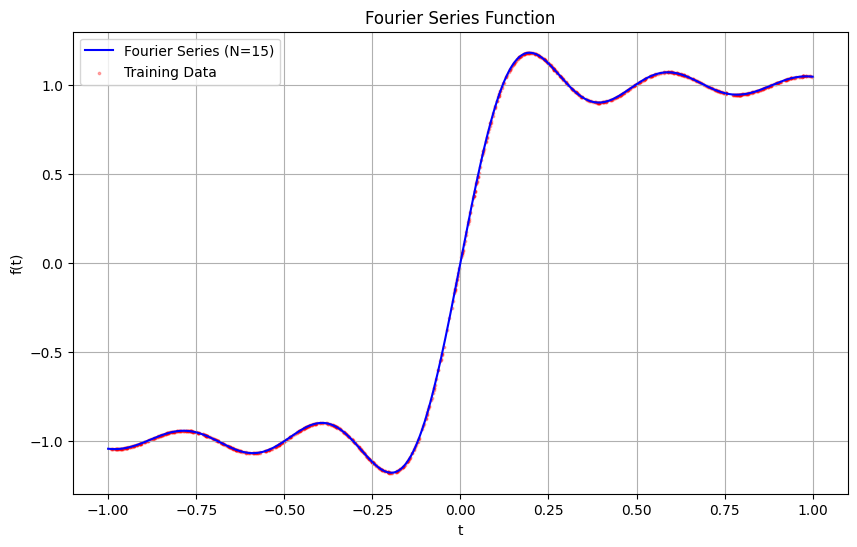

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Generate synthetic data with Fourier series function
np.random.seed(42)  # for reproducibility
num_samples = 1000

# Generate random input points t from [-1, 1]
t = np.random.uniform(-1, 1, num_samples)


# Compute target values: f(t) = (4/π) * Σ(1/n * sin(nt)) for odd n up to N=15
def fourier_series(t, N=15):
    result = np.zeros_like(t)
    for n in range(1, N + 1, 2):  # odd numbers only: 1, 3, 5, 7, 9, 11, 13, 15
        result += (1 / n) * np.sin(n * t)
    return (4 / np.pi) * result


targets = fourier_series(t, N=15)

# Reshape inputs (t is 1D, but we need it as 2D for compatibility)
inputs = t.reshape(-1, 1)

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(inputs)
y_tensor = torch.FloatTensor(targets).reshape(-1, 1)

# Split data into train, validation, and test sets
train_size = int(0.7 * num_samples)
val_size = int(0.15 * num_samples)
test_size = num_samples - train_size - val_size

X_train = X_tensor[:train_size]
y_train = y_tensor[:train_size]

X_val = X_tensor[train_size : train_size + val_size]
y_val = y_tensor[train_size : train_size + val_size]

X_test = X_tensor[train_size + val_size :]
y_test = y_tensor[train_size + val_size :]

# データを昇順にソート（X_testとy_testを対応を保ちながら）
sorted_indices = torch.argsort(X_test.squeeze())
X_test = X_test[sorted_indices]
y_test = y_test[sorted_indices]

# Create datasets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create dataloaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Plot the Fourier series function
t_plot = np.linspace(-1, 1, 1000)
y_plot = fourier_series(t_plot, N=15)
plt.figure(figsize=(10, 6))
plt.plot(t_plot, y_plot, "b-", label="Fourier Series (N=15)")
plt.scatter(t, targets, alpha=0.3, s=3, c="red", label="Training Data")
plt.xlabel("t")
plt.ylabel("f(t)")
plt.title("Fourier Series Function")
plt.legend()
plt.grid(True)
plt.show()

### 2-2.モデル学習

In [ ]:
num_gp_pts = 10  # Number of Gaussian Process points
model = gplib.GP_Model(
    [
        gplib.LayerFused(1, 1, num_gp_pts),
        gplib.LayerFused(1, 1, num_gp_pts),
    ],
    saveload_path="model111.pt",
)
np.random.seed(42)  # for reproducibility

In [ ]:
# カーネル行列のランクを計算
def compute_kernel_rank(model, depth=0):
    layer = model.layers[depth]
    inducing_points = layer.z.detach()  # Shape: [1, 1, X]
    lengthscale = layer.l.detach()  # Shape: [1, 1]
    variance = layer.s.detach()  # Shape: [1, 1]

    # Initialize lists to store results for all GPs
    all_ranks = []
    all_condition_numbers = []
    all_eigenvals = []

    # Iterate over each GP in the 1x1 configuration
    for i in range(inducing_points.shape[0]):  # 1
        for j in range(inducing_points.shape[1]):  # 1
            # Get parameters for this specific GP
            z_ij = inducing_points[i, j, :]  # Shape: [X]
            l_ij = lengthscale[i, j]  # Scalar
            s_ij = variance[i, j]  # Scalar

            # Reshape inducing points for distance computation
            z_ij = z_ij.unsqueeze(1)  # Shape: [X, 1]

            # Compute kernel matrix for this GP
            pairwise_sq_dists = torch.cdist(z_ij, z_ij, p=2) ** 2
            K = s_ij * torch.exp(-pairwise_sq_dists / (2 * l_ij**2))

            # Compute rank and eigenvalues
            rank = torch.linalg.matrix_rank(K).item()
            eigenvals = torch.linalg.eigvals(K).real
            eigenvals = torch.clamp(eigenvals, min=1e-10)  # 負の固有値を1e-10に補完
            condition_number = eigenvals.max() / eigenvals.min()

            all_ranks.append(rank)
            all_condition_numbers.append(condition_number.item())
            all_eigenvals.append(eigenvals)

    return all_ranks, all_condition_numbers, all_eigenvals

In [ ]:
# 精度評価/可視化関数
def plot_result(model):
    # テストデータでの予測
    with torch.no_grad():
        # バッチごとに予測を行う
        test_predictions = []
        test_targets = []
        test_variances = []

        for X_batch, y_batch in test_dataloader:
            pred = model.predict(X_batch).mean
            var = model.predict(X_batch).var
            test_predictions.append(pred)
            test_variances.append(var)
            test_targets.append(y_batch)

        # 結果を結合
        test_predictions = torch.cat(test_predictions, dim=0)
        test_targets = torch.cat(test_targets, dim=0)
        test_variances = torch.cat(test_variances, dim=0)

    # MSE計算
    mse = torch.mean((test_predictions - test_targets) ** 2)
    rmse = torch.sqrt(mse)

    print(f"Test MSE: {mse.item():.6f}")
    print(f"Test RMSE: {rmse.item():.6f}")

    # 可視化用のデータ準備
    t_test = X_test.numpy().flatten()
    y_test_true = y_test.numpy().flatten()
    y_test_pred = test_predictions.numpy().flatten()

    # 真の関数の連続プロット用
    t_continuous = np.linspace(-1, 1, 500)
    y_continuous = fourier_series(t_continuous, N=15)

    # グラフ作成
    plt.figure(figsize=(12, 8))

    # 真の関数
    plt.plot(
        t_continuous,
        y_continuous,
        "b-",
        linewidth=2,
        label="True Function (Fourier Series)",
        alpha=0.8,
    )

    # テストデータの真値
    plt.scatter(
        t_test,
        y_test_true,
        c="red",
        s=30,
        alpha=0.6,
        label="Test Data (True)",
        marker="o",
    )

    # 予測値
    plt.scatter(
        t_test, y_test_pred, c="green", s=30, alpha=0.6, label="Predictions", marker="x"
    )

    # 予測の不確実性を帯で表示
    lower_bound = y_test_pred - 1.96 * np.sqrt(test_variances.numpy().flatten())
    upper_bound = y_test_pred + 1.96 * np.sqrt(test_variances.numpy().flatten())
    plt.fill_between(
        t_test,
        lower_bound,
        upper_bound,
        color="lightgreen",
        alpha=0.3,
        label="95% Prediction Interval",
    )

    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.title(f"GP-KAN Prediction vs True Function\nTest RMSE: {rmse.item():.6f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # 残差プロット
    plt.figure(figsize=(10, 6))
    residuals = y_test_pred - y_test_true
    plt.scatter(t_test, residuals, c="purple", s=30, alpha=0.6)
    plt.axhline(y=0, color="red", linestyle="--", alpha=0.7)
    plt.xlabel("t")
    plt.ylabel("Residuals (Predicted - True)")
    plt.title("Residual Plot")
    plt.grid(True, alpha=0.3)
    plt.show()

    # 残差の統計情報
    print(f"\nResidual Statistics:")
    print(f"Mean: {np.mean(residuals):.6f}")
    print(f"Std: {np.std(residuals):.6f}")
    print(f"Min: {np.min(residuals):.6f}")
    print(f"Max: {np.max(residuals):.6f}")

    print("plot completed")
    return 0

epoch 0  , train negloglik: 279.63725,    val negloglik: 4.53359    accuracy: 122.5010 lr: [0.0001]
epoch 1  , train negloglik: 4.00659,    val negloglik: 3.31772    accuracy: 11.6451 lr: [9e-05]
epoch 2  , train negloglik: 3.43309,    val negloglik: 3.38676    accuracy: 32.3648 lr: [9e-05]
epoch 3  , train negloglik: 3.33627,    val negloglik: 3.35357    accuracy: 27.6090 lr: [9e-05]
epoch 4  , train negloglik: 3.33280,    val negloglik: 3.31421    accuracy: 15.7632 lr: [9e-05]
epoch 5  , train negloglik: 3.31747,    val negloglik: 3.26502    accuracy: 2.5725 lr: [9e-05]
epoch 6  , train negloglik: 3.29562,    val negloglik: 3.26735    accuracy: 7.9795 lr: [9e-05]
epoch 7  , train negloglik: 3.27663,    val negloglik: 3.27604    accuracy: 14.4789 lr: [9e-05]
epoch 8  , train negloglik: 3.26038,    val negloglik: 3.23852    accuracy: 5.5118 lr: [9e-05]
epoch 9  , train negloglik: 3.24585,    val negloglik: 3.23158    accuracy: 7.1952 lr: [9e-05]
epoch 10 , train negloglik: 3.22134,    

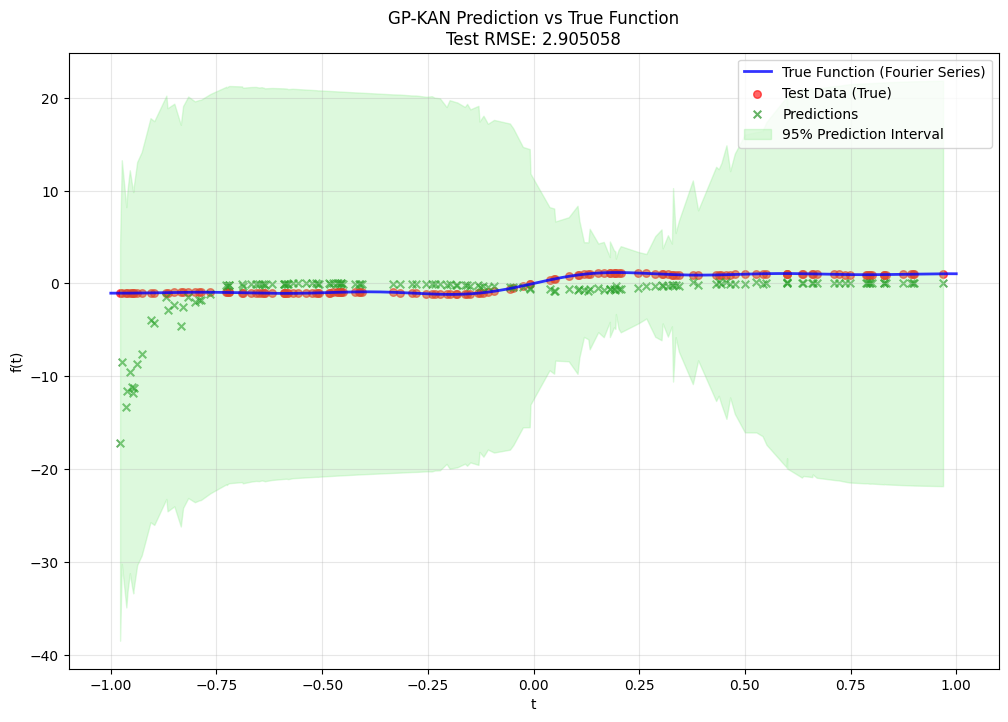

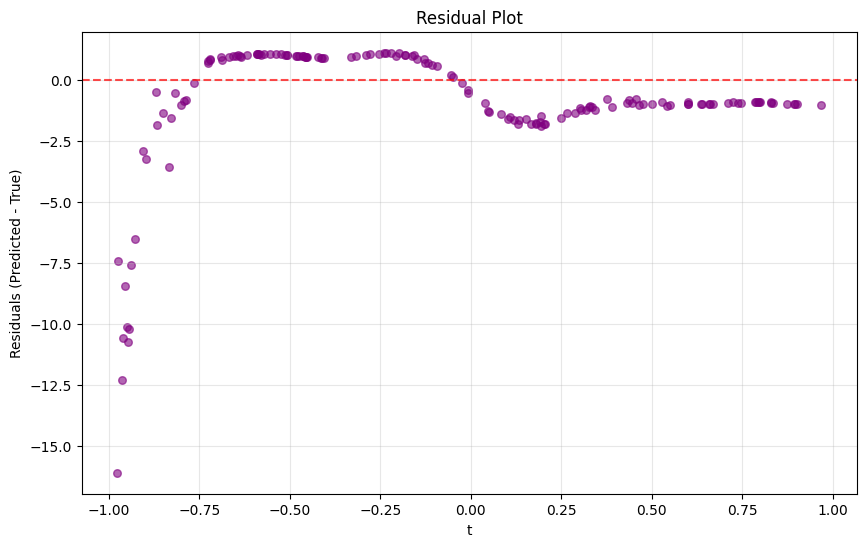


Residual Statistics:
Mean: -0.947457
Std: 2.746213
Min: -16.095631
Max: 1.098800
plot completed
epoch 0  , train negloglik: 3.07021,    val negloglik: 3.02475    accuracy: 3.5622 lr: [0.0001]
epoch 1  , train negloglik: 3.02231,    val negloglik: 3.02122    accuracy: 9.3099 lr: [9e-05]
epoch 2  , train negloglik: 3.01847,    val negloglik: 2.98854    accuracy: 3.7675 lr: [9e-05]
epoch 3  , train negloglik: 3.00363,    val negloglik: 2.97752    accuracy: 4.7736 lr: [9e-05]
epoch 4  , train negloglik: 2.97845,    val negloglik: 2.93062    accuracy: 1.6317 lr: [9e-05]
epoch 5  , train negloglik: 2.95951,    val negloglik: 2.96181    accuracy: 6.4392 lr: [9e-05]
epoch 6  , train negloglik: 2.97114,    val negloglik: 2.95387    accuracy: 3.9131 lr: [9e-05]
epoch 7  , train negloglik: 2.95307,    val negloglik: 2.93286    accuracy: 5.2730 lr: [9e-05]
epoch 8  , train negloglik: 2.95851,    val negloglik: 2.93194    accuracy: 8.1611 lr: [9e-05]
epoch 9  , train negloglik: 2.91126,    val neg

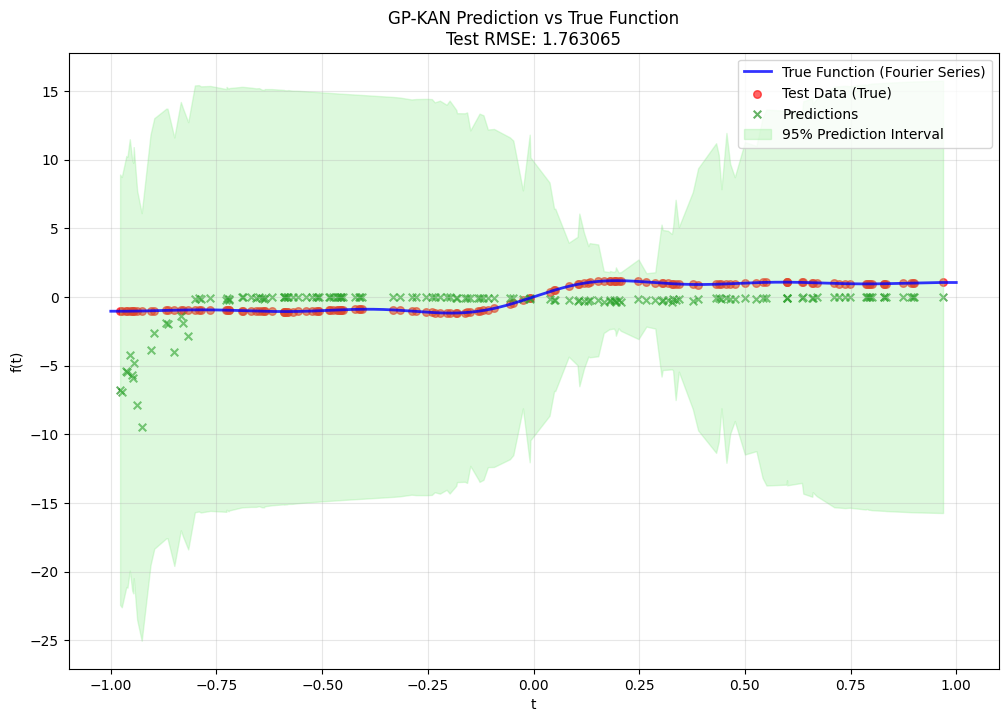

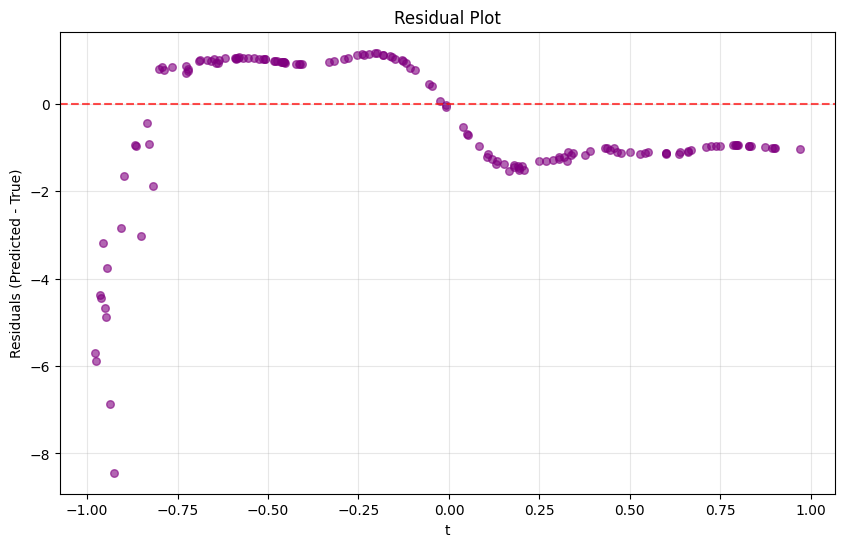


Residual Statistics:
Mean: -0.512873
Std: 1.686819
Min: -8.442019
Max: 1.164787
plot completed
epoch 0  , train negloglik: 2.72550,    val negloglik: 2.70155    accuracy: 0.9633 lr: [0.0001]
epoch 1  , train negloglik: 2.71844,    val negloglik: 2.72087    accuracy: 2.8530 lr: [9e-05]
epoch 2  , train negloglik: 2.69943,    val negloglik: 2.67577    accuracy: 0.8812 lr: [9e-05]
epoch 3  , train negloglik: 2.68146,    val negloglik: 2.66515    accuracy: 0.9623 lr: [9e-05]
epoch 4  , train negloglik: 2.65527,    val negloglik: 2.65493    accuracy: 0.9092 lr: [9e-05]
epoch 5  , train negloglik: 2.65324,    val negloglik: 2.62841    accuracy: 1.2116 lr: [9e-05]
epoch 6  , train negloglik: 2.65286,    val negloglik: 2.63925    accuracy: 1.0684 lr: [9e-05]
epoch 7  , train negloglik: 2.63868,    val negloglik: 2.65726    accuracy: 1.7355 lr: [9e-05]
epoch 8  , train negloglik: 2.63587,    val negloglik: 2.58868    accuracy: 1.1491 lr: [9e-05]
epoch 9  , train negloglik: 2.60899,    val negl

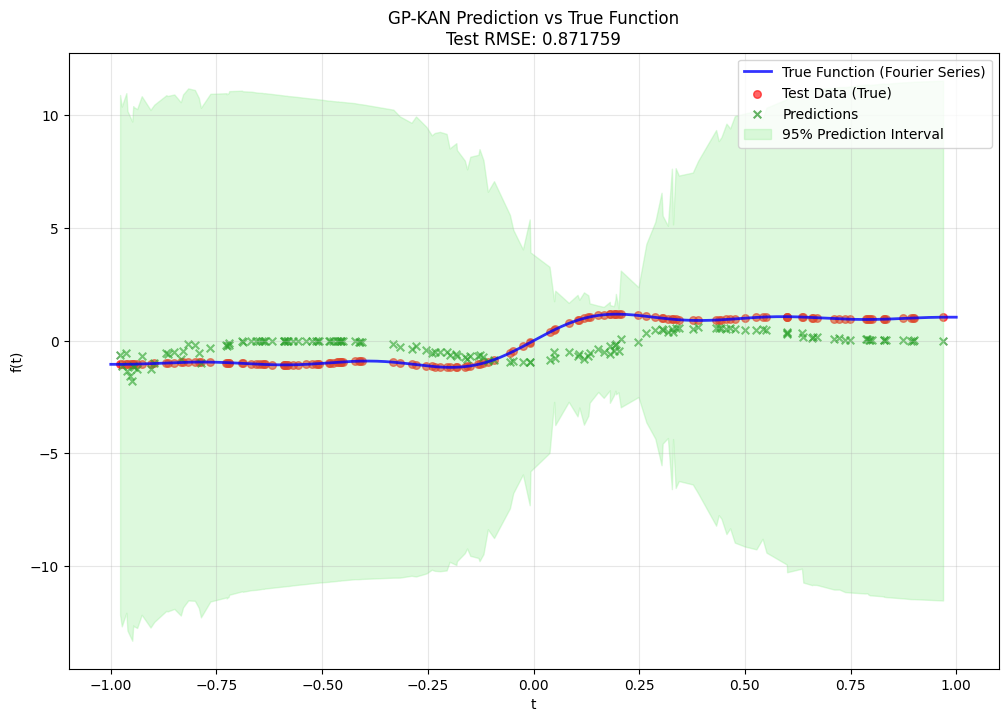

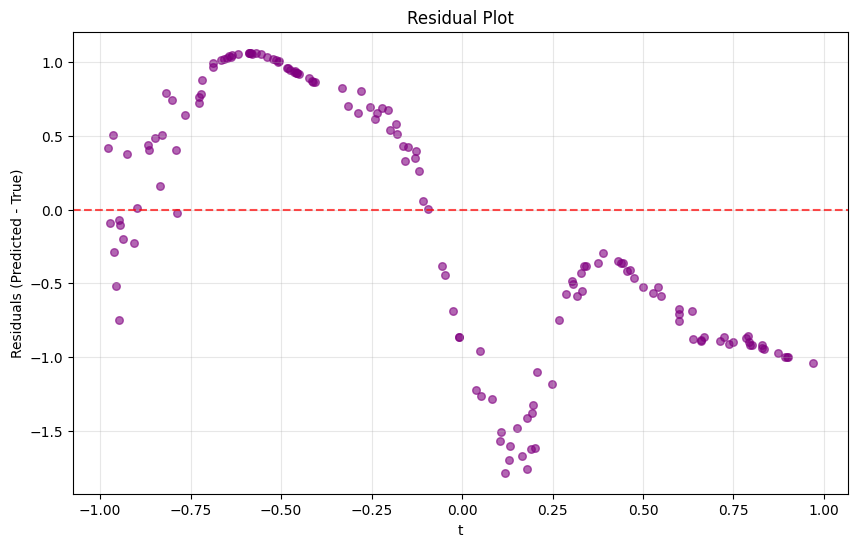


Residual Statistics:
Mean: -0.080764
Std: 0.868010
Min: -1.783605
Max: 1.063741
plot completed
epoch 0  , train negloglik: 2.42910,    val negloglik: 2.42689    accuracy: 0.7673 lr: [0.0001]
epoch 1  , train negloglik: 2.41742,    val negloglik: 2.40721    accuracy: 0.8757 lr: [9e-05]
epoch 2  , train negloglik: 2.40670,    val negloglik: 2.43664    accuracy: 0.8987 lr: [9e-05]
epoch 3  , train negloglik: 2.39880,    val negloglik: 2.36251    accuracy: 0.7530 lr: [9e-05]
epoch 4  , train negloglik: 2.39140,    val negloglik: 2.37398    accuracy: 1.1277 lr: [9e-05]
epoch 5  , train negloglik: 2.39579,    val negloglik: 2.34384    accuracy: 0.8012 lr: [9e-05]
epoch 6  , train negloglik: 2.37501,    val negloglik: 2.35121    accuracy: 0.9223 lr: [9e-05]
epoch 7  , train negloglik: 2.35165,    val negloglik: 2.30375    accuracy: 0.7270 lr: [9e-05]
epoch 8  , train negloglik: 2.33830,    val negloglik: 2.33840    accuracy: 1.3811 lr: [9e-05]
epoch 9  , train negloglik: 2.30228,    val negl

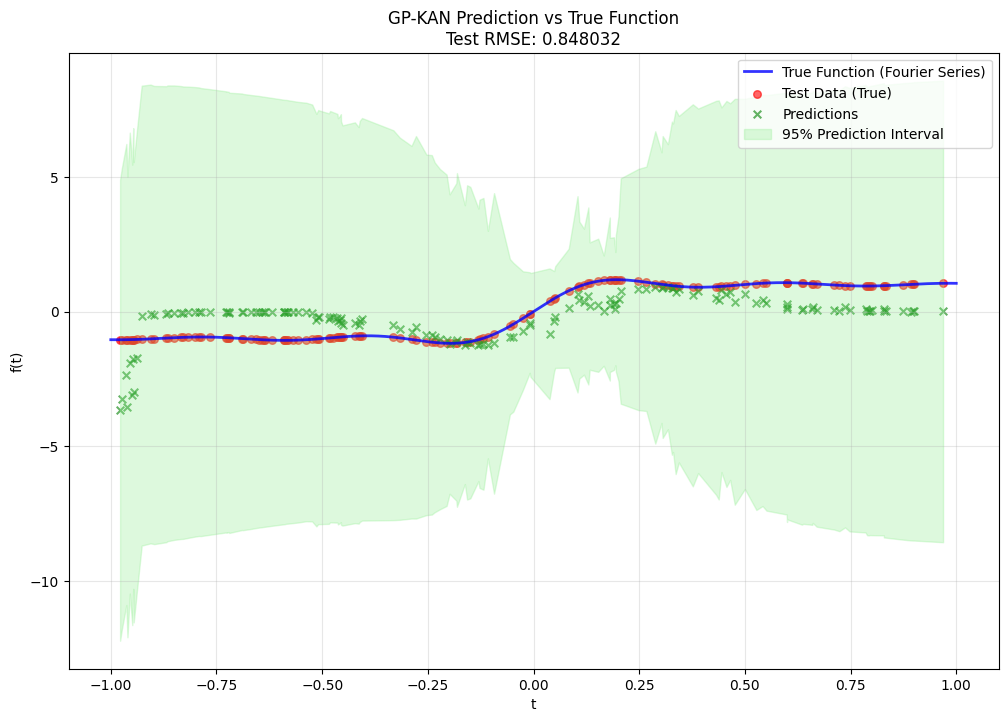

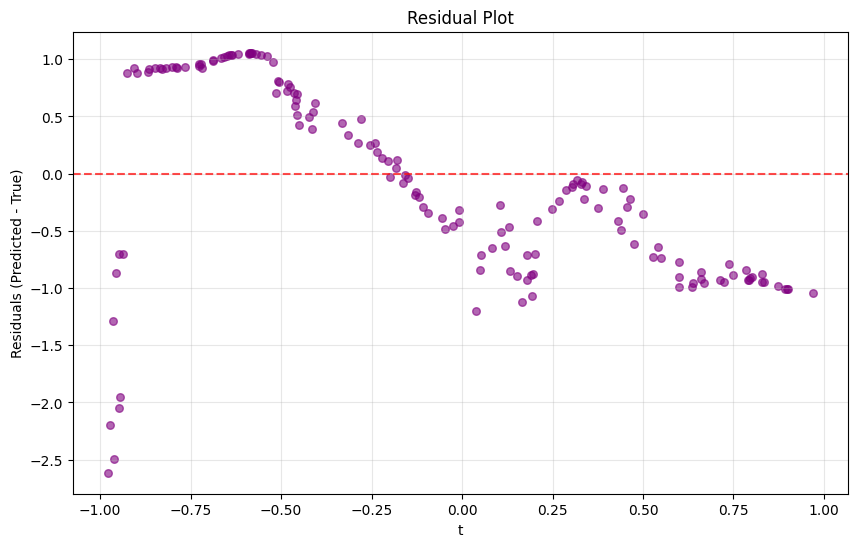


Residual Statistics:
Mean: -0.098009
Std: 0.842349
Min: -2.613989
Max: 1.057321
plot completed
epoch 0  , train negloglik: 2.15158,    val negloglik: 2.12422    accuracy: 0.6937 lr: [0.0001]
epoch 1  , train negloglik: 2.13934,    val negloglik: 2.10133    accuracy: 0.5986 lr: [9e-05]
epoch 2  , train negloglik: 2.12372,    val negloglik: 2.08390    accuracy: 0.5648 lr: [9e-05]
epoch 3  , train negloglik: 2.10939,    val negloglik: 2.07525    accuracy: 0.5796 lr: [9e-05]
epoch 4  , train negloglik: 2.11370,    val negloglik: 2.11779    accuracy: 0.7516 lr: [9e-05]
epoch 5  , train negloglik: 2.09289,    val negloglik: 2.04228    accuracy: 0.6368 lr: [9e-05]
epoch 6  , train negloglik: 2.05808,    val negloglik: 2.02472    accuracy: 0.6143 lr: [9e-05]
epoch 7  , train negloglik: 2.03318,    val negloglik: 2.02125    accuracy: 0.6566 lr: [9e-05]
epoch 8  , train negloglik: 2.02526,    val negloglik: 1.95974    accuracy: 0.5538 lr: [9e-05]
epoch 9  , train negloglik: 2.00412,    val negl

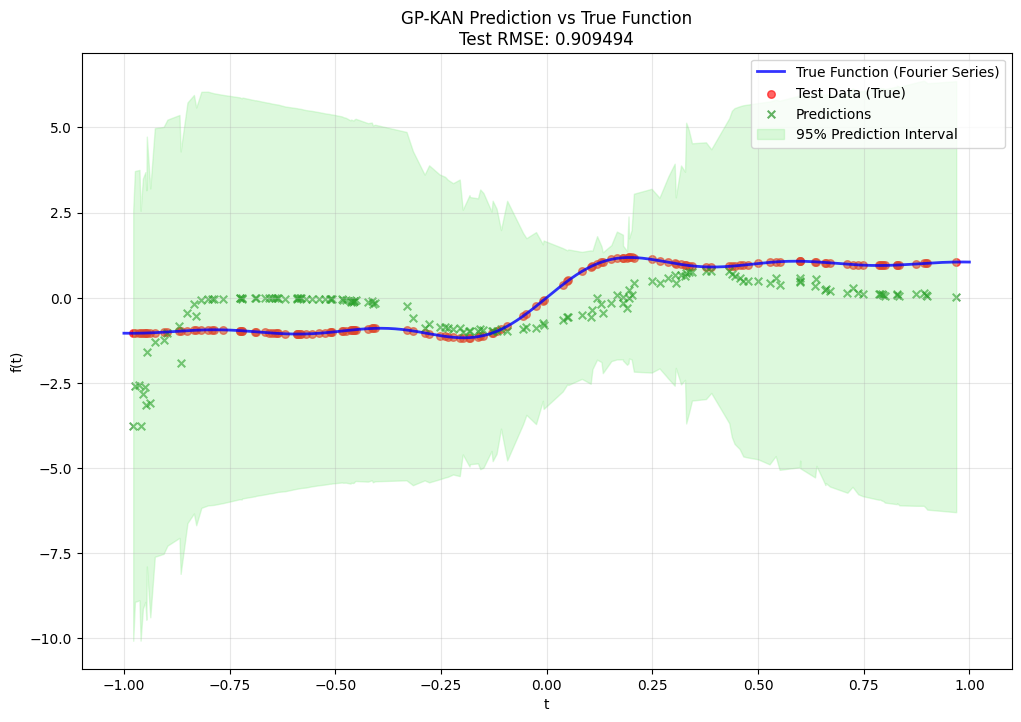

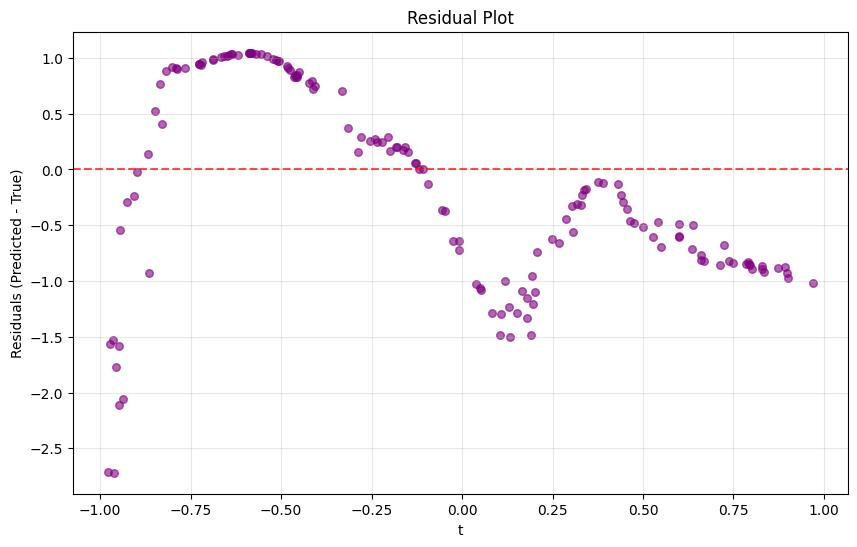


Residual Statistics:
Mean: -0.162098
Std: 0.894932
Min: -2.718866
Max: 1.046015
plot completed
epoch 0  , train negloglik: 1.84957,    val negloglik: 1.78475    accuracy: 0.4973 lr: [0.0001]
epoch 1  , train negloglik: 1.80786,    val negloglik: 1.76309    accuracy: 0.4606 lr: [9e-05]
epoch 2  , train negloglik: 1.81189,    val negloglik: 1.74809    accuracy: 0.4598 lr: [9e-05]
epoch 3  , train negloglik: 1.79364,    val negloglik: 1.83496    accuracy: 0.6340 lr: [9e-05]
epoch 4  , train negloglik: 1.76624,    val negloglik: 1.74356    accuracy: 0.4353 lr: [9e-05]
epoch 5  , train negloglik: 1.75155,    val negloglik: 1.75995    accuracy: 0.4781 lr: [9e-05]
epoch 6  , train negloglik: 1.73245,    val negloglik: 1.75423    accuracy: 0.4810 lr: [9e-05]
epoch 7  , train negloglik: 1.72569,    val negloglik: 1.69658    accuracy: 0.4541 lr: [9e-05]
epoch 8  , train negloglik: 1.70213,    val negloglik: 1.67450    accuracy: 0.4382 lr: [9e-05]
epoch 9  , train negloglik: 1.69323,    val negl

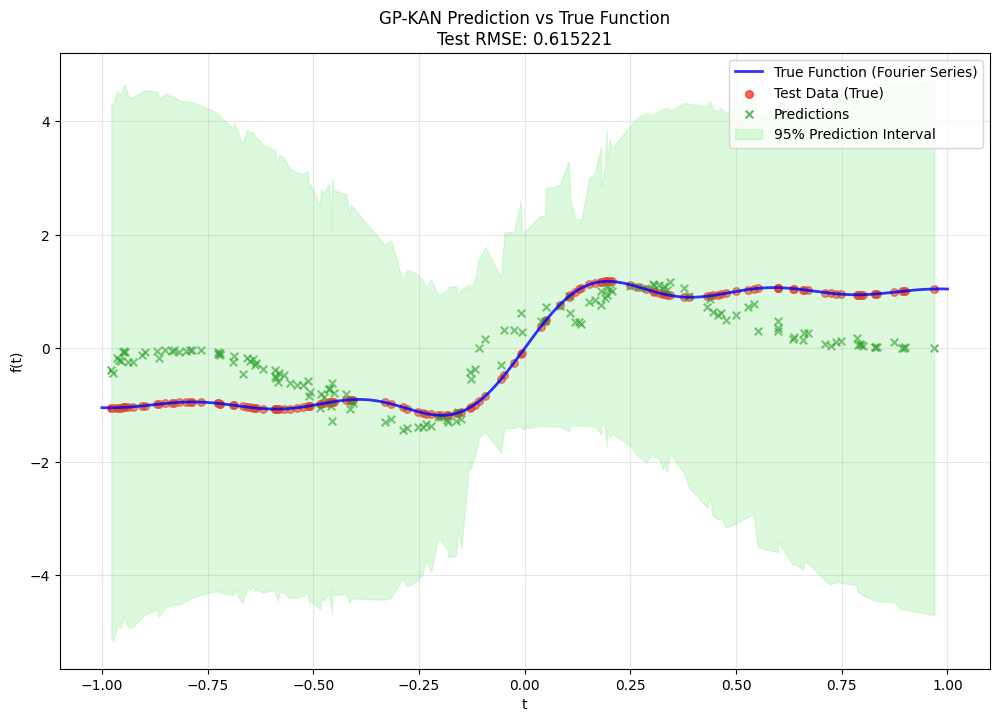

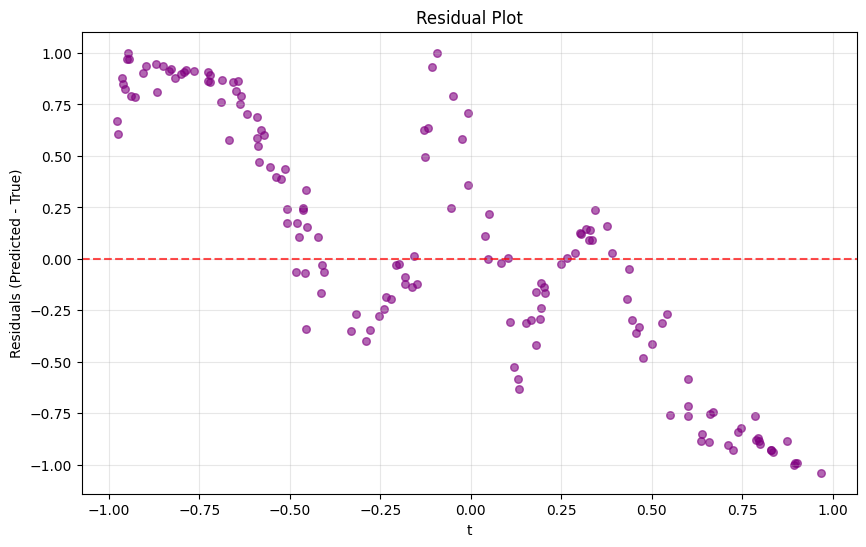


Residual Statistics:
Mean: 0.077985
Std: 0.610259
Min: -1.038797
Max: 1.001311
plot completed
epoch 0  , train negloglik: 1.50295,    val negloglik: 1.49353    accuracy: 0.4140 lr: [0.0001]
epoch 1  , train negloglik: 1.48963,    val negloglik: 1.49781    accuracy: 0.4836 lr: [9e-05]
epoch 2  , train negloglik: 1.47672,    val negloglik: 1.46691    accuracy: 0.3646 lr: [9e-05]
epoch 3  , train negloglik: 1.45480,    val negloglik: 1.45061    accuracy: 0.3734 lr: [9e-05]
epoch 4  , train negloglik: 1.44130,    val negloglik: 1.42367    accuracy: 0.3369 lr: [9e-05]
epoch 5  , train negloglik: 1.43445,    val negloglik: 1.39894    accuracy: 0.3708 lr: [9e-05]
epoch 6  , train negloglik: 1.42791,    val negloglik: 1.44126    accuracy: 0.3630 lr: [9e-05]
epoch 7  , train negloglik: 1.40653,    val negloglik: 1.36426    accuracy: 0.4082 lr: [9e-05]
epoch 8  , train negloglik: 1.39274,    val negloglik: 1.43475    accuracy: 0.4229 lr: [9e-05]
epoch 9  , train negloglik: 1.36650,    val neglo

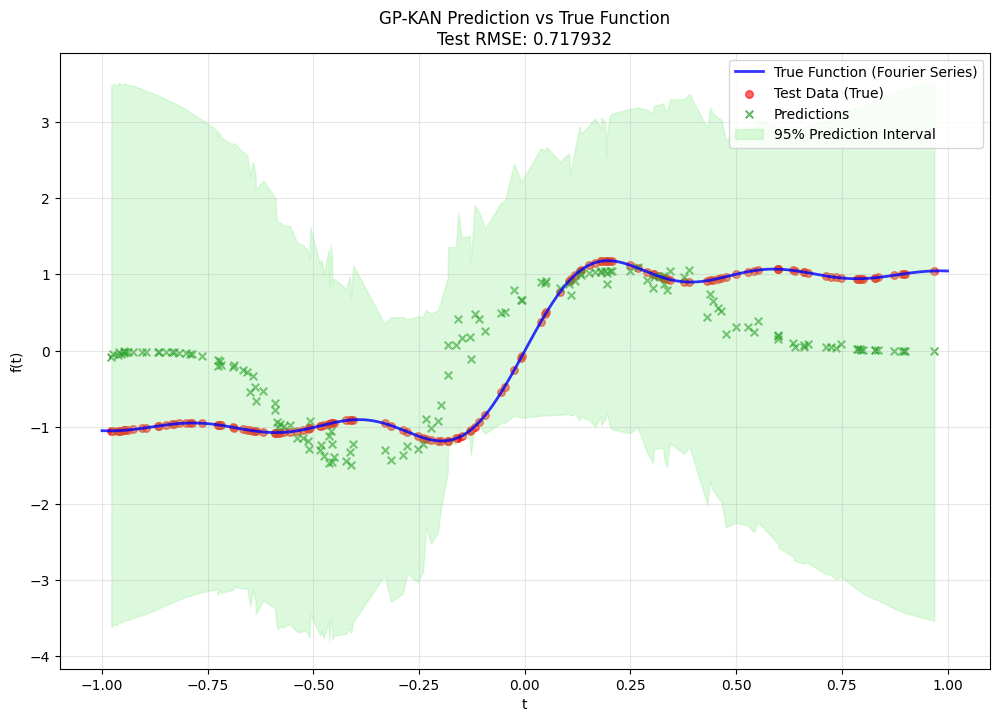

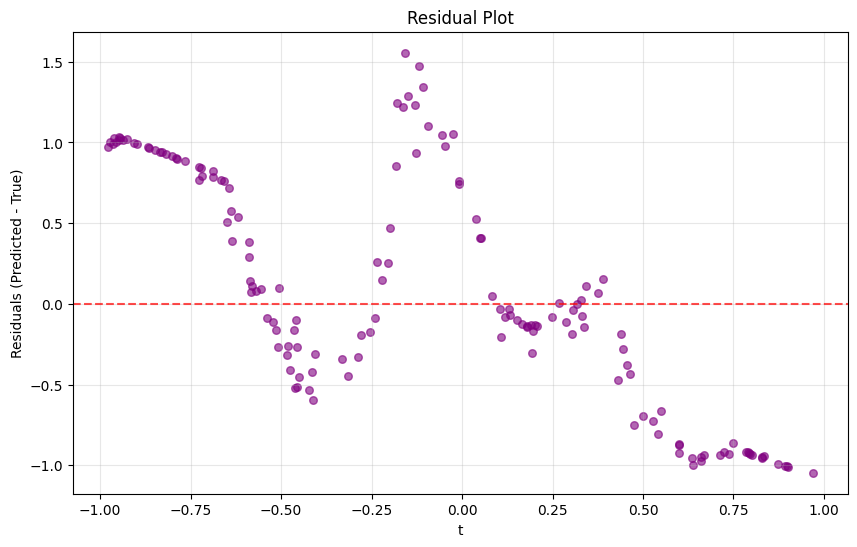


Residual Statistics:
Mean: 0.086424
Std: 0.712711
Min: -1.045616
Max: 1.555461
plot completed
epoch 0  , train negloglik: 1.22945,    val negloglik: 1.17579    accuracy: 0.3523 lr: [0.0001]
epoch 1  , train negloglik: 1.22341,    val negloglik: 1.19168    accuracy: 0.4014 lr: [9e-05]
epoch 2  , train negloglik: 1.19029,    val negloglik: 1.18491    accuracy: 0.3987 lr: [9e-05]
epoch 3  , train negloglik: 1.19955,    val negloglik: 1.20405    accuracy: 0.3785 lr: [9e-05]
epoch 4  , train negloglik: 1.16160,    val negloglik: 1.11259    accuracy: 0.3104 lr: [9e-05]
epoch 5  , train negloglik: 1.14972,    val negloglik: 1.14360    accuracy: 0.3923 lr: [9e-05]
epoch 6  , train negloglik: 1.12871,    val negloglik: 1.10229    accuracy: 0.3542 lr: [9e-05]
epoch 7  , train negloglik: 1.11247,    val negloglik: 1.06616    accuracy: 0.2812 lr: [9e-05]
epoch 8  , train negloglik: 1.09777,    val negloglik: 1.07726    accuracy: 0.3405 lr: [9e-05]
epoch 9  , train negloglik: 1.11685,    val neglo

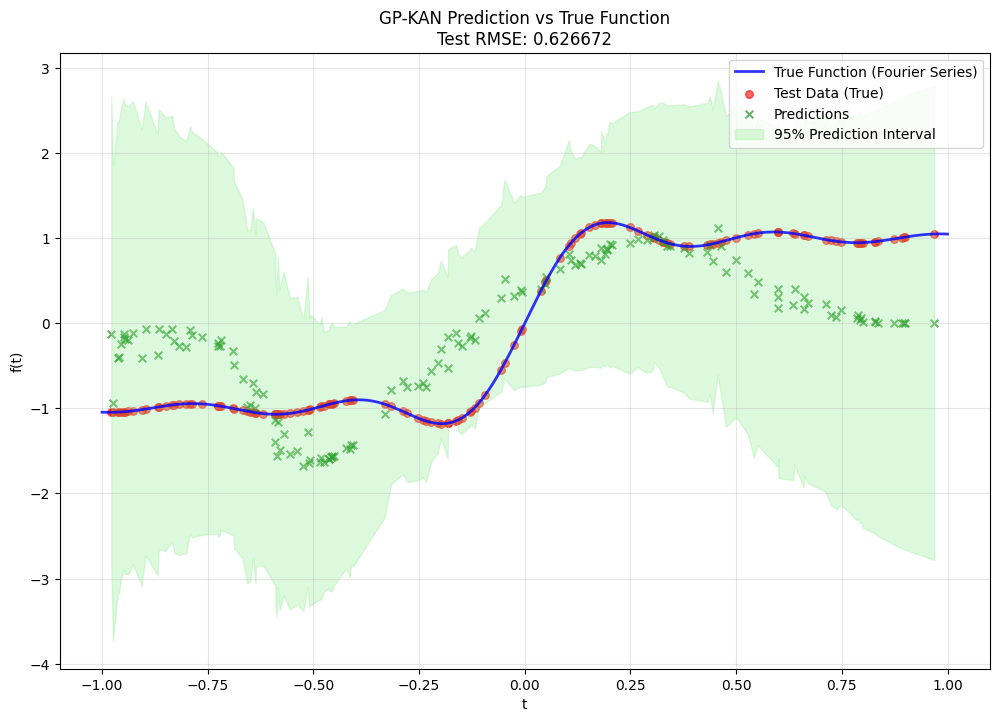

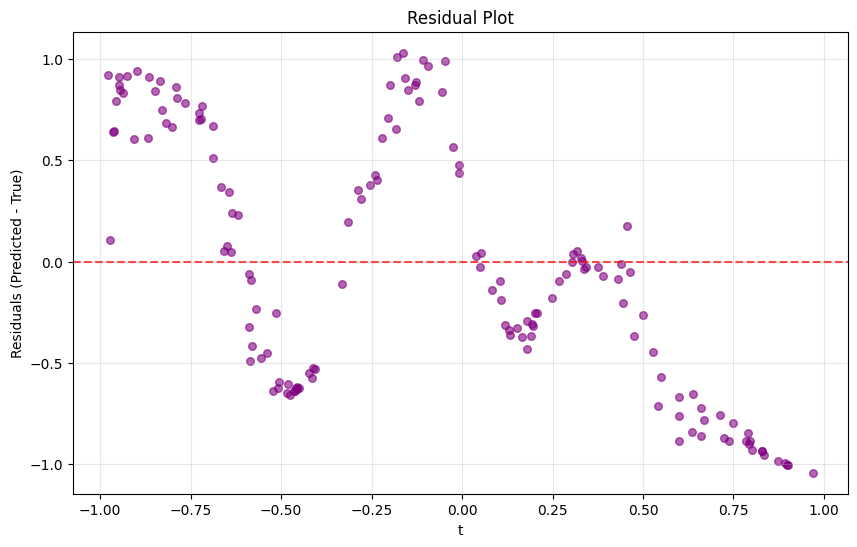


Residual Statistics:
Mean: -0.019387
Std: 0.626372
Min: -1.043586
Max: 1.031681
plot completed
epoch 0  , train negloglik: 1.00329,    val negloglik: 1.00816    accuracy: 0.3559 lr: [0.0001]
epoch 1  , train negloglik: 0.99764,    val negloglik: 1.01642    accuracy: 0.5631 lr: [9e-05]
epoch 2  , train negloglik: 0.98164,    val negloglik: 0.91670    accuracy: 0.2906 lr: [9e-05]
epoch 3  , train negloglik: 0.95379,    val negloglik: 0.98351    accuracy: 0.3656 lr: [9e-05]
epoch 4  , train negloglik: 0.98735,    val negloglik: 1.04767    accuracy: 0.4241 lr: [9e-05]
epoch 5  , train negloglik: 0.95626,    val negloglik: 0.93695    accuracy: 0.3143 lr: [9e-05]
epoch 6  , train negloglik: 0.94929,    val negloglik: 0.95503    accuracy: 0.3268 lr: [9e-05]
epoch 7  , train negloglik: 0.95140,    val negloglik: 0.92210    accuracy: 0.2860 lr: [9e-05]
epoch 8  , train negloglik: 0.93869,    val negloglik: 0.89960    accuracy: 0.2817 lr: [9e-05]
epoch 9  , train negloglik: 0.93422,    val negl

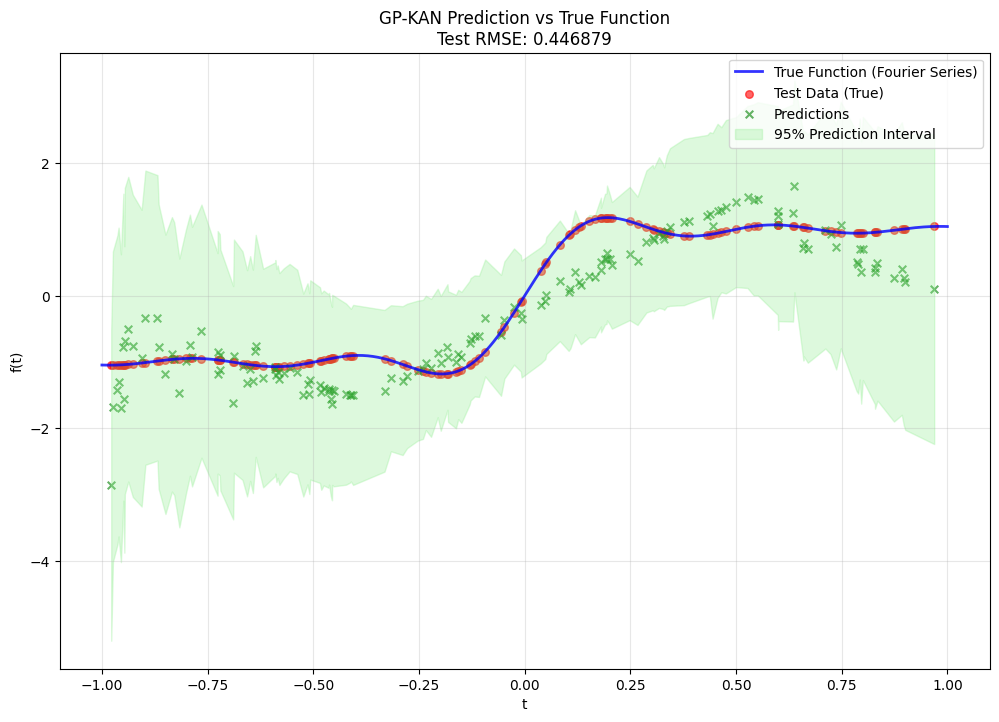

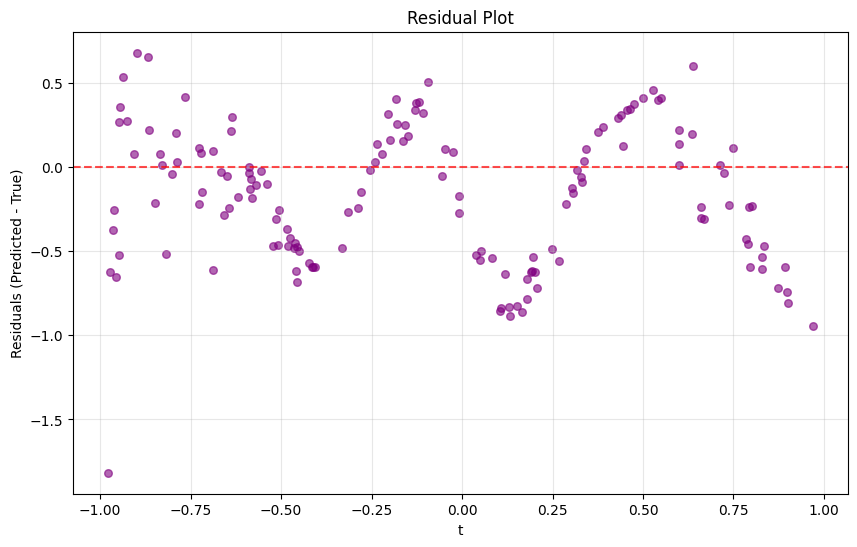


Residual Statistics:
Mean: -0.174285
Std: 0.411492
Min: -1.816588
Max: 0.677764
plot completed
epoch 0  , train negloglik: 0.86918,    val negloglik: 0.88363    accuracy: 0.2196 lr: [0.0001]
epoch 1  , train negloglik: 0.86020,    val negloglik: 0.79468    accuracy: 0.2188 lr: [9e-05]
epoch 2  , train negloglik: 0.84814,    val negloglik: 0.82668    accuracy: 0.2693 lr: [9e-05]
epoch 3  , train negloglik: 0.83181,    val negloglik: 0.92731    accuracy: 0.5489 lr: [9e-05]
epoch 4  , train negloglik: 0.82771,    val negloglik: 0.77244    accuracy: 0.2064 lr: [9e-05]
epoch 5  , train negloglik: 0.87635,    val negloglik: 0.82289    accuracy: 0.2787 lr: [9e-05]
epoch 6  , train negloglik: 0.82949,    val negloglik: 0.84855    accuracy: 0.2776 lr: [9e-05]
epoch 7  , train negloglik: 0.82433,    val negloglik: 0.94405    accuracy: 0.3489 lr: [9e-05]
epoch 8  , train negloglik: 0.82883,    val negloglik: 0.78339    accuracy: 0.2120 lr: [9e-05]
epoch 9  , train negloglik: 0.82355,    val negl

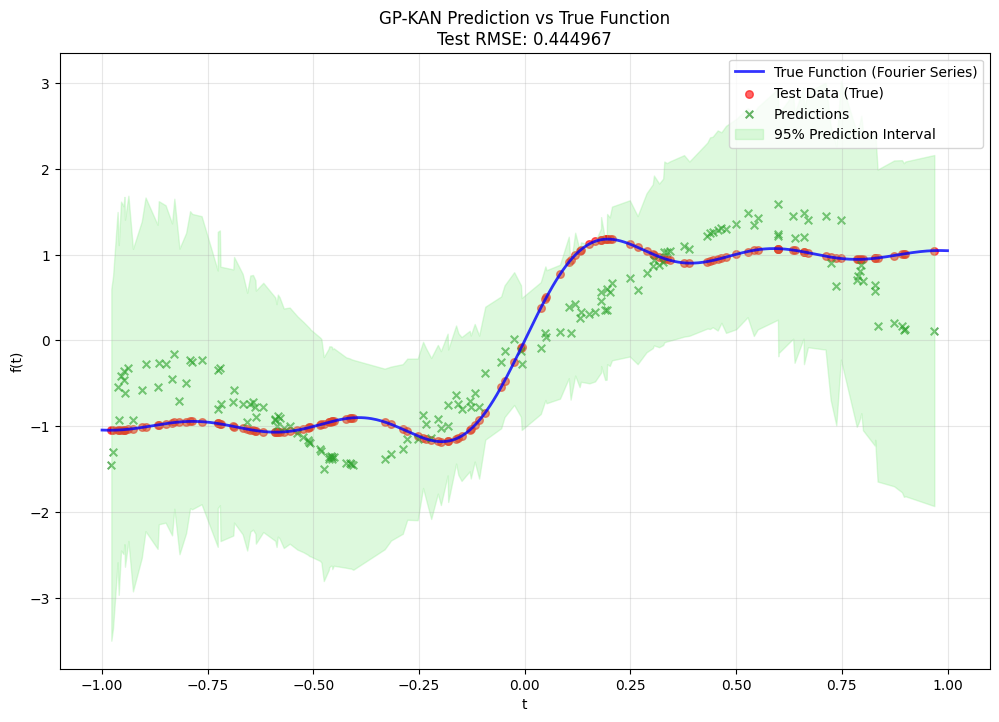

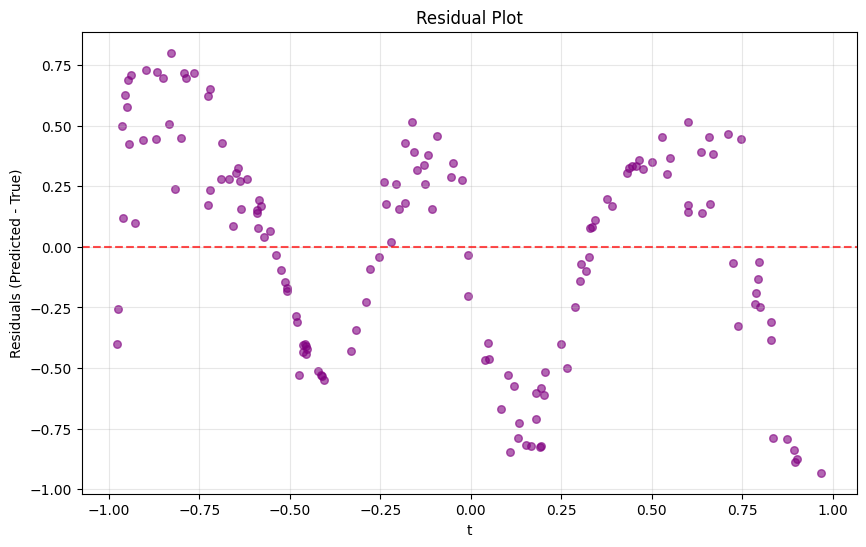


Residual Statistics:
Mean: -0.002175
Std: 0.444961
Min: -0.931989
Max: 0.801213
plot completed
epoch 0  , train negloglik: 0.79825,    val negloglik: 0.73459    accuracy: 0.2332 lr: [0.0001]
epoch 1  , train negloglik: 0.77202,    val negloglik: 0.79600    accuracy: 0.2507 lr: [9e-05]
epoch 2  , train negloglik: 0.80774,    val negloglik: 0.76083    accuracy: 0.2263 lr: [9e-05]
epoch 3  , train negloglik: 0.80366,    val negloglik: 0.84577    accuracy: 0.3404 lr: [9e-05]
epoch 4  , train negloglik: 0.75888,    val negloglik: 0.73225    accuracy: 0.2574 lr: [9e-05]
epoch 5  , train negloglik: 0.75745,    val negloglik: 0.77382    accuracy: 0.2586 lr: [9e-05]
epoch 6  , train negloglik: 0.74801,    val negloglik: 0.76855    accuracy: 0.2207 lr: [9e-05]
epoch 7  , train negloglik: 0.76247,    val negloglik: 0.92196    accuracy: 0.3761 lr: [9e-05]
epoch 8  , train negloglik: 0.76958,    val negloglik: 0.72691    accuracy: 0.2531 lr: [9e-05]
epoch 9  , train negloglik: 0.75861,    val negl

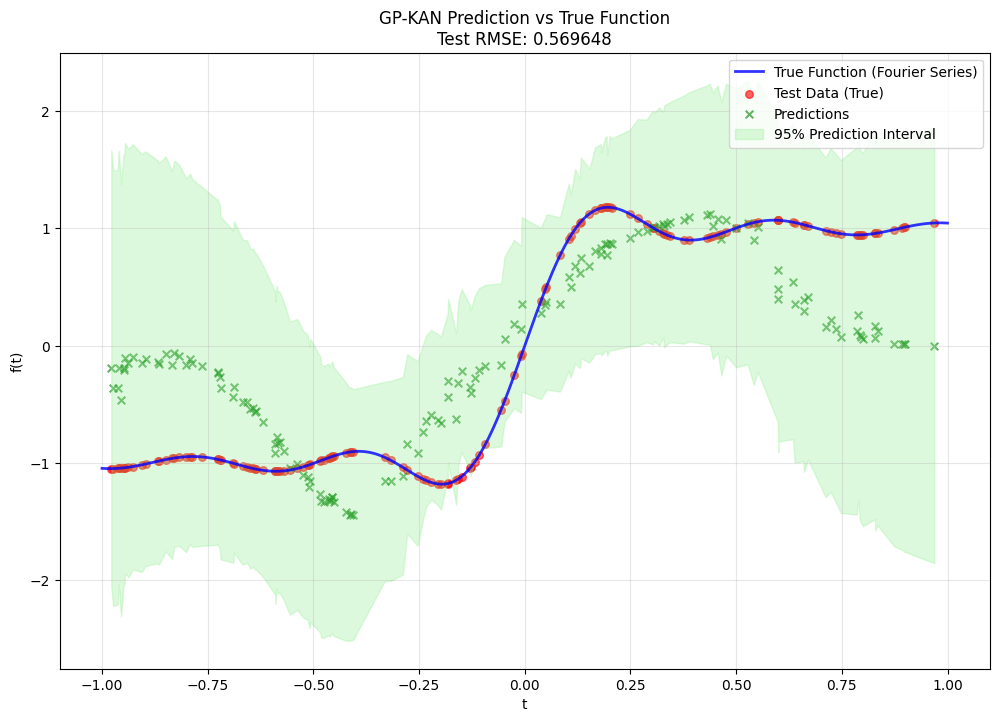

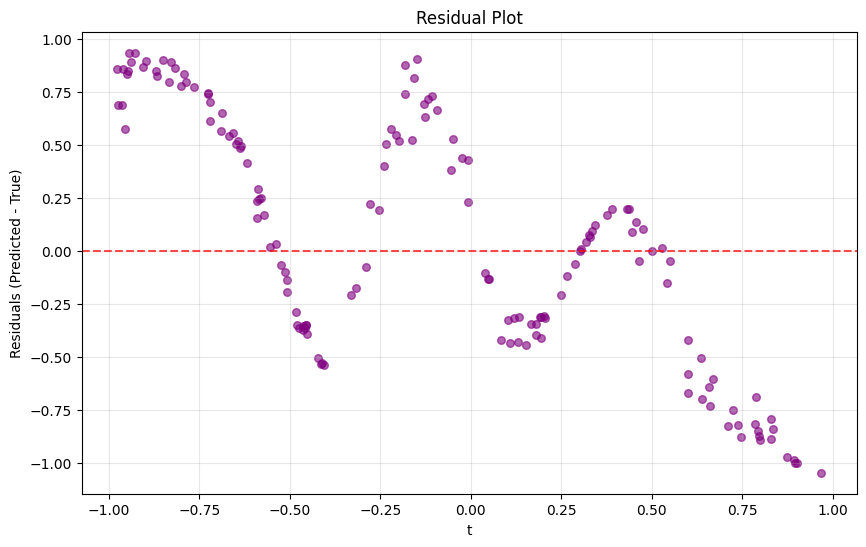


Residual Statistics:
Mean: 0.056936
Std: 0.566796
Min: -1.045599
Max: 0.935277
plot completed
epoch 0  , train negloglik: 0.78272,    val negloglik: 0.69497    accuracy: 0.2155 lr: [0.0001]
epoch 1  , train negloglik: 0.72416,    val negloglik: 0.73548    accuracy: 0.2531 lr: [9e-05]
epoch 2  , train negloglik: 0.75423,    val negloglik: 0.77840    accuracy: 0.3030 lr: [9e-05]
epoch 3  , train negloglik: 0.74013,    val negloglik: 0.67473    accuracy: 0.2100 lr: [9e-05]
epoch 4  , train negloglik: 0.72482,    val negloglik: 0.78376    accuracy: 0.3040 lr: [9e-05]
epoch 5  , train negloglik: 0.73311,    val negloglik: 0.81907    accuracy: 0.2552 lr: [9e-05]
epoch 6  , train negloglik: 0.74510,    val negloglik: 0.71095    accuracy: 0.2393 lr: [9e-05]
epoch 7  , train negloglik: 0.77039,    val negloglik: 1.65814    accuracy: 1.1532 lr: [9e-05]
epoch 8  , train negloglik: 0.74791,    val negloglik: 0.67058    accuracy: 0.2325 lr: [9e-05]
epoch 9  , train negloglik: 0.85528,    val neglo

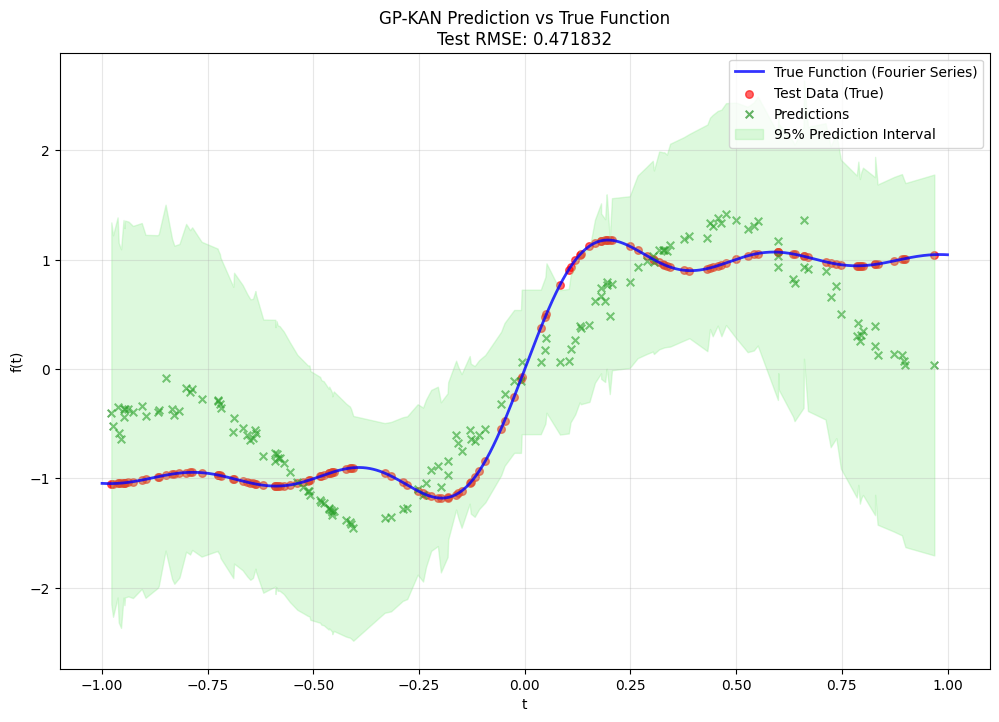

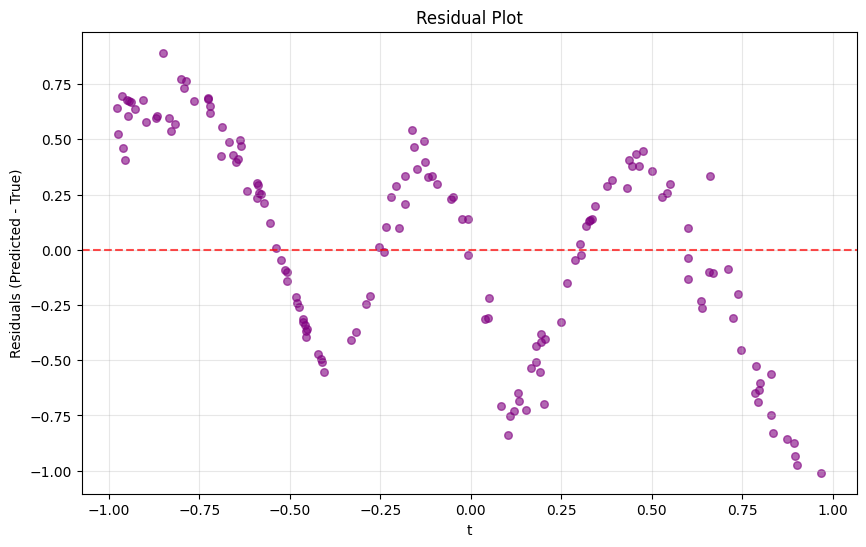


Residual Statistics:
Mean: 0.027098
Std: 0.471053
Min: -1.009270
Max: 0.892043
plot completed
epoch 0  , train negloglik: 0.74376,    val negloglik: 0.97689    accuracy: 0.4101 lr: [0.0001]
epoch 1  , train negloglik: 0.75585,    val negloglik: 0.74707    accuracy: 0.2240 lr: [9e-05]
epoch 2  , train negloglik: 0.72736,    val negloglik: 0.71142    accuracy: 0.2308 lr: [9e-05]
epoch 3  , train negloglik: 0.74241,    val negloglik: 0.72866    accuracy: 0.2403 lr: [9e-05]
epoch 4  , train negloglik: 0.73307,    val negloglik: 0.69062    accuracy: 0.2553 lr: [9e-05]
epoch 5  , train negloglik: 0.72680,    val negloglik: 0.74244    accuracy: 0.2881 lr: [9e-05]
epoch 6  , train negloglik: 0.71023,    val negloglik: 0.73931    accuracy: 0.2831 lr: [9e-05]
epoch 7  , train negloglik: 0.71096,    val negloglik: 0.77225    accuracy: 0.3113 lr: [9e-05]
epoch 8  , train negloglik: 0.70275,    val negloglik: 0.75227    accuracy: 0.3084 lr: [9e-05]
epoch 9  , train negloglik: 0.72230,    val neglo

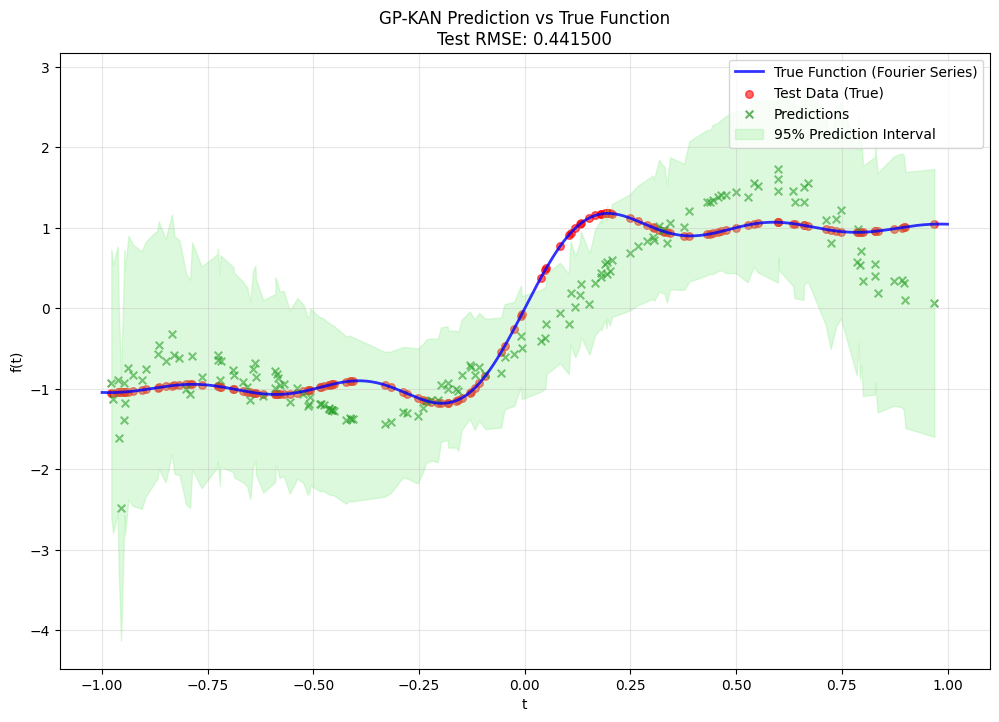

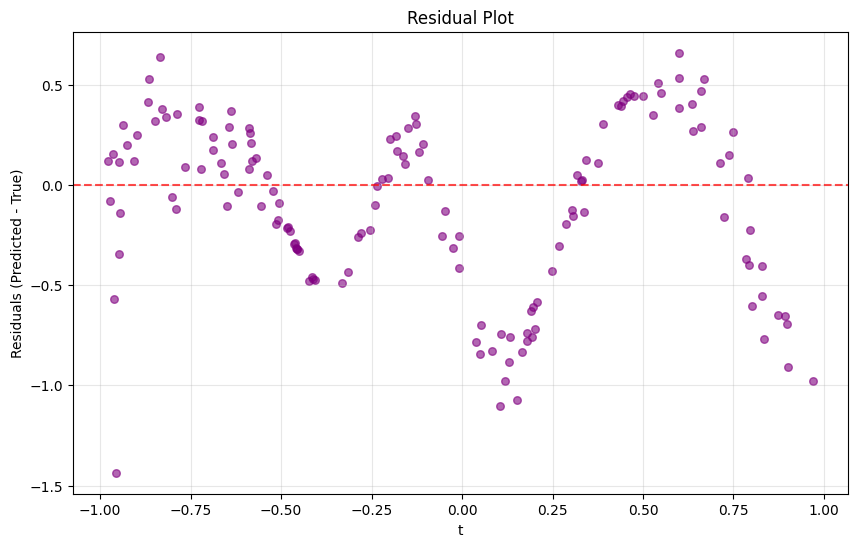


Residual Statistics:
Mean: -0.098023
Std: 0.430481
Min: -1.436110
Max: 0.660285
plot completed
epoch 0  , train negloglik: 0.70096,    val negloglik: 0.70058    accuracy: 0.2368 lr: [0.0001]
epoch 1  , train negloglik: 0.70348,    val negloglik: 0.75735    accuracy: 0.3274 lr: [9e-05]
epoch 2  , train negloglik: 0.72442,    val negloglik: 0.71139    accuracy: 0.2259 lr: [9e-05]
epoch 3  , train negloglik: 0.69849,    val negloglik: 0.67394    accuracy: 0.2211 lr: [9e-05]
epoch 4  , train negloglik: 0.69468,    val negloglik: 0.77398    accuracy: 0.2981 lr: [9e-05]
epoch 5  , train negloglik: 0.67748,    val negloglik: 0.72210    accuracy: 0.2492 lr: [9e-05]
epoch 6  , train negloglik: 0.72310,    val negloglik: 0.72511    accuracy: 0.2971 lr: [9e-05]
epoch 7  , train negloglik: 0.71675,    val negloglik: 0.80462    accuracy: 0.3302 lr: [9e-05]
epoch 8  , train negloglik: 0.70228,    val negloglik: 0.75178    accuracy: 0.3048 lr: [9e-05]
epoch 9  , train negloglik: 0.68612,    val negl

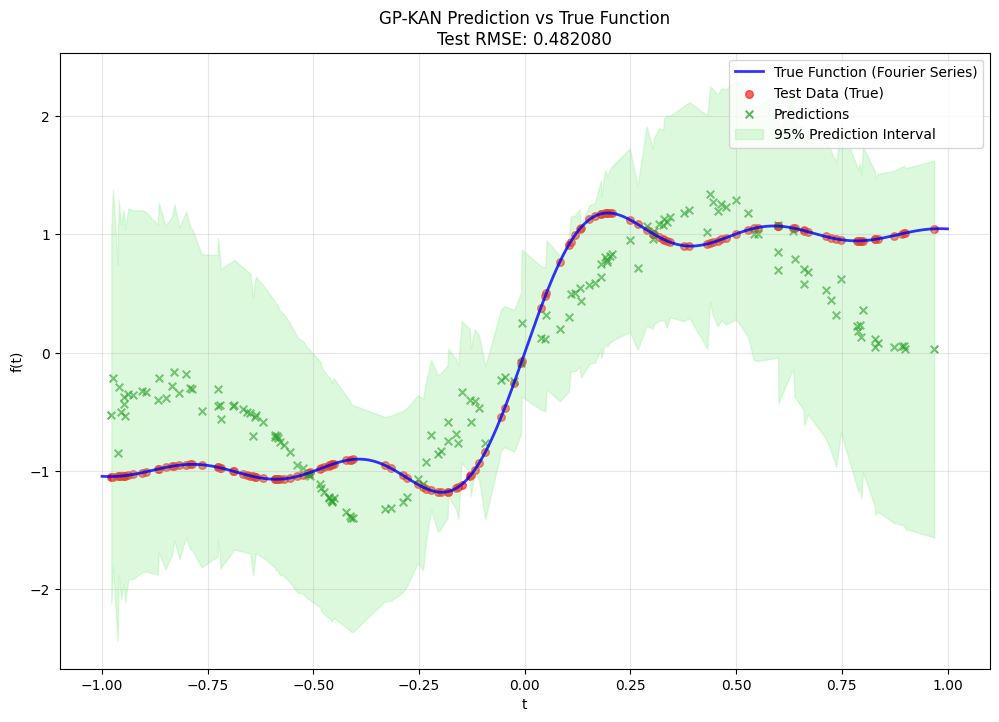

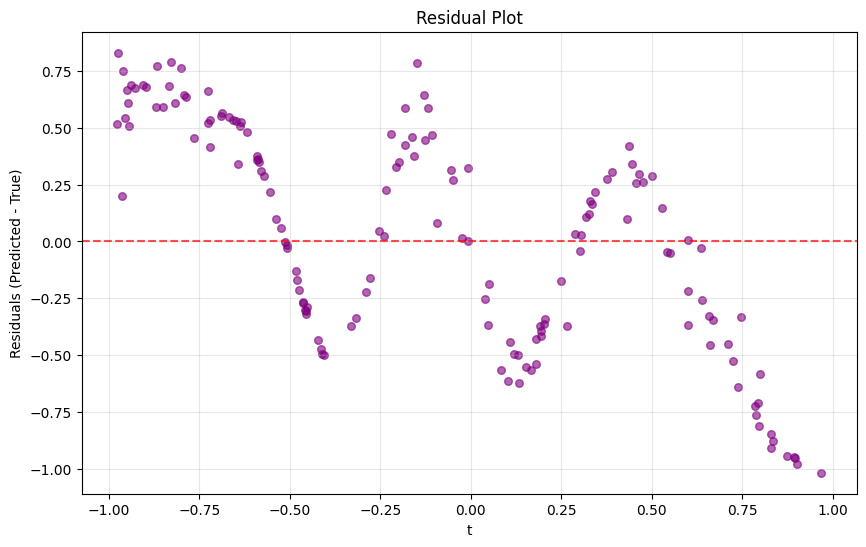


Residual Statistics:
Mean: 0.031524
Std: 0.481048
Min: -1.015726
Max: 0.828726
plot completed
epoch 0  , train negloglik: 0.69146,    val negloglik: 0.69065    accuracy: 0.2157 lr: [0.0001]
epoch 1  , train negloglik: 0.67691,    val negloglik: 0.67377    accuracy: 0.2275 lr: [9e-05]
epoch 2  , train negloglik: 0.66086,    val negloglik: 0.62792    accuracy: 0.2632 lr: [9e-05]
epoch 3  , train negloglik: 0.67894,    val negloglik: 0.98330    accuracy: 0.3944 lr: [9e-05]
epoch 4  , train negloglik: 0.68881,    val negloglik: 0.67892    accuracy: 0.2387 lr: [9e-05]
epoch 5  , train negloglik: 0.68653,    val negloglik: 0.64723    accuracy: 0.2522 lr: [9e-05]
epoch 6  , train negloglik: 0.66250,    val negloglik: 0.69021    accuracy: 0.2842 lr: [9e-05]
epoch 7  , train negloglik: 0.65232,    val negloglik: 0.70063    accuracy: 0.2870 lr: [9e-05]
epoch 8  , train negloglik: 0.66354,    val negloglik: 0.65621    accuracy: 0.2557 lr: [9e-05]
epoch 9  , train negloglik: 0.68991,    val neglo

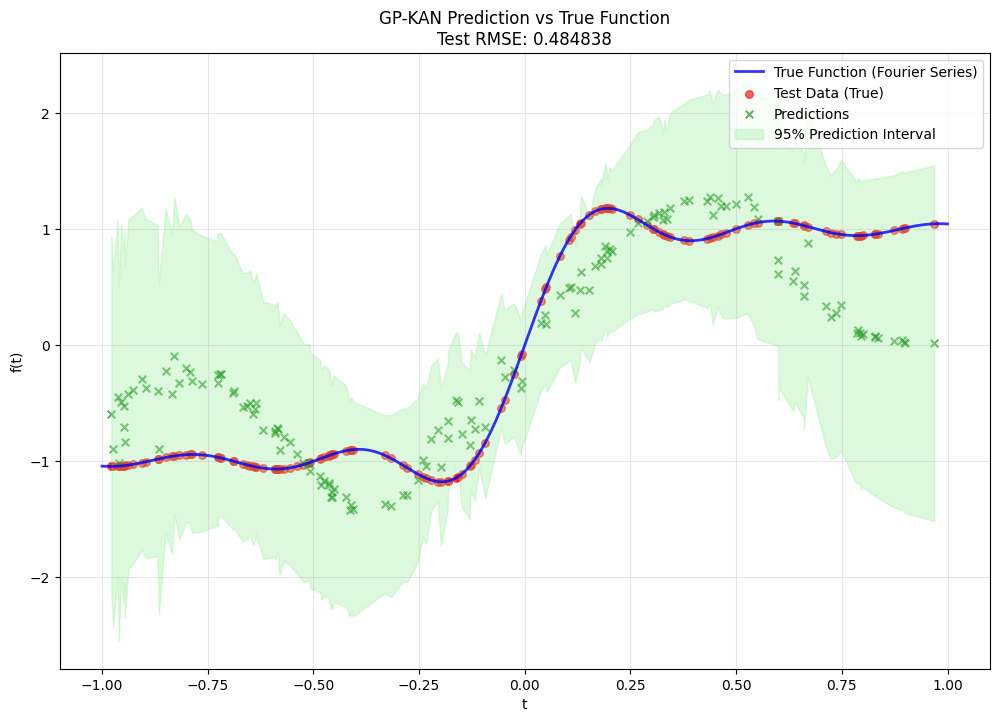

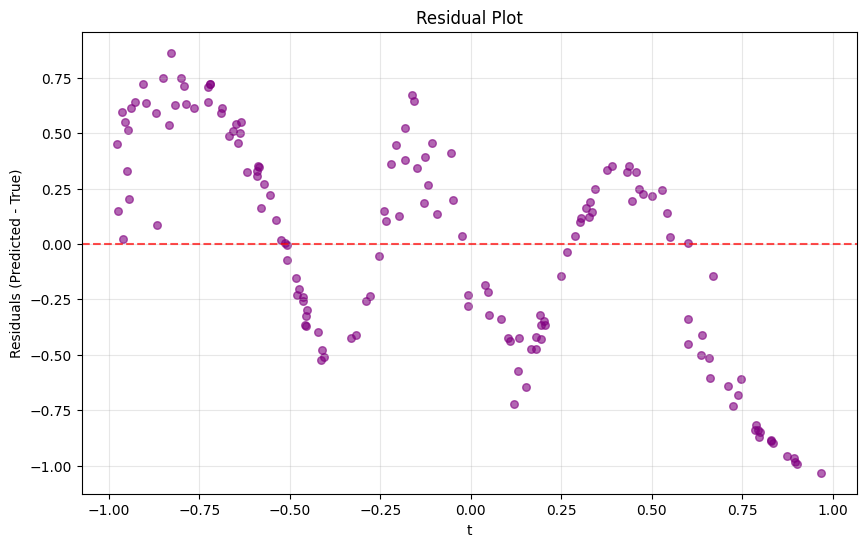


Residual Statistics:
Mean: -0.003018
Std: 0.484829
Min: -1.031873
Max: 0.862455
plot completed
epoch 0  , train negloglik: 0.63074,    val negloglik: 0.66612    accuracy: 0.2558 lr: [0.0001]
epoch 1  , train negloglik: 0.64471,    val negloglik: 0.66771    accuracy: 0.2813 lr: [9e-05]
epoch 2  , train negloglik: 0.66318,    val negloglik: 0.64913    accuracy: 0.2536 lr: [9e-05]
epoch 3  , train negloglik: 0.65118,    val negloglik: 0.63346    accuracy: 0.2321 lr: [9e-05]
epoch 4  , train negloglik: 0.64278,    val negloglik: 0.63427    accuracy: 0.2611 lr: [9e-05]
epoch 5  , train negloglik: 0.66608,    val negloglik: 0.60983    accuracy: 0.2265 lr: [9e-05]
epoch 6  , train negloglik: 0.63211,    val negloglik: 0.62848    accuracy: 0.2534 lr: [9e-05]
epoch 7  , train negloglik: 0.63867,    val negloglik: 0.60934    accuracy: 0.2491 lr: [9e-05]
epoch 8  , train negloglik: 0.60797,    val negloglik: 0.61330    accuracy: 0.2345 lr: [9e-05]
epoch 9  , train negloglik: 0.64301,    val negl

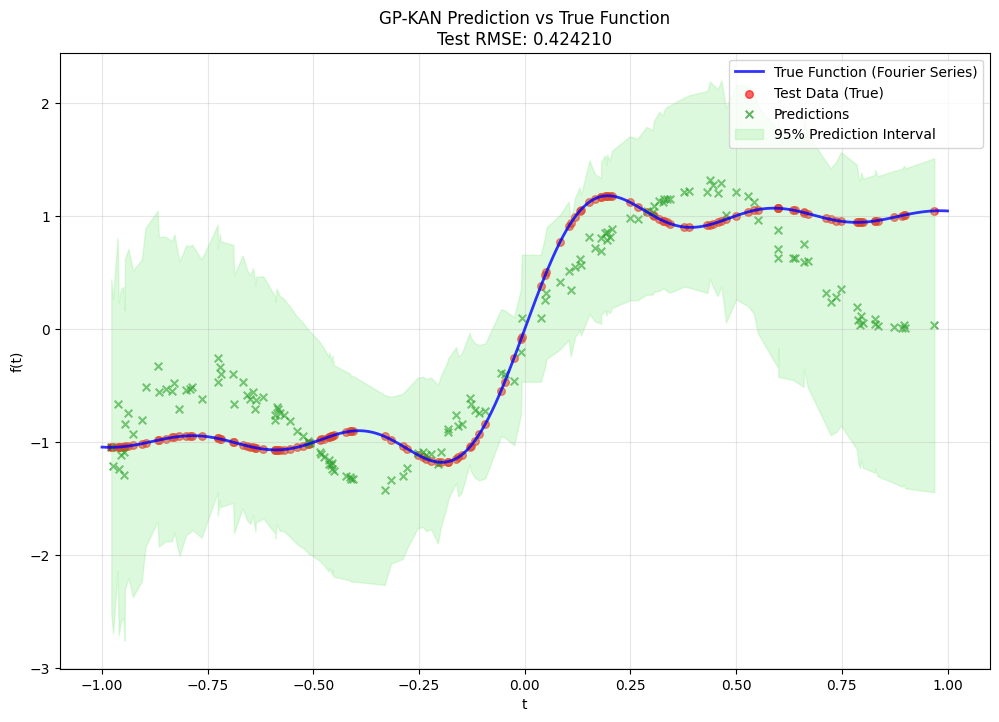

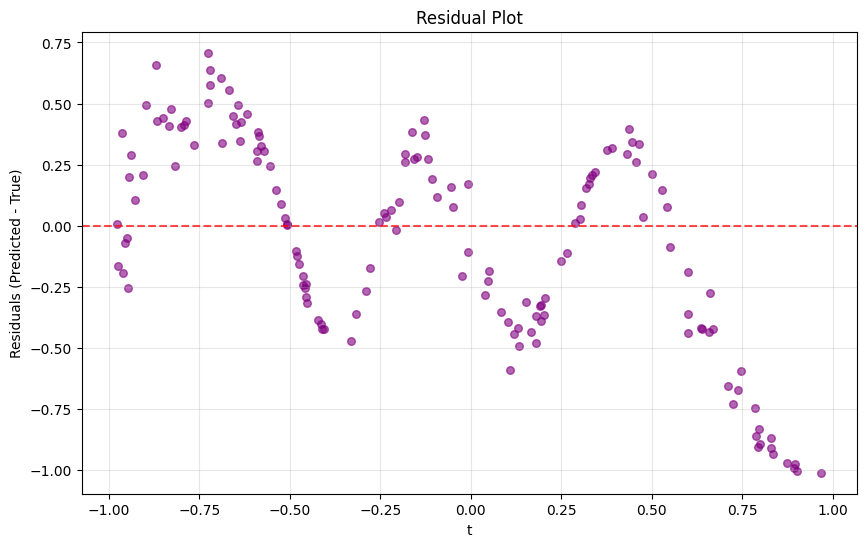


Residual Statistics:
Mean: -0.055576
Std: 0.420554
Min: -1.013101
Max: 0.708097
plot completed
epoch 0  , train negloglik: 0.62756,    val negloglik: 0.59744    accuracy: 0.2557 lr: [0.0001]
epoch 1  , train negloglik: 0.59356,    val negloglik: 0.66898    accuracy: 0.2356 lr: [9e-05]
epoch 2  , train negloglik: 0.62912,    val negloglik: 0.68209    accuracy: 0.3032 lr: [9e-05]
epoch 3  , train negloglik: 0.64167,    val negloglik: 0.65037    accuracy: 0.2905 lr: [9e-05]
epoch 4  , train negloglik: 0.62518,    val negloglik: 0.58837    accuracy: 0.2626 lr: [9e-05]
epoch 5  , train negloglik: 0.65839,    val negloglik: 0.58035    accuracy: 0.2480 lr: [9e-05]
epoch 6  , train negloglik: 0.65716,    val negloglik: 0.61331    accuracy: 0.2698 lr: [9e-05]
epoch 7  , train negloglik: 0.59556,    val negloglik: 0.69018    accuracy: 0.3023 lr: [9e-05]
epoch 8  , train negloglik: 0.64476,    val negloglik: 0.74346    accuracy: 0.3108 lr: [9e-05]
epoch 9  , train negloglik: 0.60463,    val negl

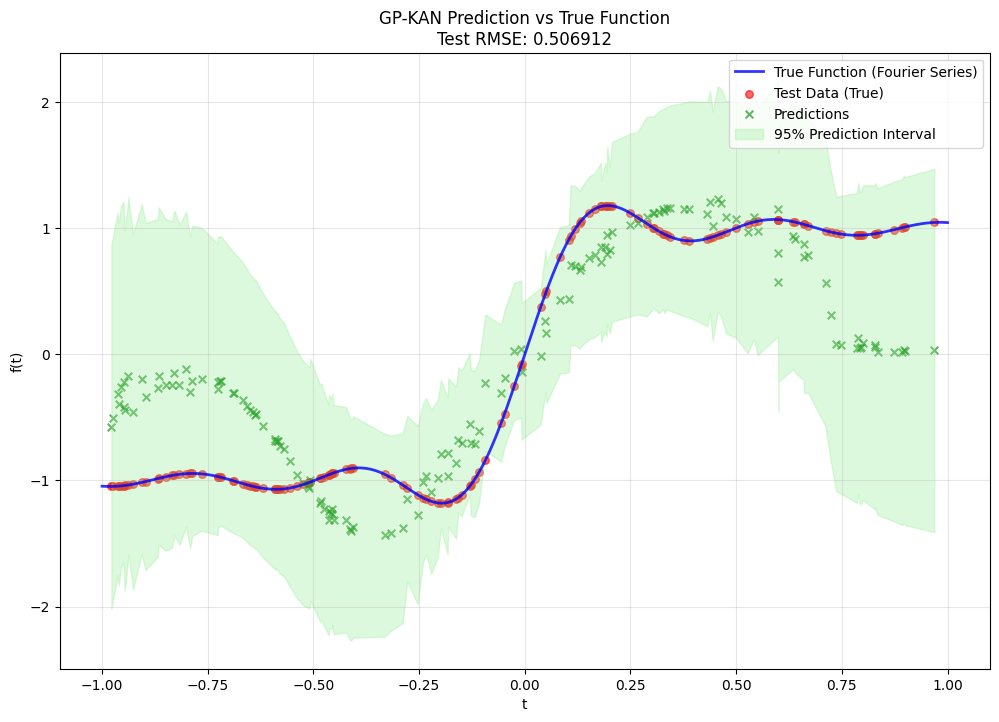

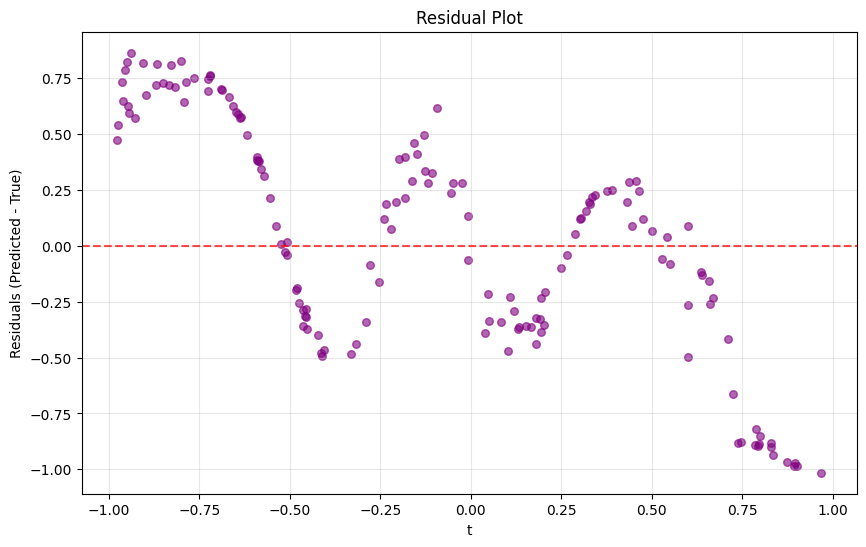


Residual Statistics:
Mean: 0.044447
Std: 0.504959
Min: -1.015300
Max: 0.863271
plot completed
epoch 0  , train negloglik: 0.61550,    val negloglik: 0.61482    accuracy: 0.2618 lr: [0.0001]
epoch 1  , train negloglik: 0.62579,    val negloglik: 0.61291    accuracy: 0.2336 lr: [9e-05]
epoch 2  , train negloglik: 0.62284,    val negloglik: 0.61334    accuracy: 0.2596 lr: [9e-05]
epoch 3  , train negloglik: 0.60199,    val negloglik: 0.64250    accuracy: 0.2174 lr: [9e-05]
epoch 4  , train negloglik: 0.61858,    val negloglik: 0.64483    accuracy: 0.2433 lr: [9e-05]
epoch 5  , train negloglik: 0.61517,    val negloglik: 0.66864    accuracy: 0.2649 lr: [9e-05]
epoch 6  , train negloglik: 0.64305,    val negloglik: 0.68541    accuracy: 0.2506 lr: [9e-05]
epoch 7  , train negloglik: 0.63682,    val negloglik: 0.62166    accuracy: 0.2673 lr: [9e-05]
epoch 8  , train negloglik: 0.66115,    val negloglik: 0.71438    accuracy: 0.2488 lr: [9e-05]
epoch 9  , train negloglik: 0.62661,    val neglo

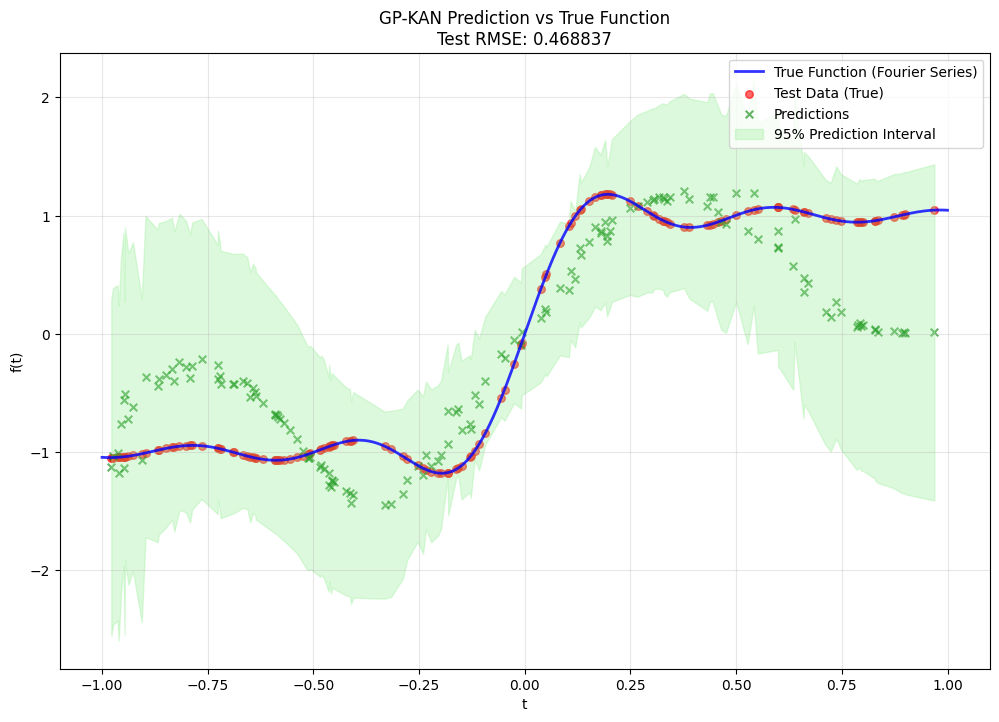

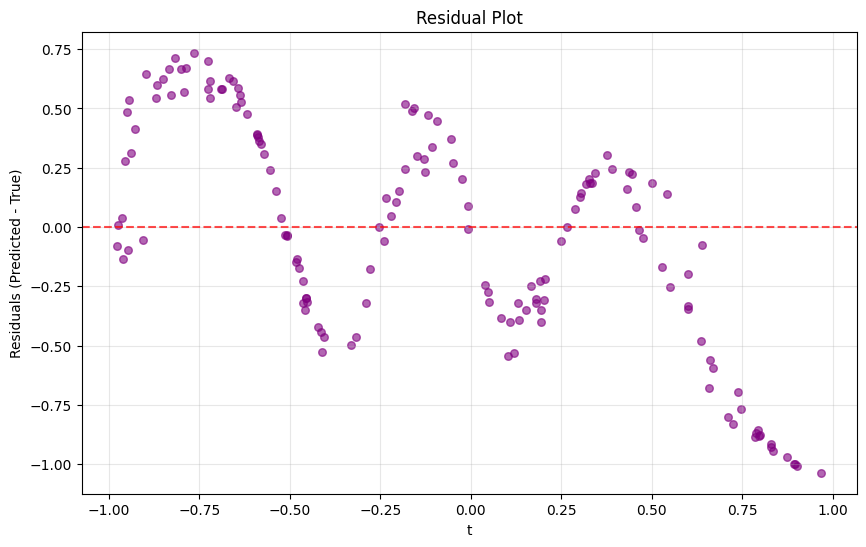


Residual Statistics:
Mean: -0.026854
Std: 0.468067
Min: -1.035266
Max: 0.734608
plot completed
epoch 0  , train negloglik: 0.65733,    val negloglik: 0.63750    accuracy: 0.2716 lr: [0.0001]
epoch 1  , train negloglik: 0.65210,    val negloglik: 0.66993    accuracy: 0.2902 lr: [9e-05]
epoch 2  , train negloglik: 0.64060,    val negloglik: 0.67122    accuracy: 0.2891 lr: [9e-05]
epoch 3  , train negloglik: 0.68819,    val negloglik: 0.70618    accuracy: 0.2973 lr: [9e-05]
epoch 4  , train negloglik: 0.61442,    val negloglik: 0.62308    accuracy: 0.3054 lr: [9e-05]
epoch 5  , train negloglik: 0.67616,    val negloglik: 0.63482    accuracy: 0.2764 lr: [9e-05]
epoch 6  , train negloglik: 0.65897,    val negloglik: 0.60891    accuracy: 0.2715 lr: [9e-05]
epoch 7  , train negloglik: 0.65850,    val negloglik: 0.81225    accuracy: 0.3293 lr: [9e-05]
epoch 8  , train negloglik: 0.63352,    val negloglik: 0.63929    accuracy: 0.2608 lr: [9e-05]
epoch 9  , train negloglik: 0.65112,    val negl

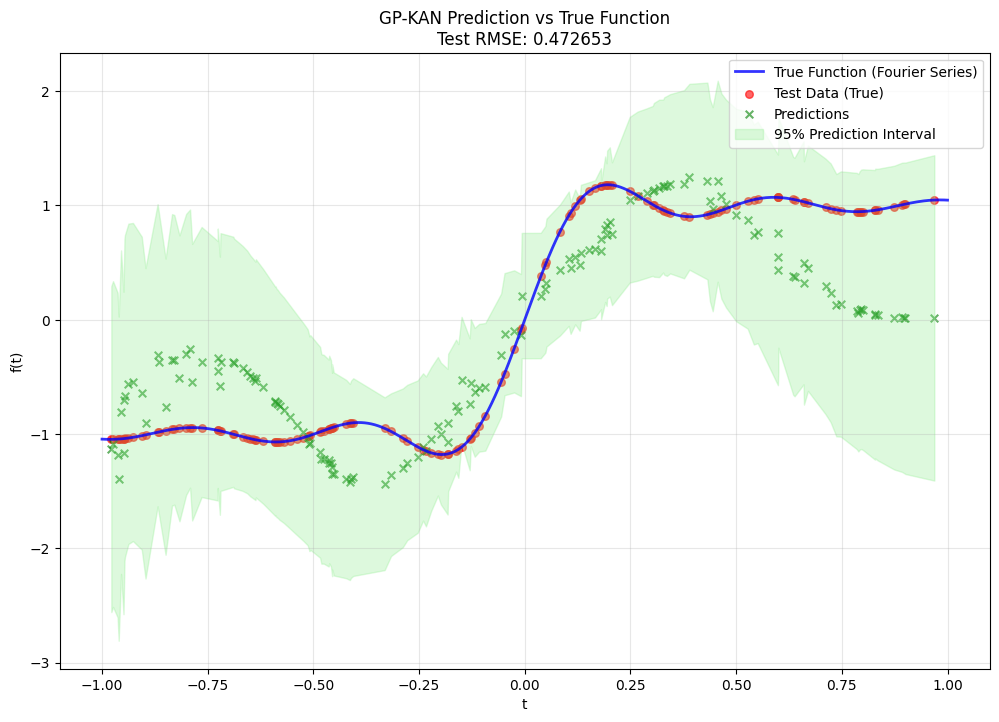

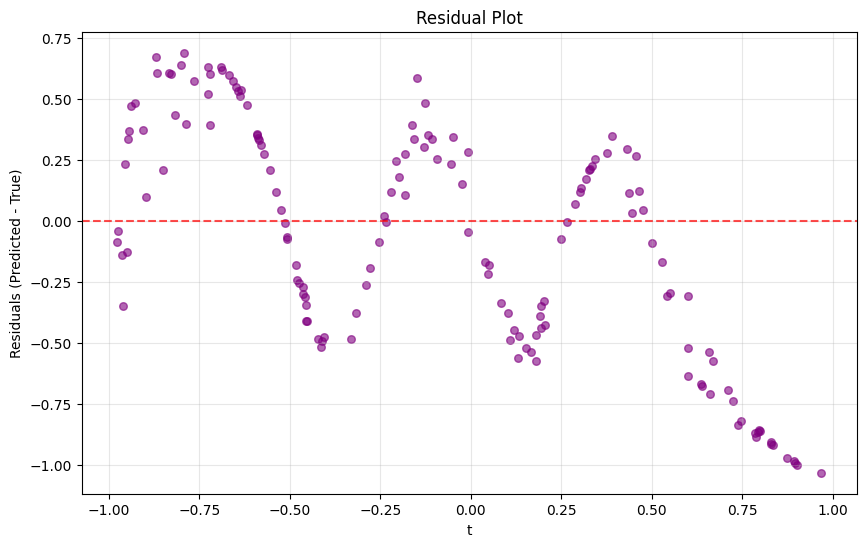


Residual Statistics:
Mean: -0.064228
Std: 0.468269
Min: -1.031268
Max: 0.691093
plot completed
epoch 0  , train negloglik: 0.62371,    val negloglik: 0.71098    accuracy: 0.3040 lr: [0.0001]
epoch 1  , train negloglik: 0.69157,    val negloglik: 0.70556    accuracy: 0.2842 lr: [9e-05]
epoch 2  , train negloglik: 0.66427,    val negloglik: 0.74434    accuracy: 0.3144 lr: [9e-05]
epoch 3  , train negloglik: 0.68295,    val negloglik: 0.66939    accuracy: 0.2918 lr: [9e-05]
epoch 4  , train negloglik: 0.68867,    val negloglik: 0.62839    accuracy: 0.2681 lr: [9e-05]
epoch 5  , train negloglik: 0.68159,    val negloglik: 0.67153    accuracy: 0.2897 lr: [9e-05]
epoch 6  , train negloglik: 0.64515,    val negloglik: 0.61845    accuracy: 0.2571 lr: [9e-05]
epoch 7  , train negloglik: 0.66523,    val negloglik: 0.68098    accuracy: 0.2903 lr: [9e-05]
epoch 8  , train negloglik: 0.66251,    val negloglik: 0.69231    accuracy: 0.2984 lr: [9e-05]
epoch 9  , train negloglik: 0.66398,    val negl

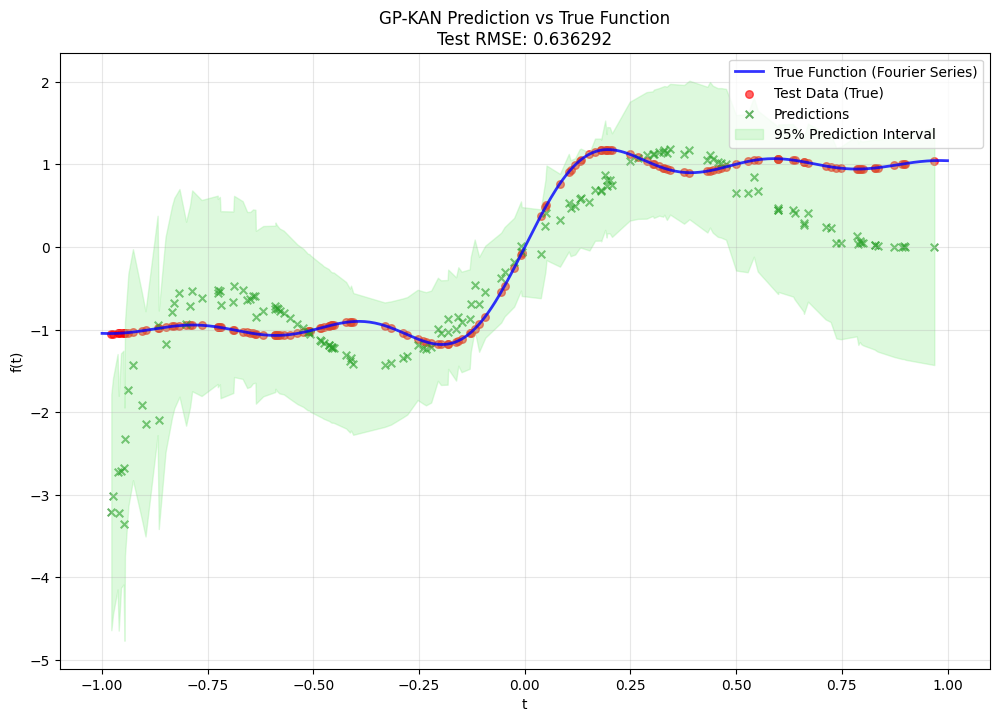

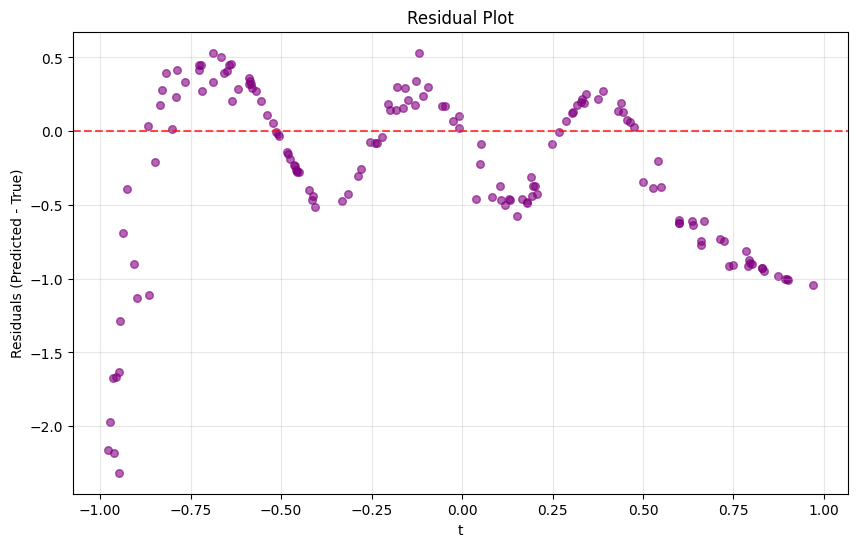


Residual Statistics:
Mean: -0.261263
Std: 0.580180
Min: -2.315202
Max: 0.531767
plot completed


In [ ]:
# 10エポックずつ学習を行い、カーネル行列のランクを可視化する
rank_list_layer0 = []
condition_number_list_layer0 = []
eigenvals_list_layer0 = []

rank_list_layer1 = []
condition_number_list_layer1 = []
eigenvals_list_layer1 = []

for epoch in range(20):
    runner.train_model(
        train_dataloader,
        val_dataloader,
        model,
        epochs=20,
        learning_rate=1e-4,
        use_gpu=False,  # True,
        pretrain=False,  # True,
        global_jitter=1e-3,
        baseline_jitter=1e-3,
    )
    model.save_model()  # optionally save the model after training

    # カーネル行列のランクを計算 (Layer 0)
    rank_0, condition_number_0, eigenvals_0 = compute_kernel_rank(model, depth=0)
    rank_list_layer0.append(rank_0)
    condition_number_list_layer0.append(condition_number_0)
    eigenvals_list_layer0.append(eigenvals_0)

    # カーネル行列のランクを計算 (Layer 1)
    rank_1, condition_number_1, eigenvals_1 = compute_kernel_rank(model, depth=1)
    rank_list_layer1.append(rank_1)
    condition_number_list_layer1.append(condition_number_1)
    eigenvals_list_layer1.append(eigenvals_1)

    # 可視化
    plot_result(model)

epoch 0  , train negloglik: 0.66396,    val negloglik: 0.66939    accuracy: 0.2762 lr: [0.0001]
epoch 1  , train negloglik: 0.65226,    val negloglik: 0.69454    accuracy: 0.2943 lr: [9e-05]
epoch 2  , train negloglik: 0.66849,    val negloglik: 0.70317    accuracy: 0.2549 lr: [9e-05]
epoch 3  , train negloglik: 0.64631,    val negloglik: 0.66880    accuracy: 0.2872 lr: [9e-05]
epoch 4  , train negloglik: 0.67567,    val negloglik: 0.76398    accuracy: 0.3304 lr: [9e-05]
epoch 5  , train negloglik: 0.66028,    val negloglik: 0.75019    accuracy: 0.2922 lr: [9e-05]
epoch 6  , train negloglik: 0.64702,    val negloglik: 0.65248    accuracy: 0.2729 lr: [9e-05]
epoch 7  , train negloglik: 0.62710,    val negloglik: 0.66637    accuracy: 0.2456 lr: [9e-05]
epoch 8  , train negloglik: 0.67148,    val negloglik: 0.79028    accuracy: 0.2683 lr: [9e-05]
epoch 9  , train negloglik: 0.65524,    val negloglik: 0.64808    accuracy: 0.2508 lr: [9e-05]
epoch 10 , train negloglik: 0.63664,    val neglo

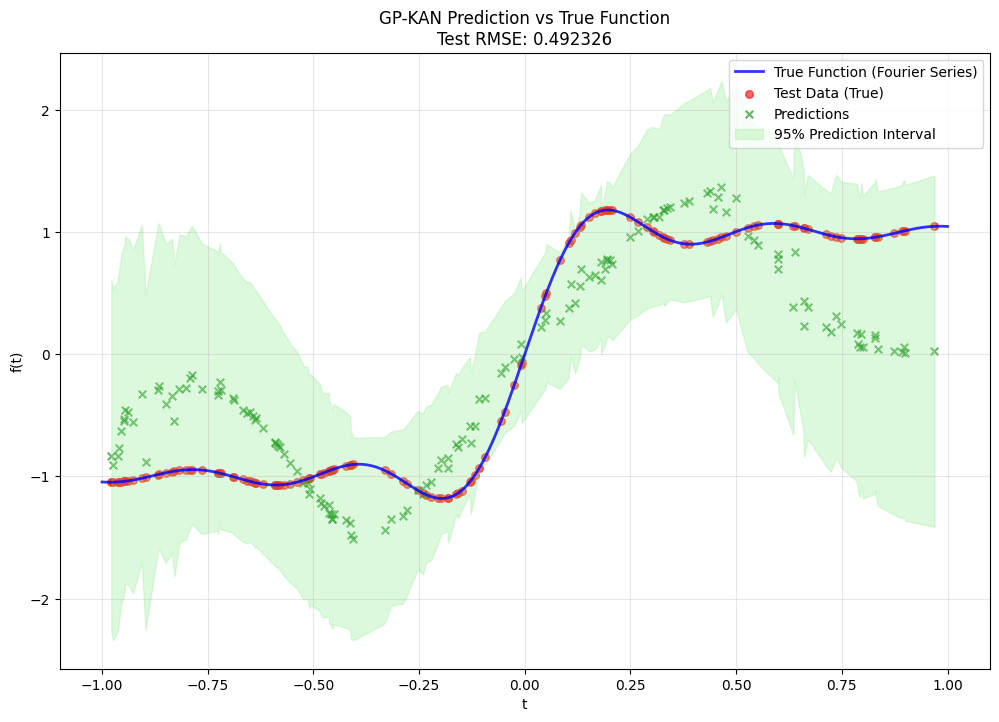

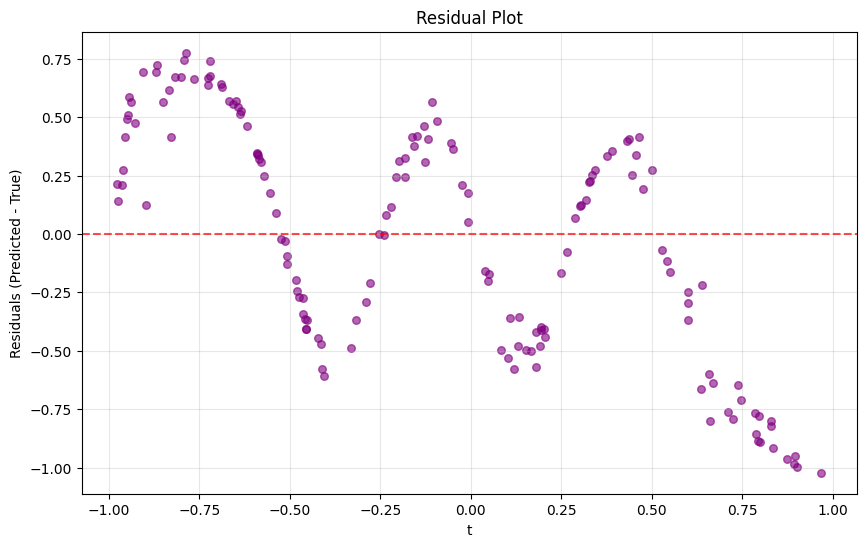


Residual Statistics:
Mean: -0.010238
Std: 0.492220
Min: -1.022088
Max: 0.775939
plot completed
epoch 0  , train negloglik: 0.64702,    val negloglik: 0.66453    accuracy: 0.2560 lr: [0.0001]
epoch 1  , train negloglik: 0.66764,    val negloglik: 0.76930    accuracy: 0.3356 lr: [9e-05]
epoch 2  , train negloglik: 0.68626,    val negloglik: 0.67301    accuracy: 0.2463 lr: [9e-05]
epoch 3  , train negloglik: 0.66266,    val negloglik: 0.64858    accuracy: 0.2713 lr: [9e-05]
epoch 4  , train negloglik: 0.64980,    val negloglik: 0.66348    accuracy: 0.2816 lr: [9e-05]
epoch 5  , train negloglik: 0.64594,    val negloglik: 0.66742    accuracy: 0.2733 lr: [9e-05]
epoch 6  , train negloglik: 0.66711,    val negloglik: 0.70511    accuracy: 0.2903 lr: [9e-05]
epoch 7  , train negloglik: 0.66088,    val negloglik: 0.70268    accuracy: 0.2796 lr: [9e-05]
epoch 8  , train negloglik: 0.66671,    val negloglik: 0.61728    accuracy: 0.2623 lr: [9e-05]
epoch 9  , train negloglik: 0.67248,    val negl

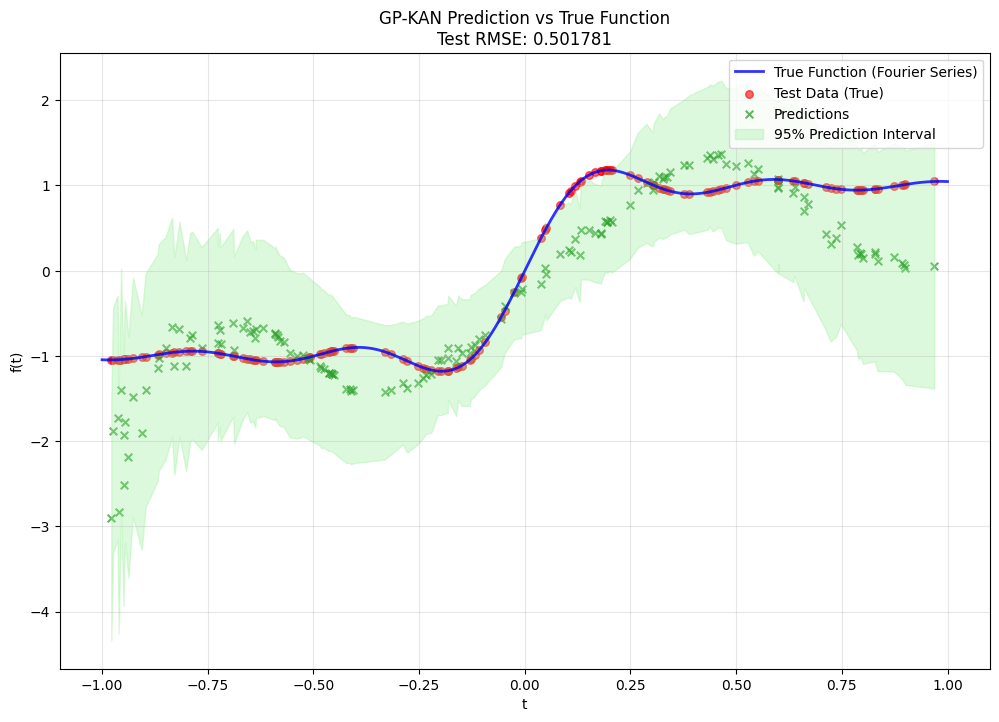

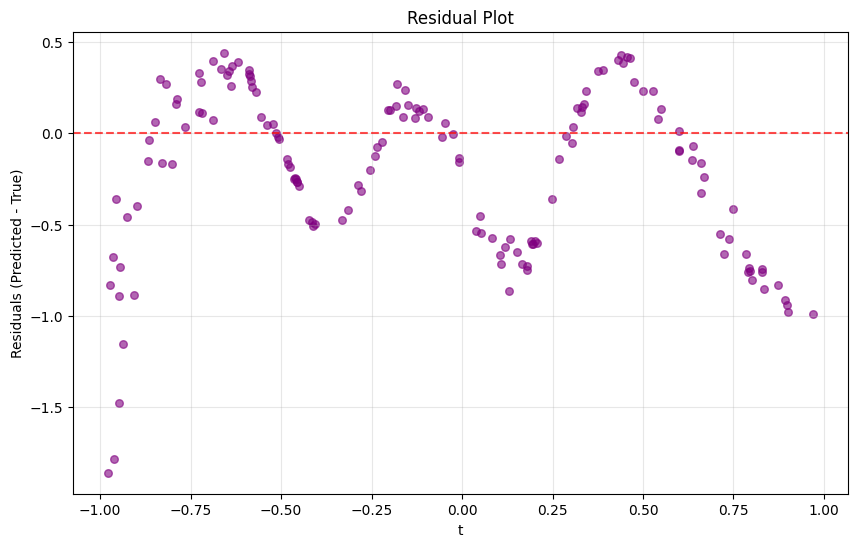


Residual Statistics:
Mean: -0.209618
Std: 0.455899
Min: -1.857370
Max: 0.439622
plot completed
epoch 0  , train negloglik: 0.67892,    val negloglik: 0.67549    accuracy: 0.2860 lr: [0.0001]
epoch 1  , train negloglik: 0.67055,    val negloglik: 0.65766    accuracy: 0.3067 lr: [9e-05]
epoch 2  , train negloglik: 0.64347,    val negloglik: 0.69646    accuracy: 0.2924 lr: [9e-05]
epoch 3  , train negloglik: 0.65161,    val negloglik: 0.75193    accuracy: 0.3355 lr: [9e-05]
epoch 4  , train negloglik: 0.67410,    val negloglik: 0.66555    accuracy: 0.2739 lr: [9e-05]
epoch 5  , train negloglik: 0.67485,    val negloglik: 0.65760    accuracy: 0.2409 lr: [9e-05]
epoch 6  , train negloglik: 0.66797,    val negloglik: 0.75320    accuracy: 0.2980 lr: [9e-05]
epoch 7  , train negloglik: 0.66264,    val negloglik: 0.67930    accuracy: 0.2746 lr: [9e-05]
epoch 8  , train negloglik: 0.70127,    val negloglik: 0.64995    accuracy: 0.2617 lr: [9e-05]
epoch 9  , train negloglik: 0.70305,    val negl

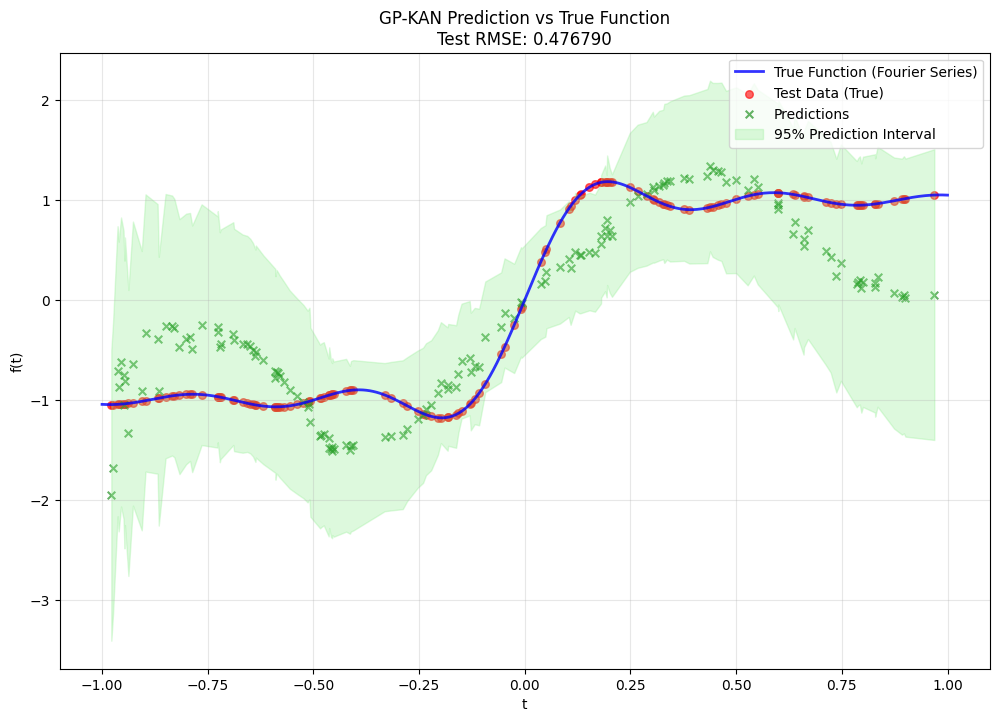

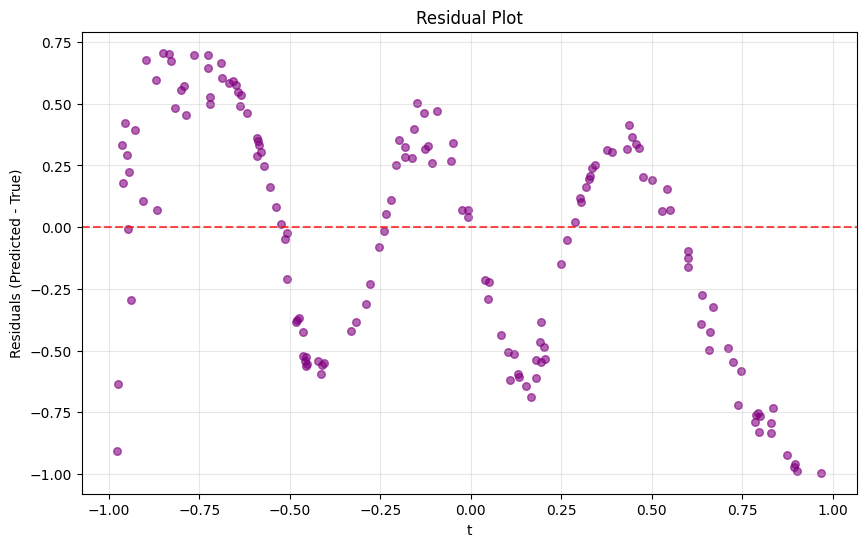


Residual Statistics:
Mean: -0.051446
Std: 0.474006
Min: -0.995126
Max: 0.706474
plot completed
epoch 0  , train negloglik: 0.68929,    val negloglik: 0.75885    accuracy: 0.3192 lr: [0.0001]
epoch 1  , train negloglik: 0.65653,    val negloglik: 0.64831    accuracy: 0.2601 lr: [9e-05]
epoch 2  , train negloglik: 0.66395,    val negloglik: 0.65852    accuracy: 0.2319 lr: [9e-05]
epoch 3  , train negloglik: 0.65413,    val negloglik: 0.69382    accuracy: 0.2903 lr: [9e-05]
epoch 4  , train negloglik: 0.65796,    val negloglik: 0.66687    accuracy: 0.2775 lr: [9e-05]
epoch 5  , train negloglik: 0.67717,    val negloglik: 0.66485    accuracy: 0.2397 lr: [9e-05]
epoch 6  , train negloglik: 0.66327,    val negloglik: 0.65577    accuracy: 0.2523 lr: [9e-05]
epoch 7  , train negloglik: 0.66424,    val negloglik: 0.80303    accuracy: 0.3369 lr: [9e-05]
epoch 8  , train negloglik: 0.66006,    val negloglik: 0.63184    accuracy: 0.2465 lr: [9e-05]
epoch 9  , train negloglik: 0.64346,    val negl

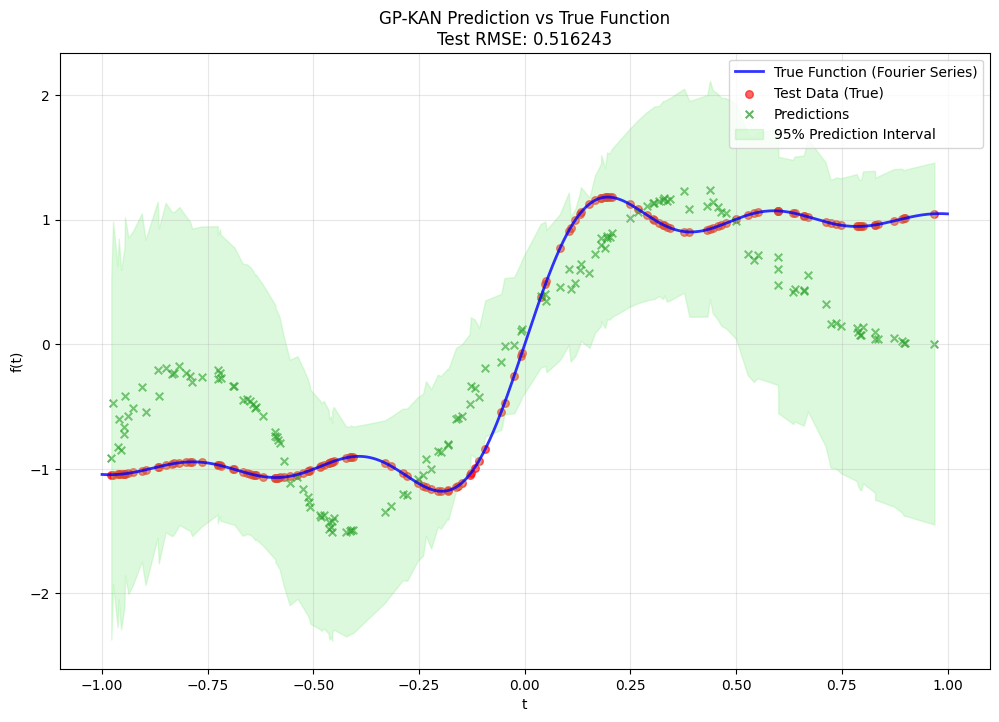

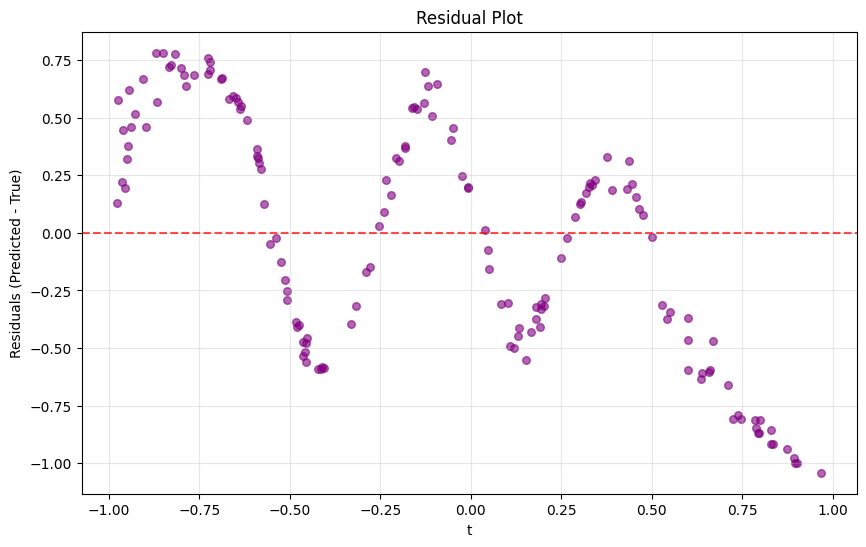


Residual Statistics:
Mean: -0.013824
Std: 0.516058
Min: -1.041710
Max: 0.782522
plot completed
epoch 0  , train negloglik: 0.67627,    val negloglik: 0.64297    accuracy: 0.2450 lr: [0.0001]
epoch 1  , train negloglik: 0.62721,    val negloglik: 0.65052    accuracy: 0.2625 lr: [9e-05]
epoch 2  , train negloglik: 0.63045,    val negloglik: 0.77038    accuracy: 0.3195 lr: [9e-05]
epoch 3  , train negloglik: 0.64150,    val negloglik: 0.71695    accuracy: 0.2932 lr: [9e-05]
epoch 4  , train negloglik: 0.63642,    val negloglik: 0.70356    accuracy: 0.2917 lr: [9e-05]
epoch 5  , train negloglik: 0.66663,    val negloglik: 0.66697    accuracy: 0.2559 lr: [9e-05]
epoch 6  , train negloglik: 0.68616,    val negloglik: 0.66475    accuracy: 0.2800 lr: [9e-05]
epoch 7  , train negloglik: 0.66095,    val negloglik: 0.77301    accuracy: 0.3194 lr: [9e-05]
epoch 8  , train negloglik: 0.62819,    val negloglik: 0.65466    accuracy: 0.2748 lr: [9e-05]
epoch 9  , train negloglik: 0.66429,    val negl

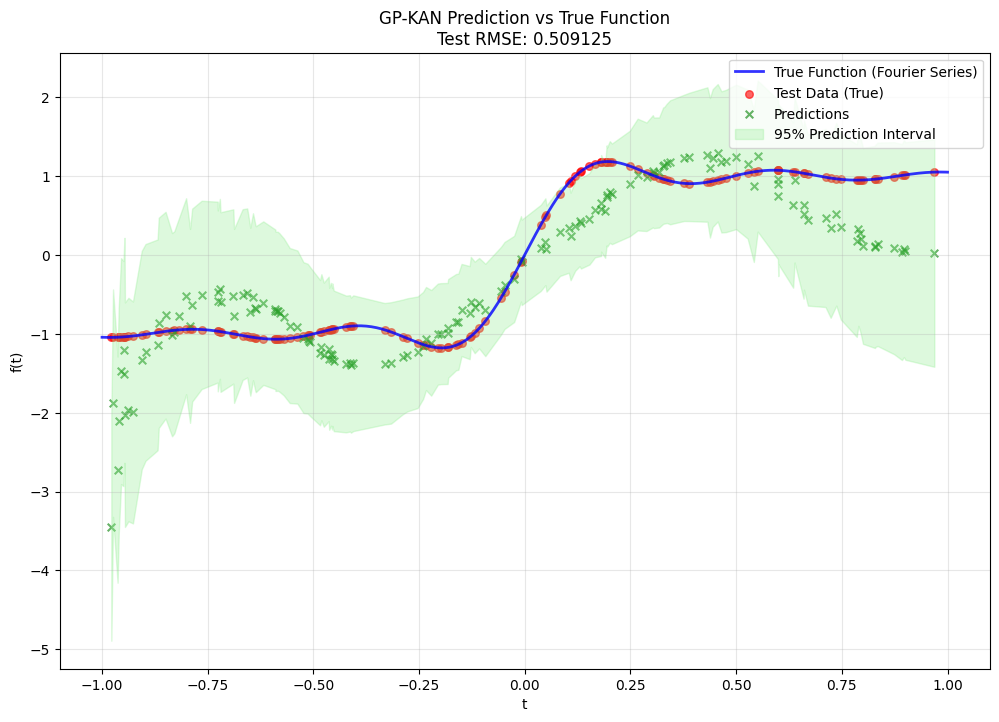

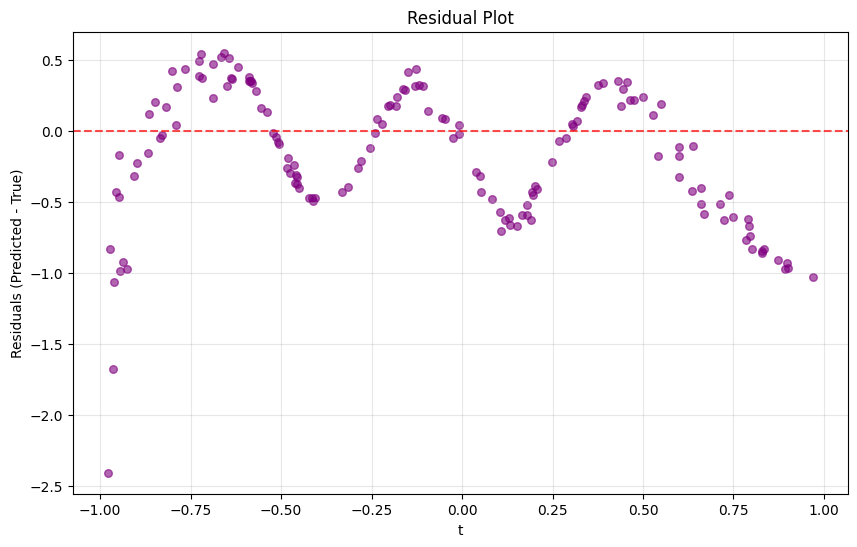


Residual Statistics:
Mean: -0.171792
Std: 0.479266
Min: -2.405544
Max: 0.550388
plot completed
epoch 0  , train negloglik: 0.63365,    val negloglik: 0.67714    accuracy: 0.2520 lr: [0.0001]
epoch 1  , train negloglik: 0.63376,    val negloglik: 0.66821    accuracy: 0.2566 lr: [9e-05]
epoch 2  , train negloglik: 0.63062,    val negloglik: 0.63358    accuracy: 0.2367 lr: [9e-05]
epoch 3  , train negloglik: 0.65500,    val negloglik: 0.70097    accuracy: 0.2252 lr: [9e-05]
epoch 4  , train negloglik: 0.67791,    val negloglik: 0.64309    accuracy: 0.2702 lr: [9e-05]
epoch 5  , train negloglik: 0.63194,    val negloglik: 0.70633    accuracy: 0.2964 lr: [9e-05]
epoch 6  , train negloglik: 0.63738,    val negloglik: 0.61358    accuracy: 0.2425 lr: [9e-05]
epoch 7  , train negloglik: 0.65783,    val negloglik: 0.68285    accuracy: 0.2913 lr: [9e-05]
epoch 8  , train negloglik: 0.64267,    val negloglik: 0.74469    accuracy: 0.3090 lr: [9e-05]
epoch 9  , train negloglik: 0.62167,    val negl

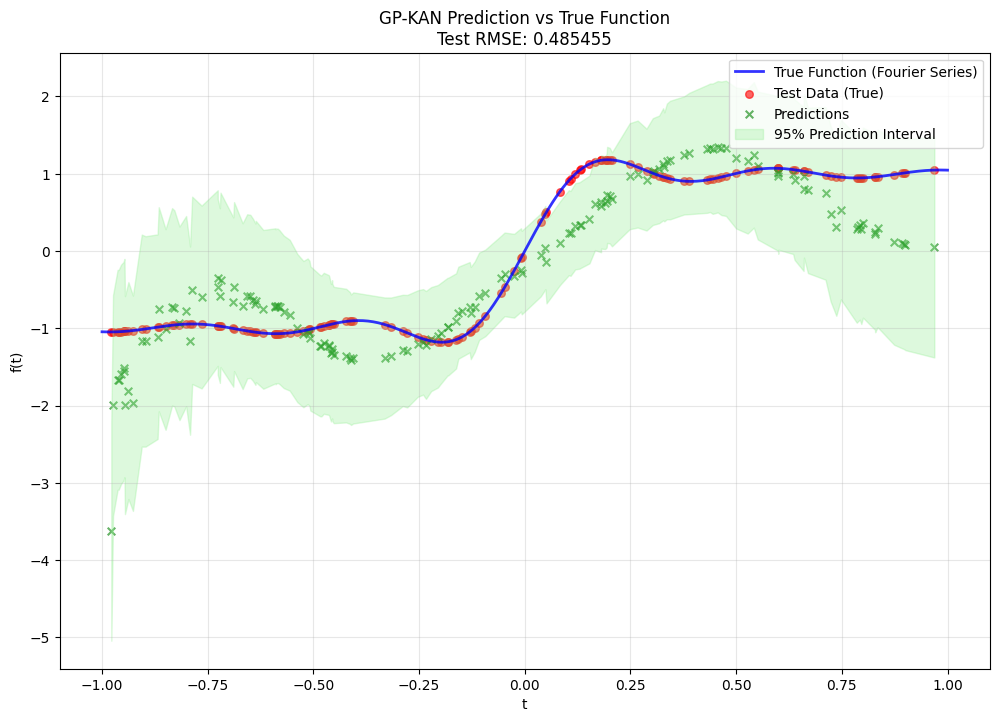

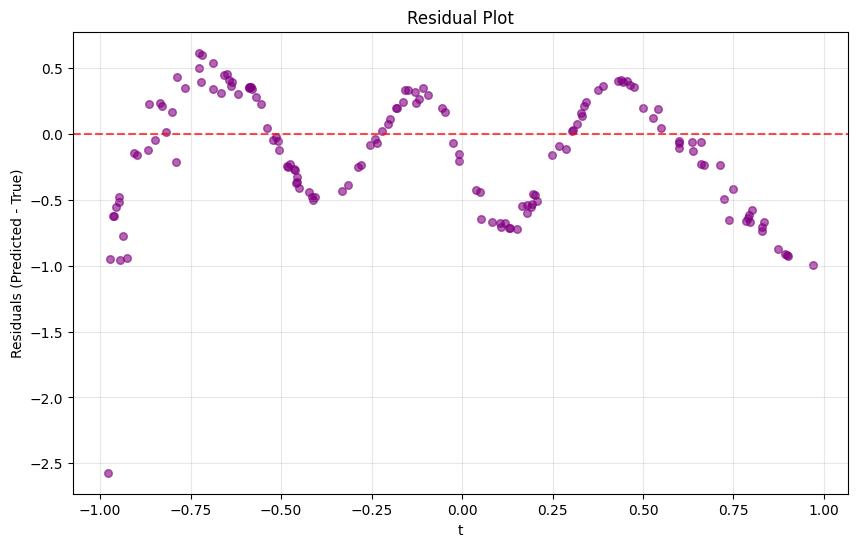


Residual Statistics:
Mean: -0.149995
Std: 0.461702
Min: -2.571606
Max: 0.617642
plot completed
epoch 0  , train negloglik: 0.62619,    val negloglik: 0.71948    accuracy: 0.3254 lr: [0.0001]
epoch 1  , train negloglik: 0.61535,    val negloglik: 0.65173    accuracy: 0.2146 lr: [9e-05]
epoch 2  , train negloglik: 0.65679,    val negloglik: 0.70142    accuracy: 0.3056 lr: [9e-05]
epoch 3  , train negloglik: 0.62100,    val negloglik: 0.71667    accuracy: 0.3034 lr: [9e-05]
epoch 4  , train negloglik: 0.62445,    val negloglik: 0.68245    accuracy: 0.2786 lr: [9e-05]
epoch 5  , train negloglik: 0.63665,    val negloglik: 0.65178    accuracy: 0.2468 lr: [9e-05]
epoch 6  , train negloglik: 0.65076,    val negloglik: 0.66872    accuracy: 0.2422 lr: [9e-05]
epoch 7  , train negloglik: 0.64022,    val negloglik: 0.62263    accuracy: 0.2521 lr: [9e-05]
epoch 8  , train negloglik: 0.66067,    val negloglik: 0.66390    accuracy: 0.2734 lr: [9e-05]
epoch 9  , train negloglik: 0.63471,    val negl

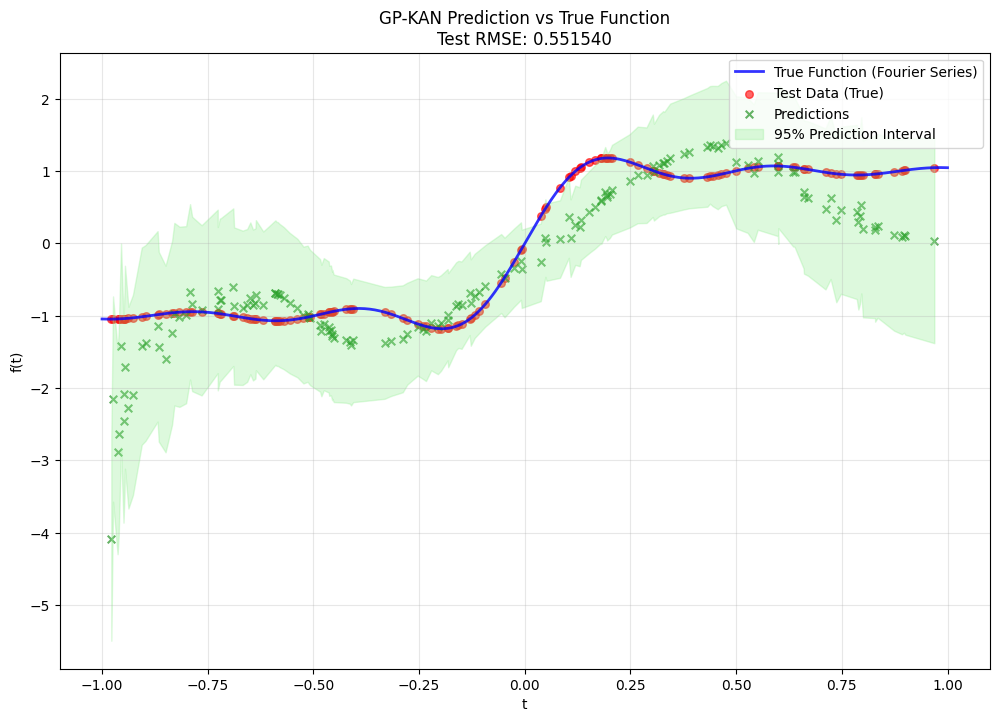

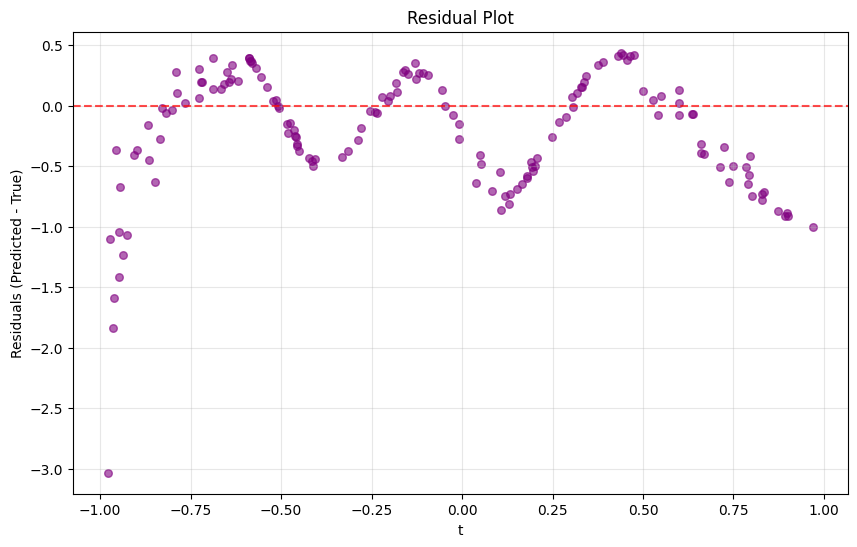


Residual Statistics:
Mean: -0.221337
Std: 0.505180
Min: -3.033452
Max: 0.436311
plot completed
epoch 0  , train negloglik: 0.65405,    val negloglik: 0.64065    accuracy: 0.2658 lr: [0.0001]
epoch 1  , train negloglik: 0.63610,    val negloglik: 0.63111    accuracy: 0.2604 lr: [9e-05]
epoch 2  , train negloglik: 0.61142,    val negloglik: 0.83067    accuracy: 0.4248 lr: [9e-05]
epoch 3  , train negloglik: 0.63441,    val negloglik: 0.59197    accuracy: 0.2343 lr: [9e-05]
epoch 4  , train negloglik: 0.63115,    val negloglik: 0.62782    accuracy: 0.2580 lr: [9e-05]
epoch 5  , train negloglik: 0.64412,    val negloglik: 0.60898    accuracy: 0.2542 lr: [9e-05]
epoch 6  , train negloglik: 0.61173,    val negloglik: 0.58886    accuracy: 0.2459 lr: [9e-05]
epoch 7  , train negloglik: 0.61704,    val negloglik: 0.60026    accuracy: 0.2355 lr: [9e-05]
epoch 8  , train negloglik: 0.59449,    val negloglik: 0.59158    accuracy: 0.2361 lr: [9e-05]
epoch 9  , train negloglik: 0.61760,    val negl

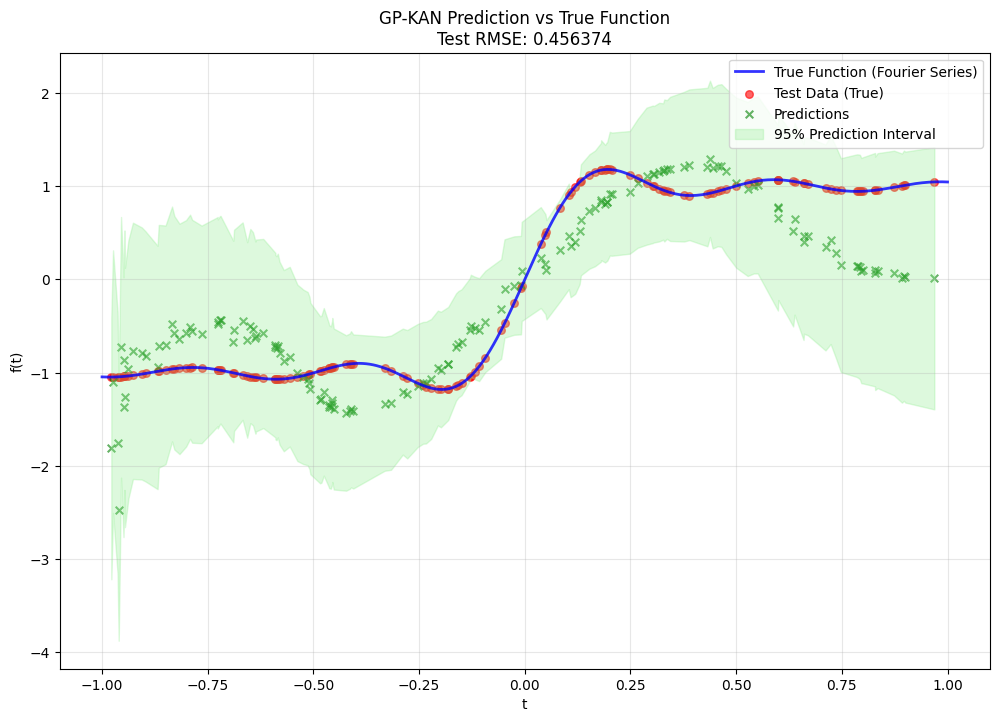

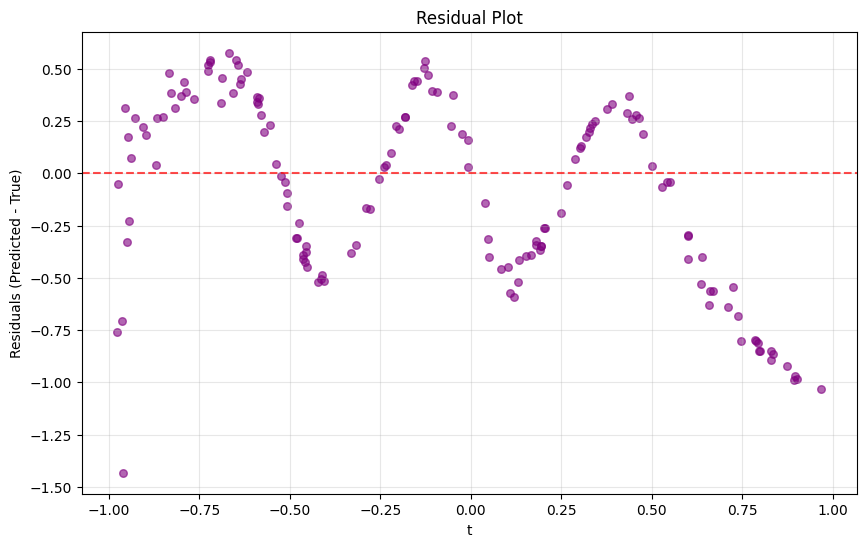


Residual Statistics:
Mean: -0.087168
Std: 0.447972
Min: -1.432832
Max: 0.577152
plot completed
epoch 0  , train negloglik: 0.59656,    val negloglik: 0.65501    accuracy: 0.2325 lr: [0.0001]
epoch 1  , train negloglik: 0.60462,    val negloglik: 0.57786    accuracy: 0.2338 lr: [9e-05]
epoch 2  , train negloglik: 0.59293,    val negloglik: 0.58941    accuracy: 0.2177 lr: [9e-05]
epoch 3  , train negloglik: 0.60410,    val negloglik: 0.60230    accuracy: 0.2368 lr: [9e-05]
epoch 4  , train negloglik: 0.61984,    val negloglik: 0.58495    accuracy: 0.2167 lr: [9e-05]
epoch 5  , train negloglik: 0.61111,    val negloglik: 0.59251    accuracy: 0.2273 lr: [9e-05]
epoch 6  , train negloglik: 0.59610,    val negloglik: 0.59477    accuracy: 0.2424 lr: [9e-05]
epoch 7  , train negloglik: 0.60370,    val negloglik: 0.56749    accuracy: 0.2282 lr: [9e-05]
epoch 8  , train negloglik: 0.62113,    val negloglik: 0.60935    accuracy: 0.2269 lr: [9e-05]
epoch 9  , train negloglik: 0.60016,    val negl

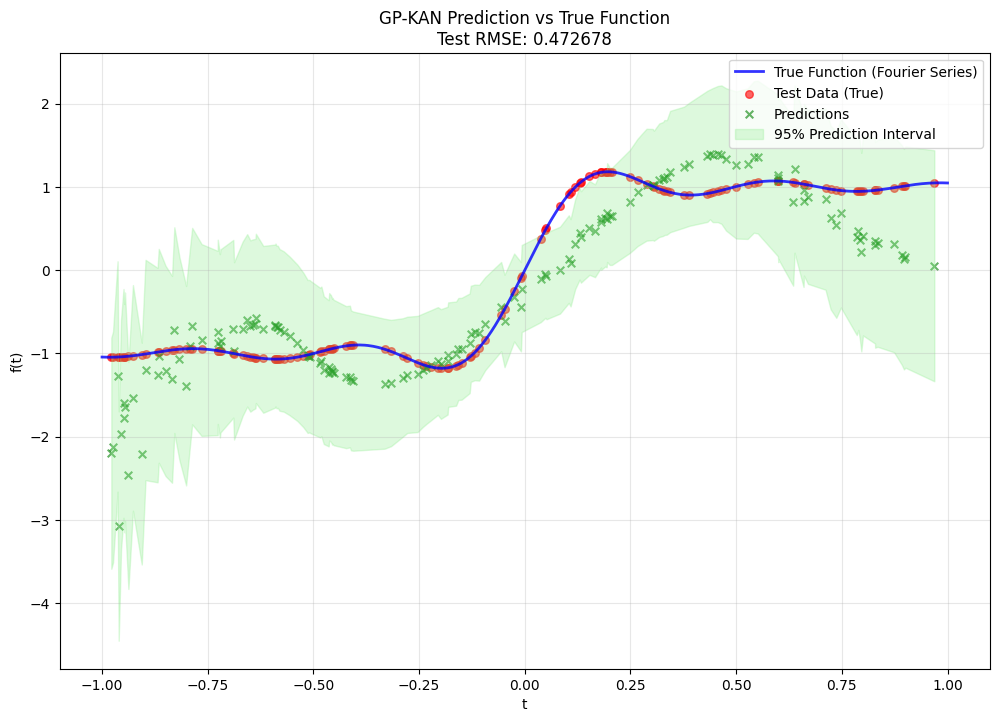

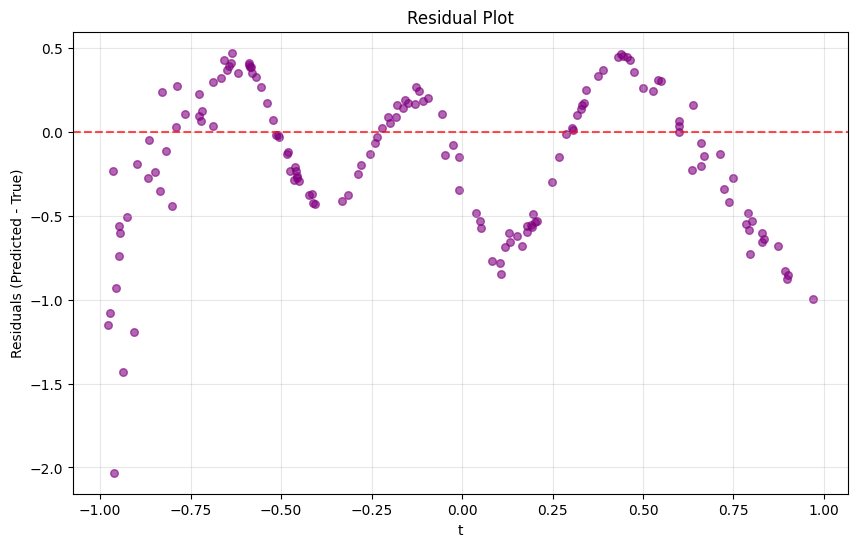


Residual Statistics:
Mean: -0.172396
Std: 0.440118
Min: -2.031163
Max: 0.470609
plot completed
epoch 0  , train negloglik: 0.59958,    val negloglik: 0.62477    accuracy: 0.2562 lr: [0.0001]
epoch 1  , train negloglik: 0.60460,    val negloglik: 0.62921    accuracy: 0.2548 lr: [9e-05]
epoch 2  , train negloglik: 0.60264,    val negloglik: 0.77718    accuracy: 0.3010 lr: [9e-05]
epoch 3  , train negloglik: 0.61706,    val negloglik: 0.59352    accuracy: 0.2255 lr: [9e-05]
epoch 4  , train negloglik: 0.56669,    val negloglik: 0.62026    accuracy: 0.2139 lr: [9e-05]
epoch 5  , train negloglik: 0.59260,    val negloglik: 0.57500    accuracy: 0.2140 lr: [9e-05]
epoch 6  , train negloglik: 0.58784,    val negloglik: 0.57797    accuracy: 0.2161 lr: [9e-05]
epoch 7  , train negloglik: 0.59757,    val negloglik: 0.64319    accuracy: 0.2691 lr: [9e-05]
epoch 8  , train negloglik: 0.61161,    val negloglik: 0.58719    accuracy: 0.2223 lr: [9e-05]
epoch 9  , train negloglik: 0.59549,    val negl

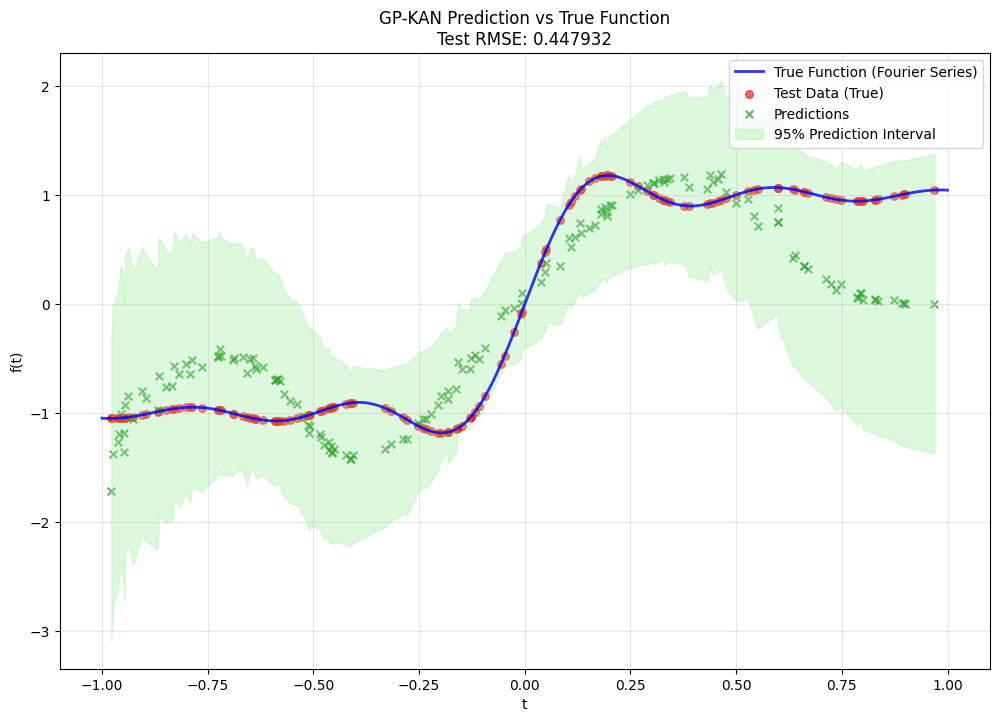

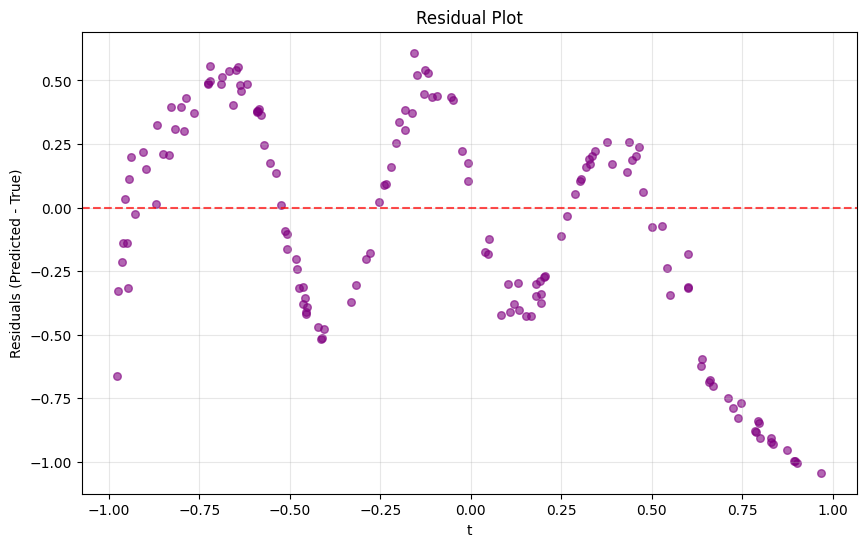


Residual Statistics:
Mean: -0.079843
Std: 0.440759
Min: -1.043208
Max: 0.608959
plot completed
epoch 0  , train negloglik: 0.58837,    val negloglik: 0.66826    accuracy: 0.2220 lr: [0.0001]
epoch 1  , train negloglik: 0.58000,    val negloglik: 0.58359    accuracy: 0.2174 lr: [9e-05]
epoch 2  , train negloglik: 0.58128,    val negloglik: 0.60014    accuracy: 0.2183 lr: [9e-05]
epoch 3  , train negloglik: 0.57885,    val negloglik: 0.58034    accuracy: 0.2291 lr: [9e-05]
epoch 4  , train negloglik: 0.57407,    val negloglik: 0.64843    accuracy: 0.2599 lr: [9e-05]
epoch 5  , train negloglik: 0.60591,    val negloglik: 0.64188    accuracy: 0.2508 lr: [9e-05]
epoch 6  , train negloglik: 0.57865,    val negloglik: 0.62564    accuracy: 0.2604 lr: [9e-05]
epoch 7  , train negloglik: 0.60713,    val negloglik: 0.57359    accuracy: 0.2240 lr: [9e-05]
epoch 8  , train negloglik: 0.57426,    val negloglik: 0.57289    accuracy: 0.2154 lr: [9e-05]
epoch 9  , train negloglik: 0.58281,    val negl

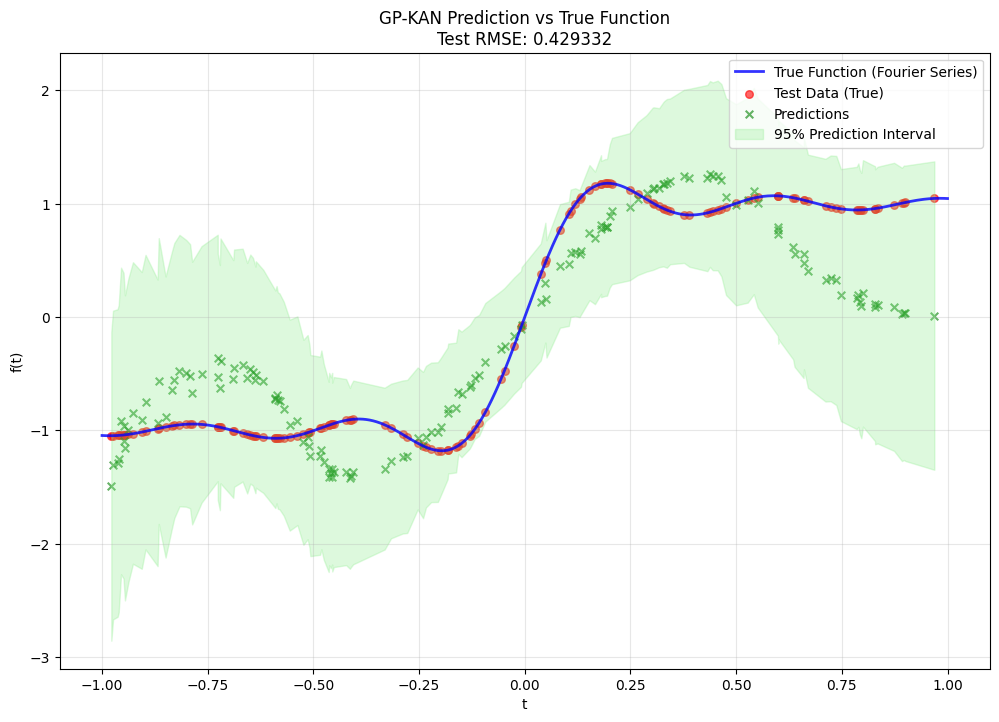

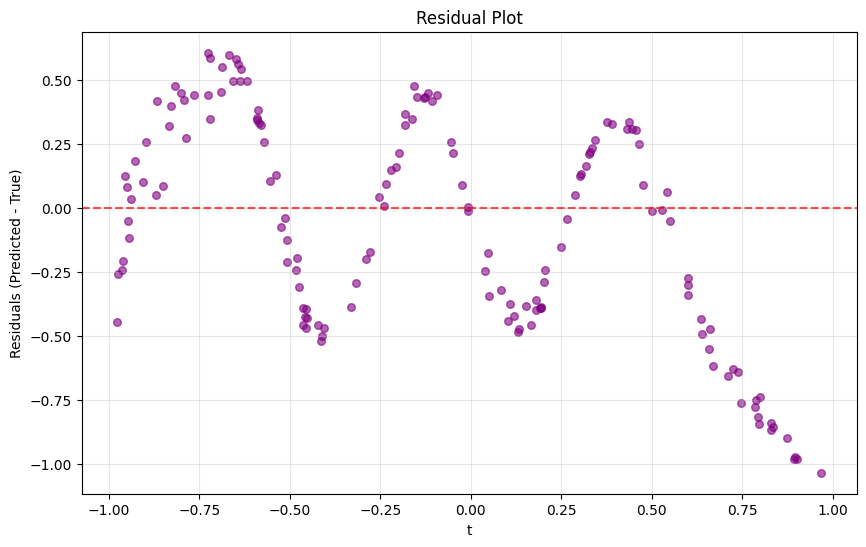


Residual Statistics:
Mean: -0.067884
Std: 0.423932
Min: -1.033759
Max: 0.607037
plot completed
epoch 0  , train negloglik: 0.59280,    val negloglik: 0.64947    accuracy: 0.2733 lr: [0.0001]
epoch 1  , train negloglik: 0.59457,    val negloglik: 0.64000    accuracy: 0.2084 lr: [9e-05]
epoch 2  , train negloglik: 0.58657,    val negloglik: 0.59651    accuracy: 0.2341 lr: [9e-05]
epoch 3  , train negloglik: 0.58821,    val negloglik: 0.55482    accuracy: 0.2077 lr: [9e-05]
epoch 4  , train negloglik: 0.58901,    val negloglik: 0.59390    accuracy: 0.2480 lr: [9e-05]
epoch 5  , train negloglik: 0.58203,    val negloglik: 0.58200    accuracy: 0.2214 lr: [9e-05]
epoch 6  , train negloglik: 0.56870,    val negloglik: 0.59847    accuracy: 0.2083 lr: [9e-05]
epoch 7  , train negloglik: 0.58719,    val negloglik: 0.60941    accuracy: 0.2605 lr: [9e-05]
epoch 8  , train negloglik: 0.58053,    val negloglik: 0.56771    accuracy: 0.2216 lr: [9e-05]
epoch 9  , train negloglik: 0.58049,    val negl

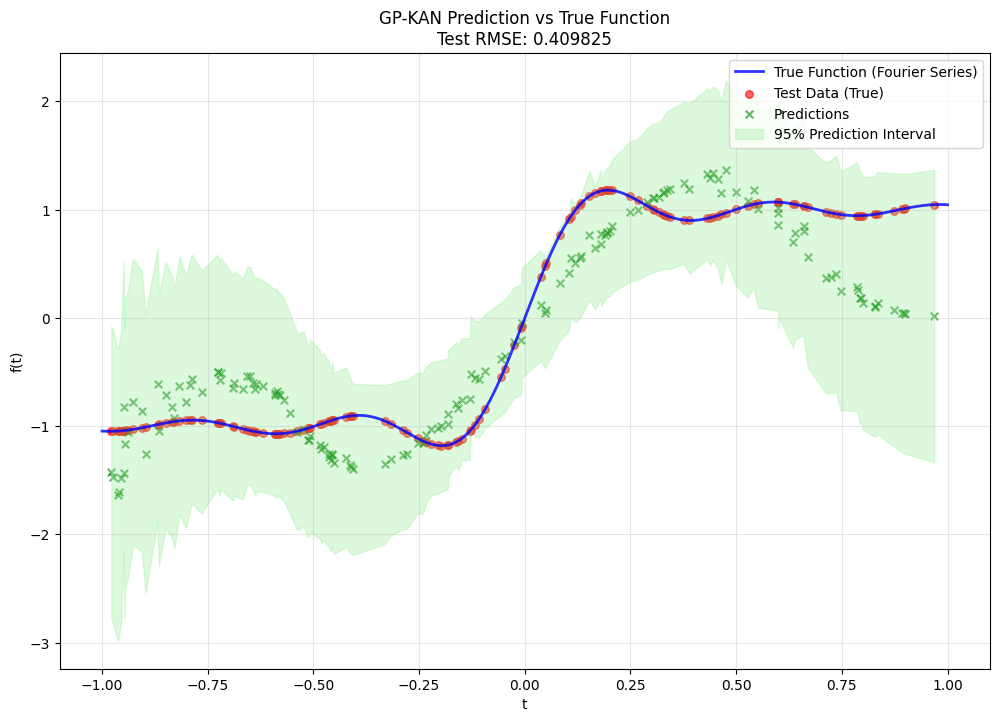

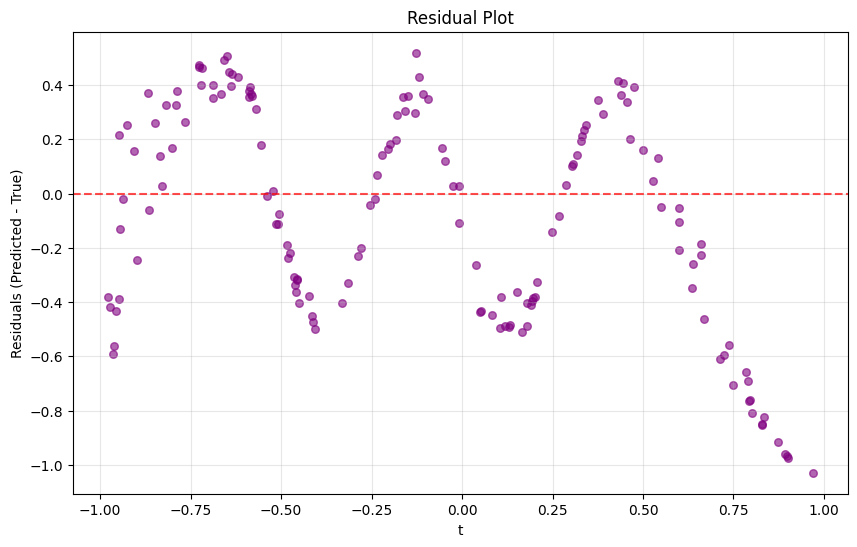


Residual Statistics:
Mean: -0.086301
Std: 0.400635
Min: -1.028996
Max: 0.519441
plot completed
epoch 0  , train negloglik: 0.60320,    val negloglik: 0.66209    accuracy: 0.2055 lr: [0.0001]
epoch 1  , train negloglik: 0.57303,    val negloglik: 0.66805    accuracy: 0.2734 lr: [9e-05]
epoch 2  , train negloglik: 0.56331,    val negloglik: 0.58258    accuracy: 0.2155 lr: [9e-05]
epoch 3  , train negloglik: 0.56085,    val negloglik: 0.57524    accuracy: 0.2281 lr: [9e-05]
epoch 4  , train negloglik: 0.56125,    val negloglik: 0.59342    accuracy: 0.2082 lr: [9e-05]
epoch 5  , train negloglik: 0.57752,    val negloglik: 0.58507    accuracy: 0.2264 lr: [9e-05]
epoch 6  , train negloglik: 0.56276,    val negloglik: 0.57952    accuracy: 0.2333 lr: [9e-05]
epoch 7  , train negloglik: 0.56948,    val negloglik: 0.60992    accuracy: 0.2166 lr: [9e-05]
epoch 8  , train negloglik: 0.56717,    val negloglik: 0.57672    accuracy: 0.2452 lr: [9e-05]
epoch 9  , train negloglik: 0.58768,    val negl

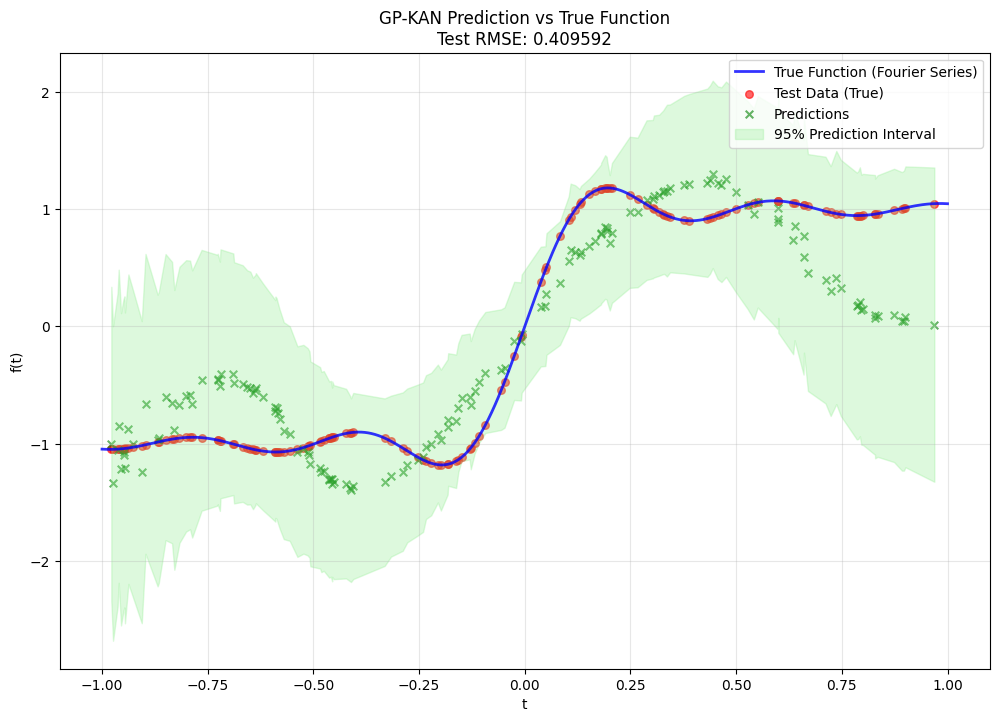

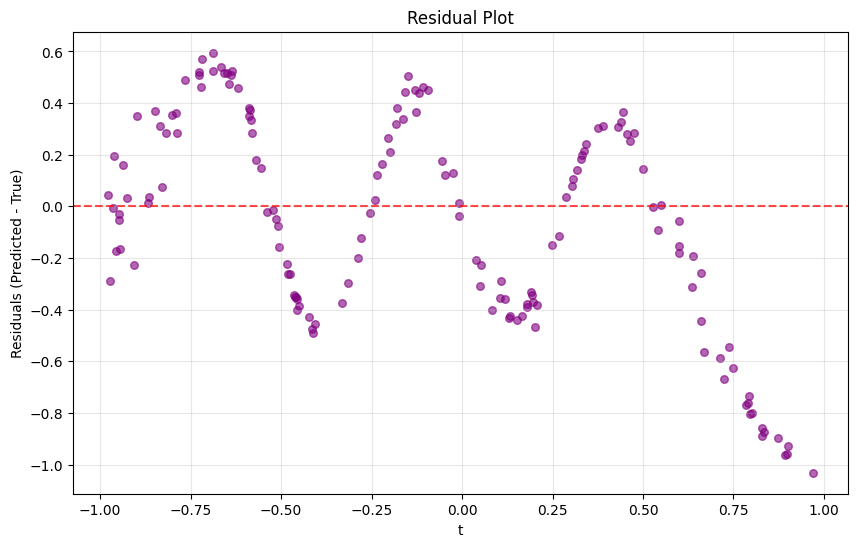


Residual Statistics:
Mean: -0.057118
Std: 0.405590
Min: -1.031206
Max: 0.594871
plot completed
epoch 0  , train negloglik: 0.56770,    val negloglik: 0.59104    accuracy: 0.2286 lr: [0.0001]
epoch 1  , train negloglik: 0.55544,    val negloglik: 0.57452    accuracy: 0.2308 lr: [9e-05]
epoch 2  , train negloglik: 0.57177,    val negloglik: 0.59570    accuracy: 0.2228 lr: [9e-05]
epoch 3  , train negloglik: 0.55641,    val negloglik: 0.55891    accuracy: 0.2091 lr: [9e-05]
epoch 4  , train negloglik: 0.55985,    val negloglik: 0.57194    accuracy: 0.2292 lr: [9e-05]
epoch 5  , train negloglik: 0.55644,    val negloglik: 0.64839    accuracy: 0.2266 lr: [9e-05]
epoch 6  , train negloglik: 0.59703,    val negloglik: 0.56530    accuracy: 0.2097 lr: [9e-05]
epoch 7  , train negloglik: 0.56720,    val negloglik: 0.58273    accuracy: 0.2024 lr: [9e-05]
epoch 8  , train negloglik: 0.56068,    val negloglik: 0.55644    accuracy: 0.2121 lr: [9e-05]
epoch 9  , train negloglik: 0.55827,    val negl

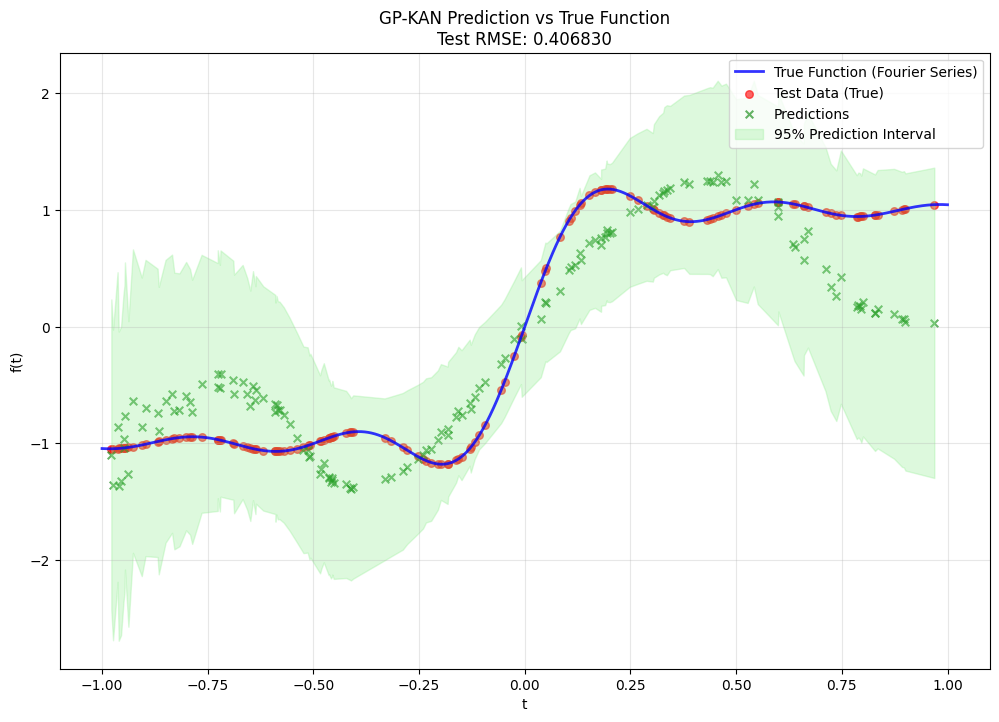

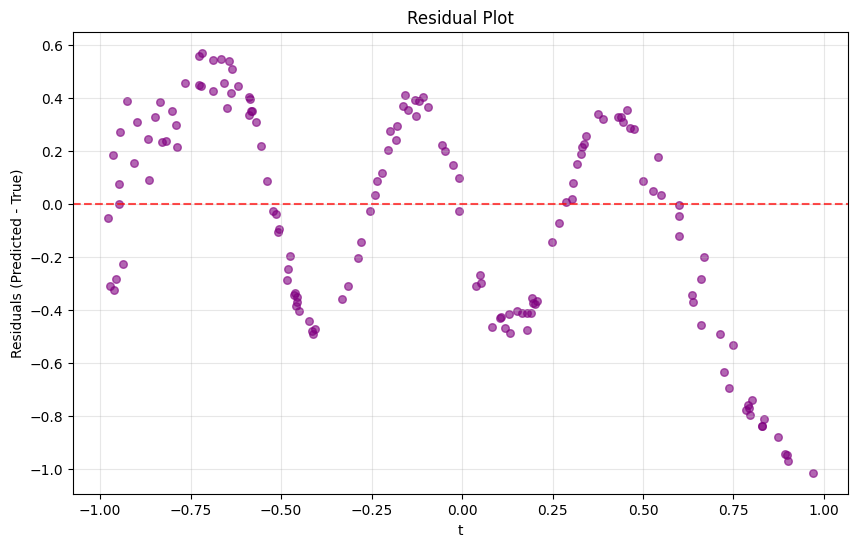


Residual Statistics:
Mean: -0.053058
Std: 0.403356
Min: -1.013701
Max: 0.571381
plot completed
epoch 0  , train negloglik: 0.55854,    val negloglik: 0.58866    accuracy: 0.2325 lr: [0.0001]
epoch 1  , train negloglik: 0.55645,    val negloglik: 0.55969    accuracy: 0.2261 lr: [9e-05]
epoch 2  , train negloglik: 0.56391,    val negloglik: 0.60636    accuracy: 0.2068 lr: [9e-05]
epoch 3  , train negloglik: 0.57252,    val negloglik: 0.70890    accuracy: 0.2827 lr: [9e-05]
epoch 4  , train negloglik: 0.59003,    val negloglik: 0.57707    accuracy: 0.2312 lr: [9e-05]
epoch 5  , train negloglik: 0.57122,    val negloglik: 0.56367    accuracy: 0.2213 lr: [9e-05]
epoch 6  , train negloglik: 0.58651,    val negloglik: 0.59247    accuracy: 0.2115 lr: [9e-05]
epoch 7  , train negloglik: 0.61032,    val negloglik: 0.56392    accuracy: 0.2218 lr: [9e-05]
epoch 8  , train negloglik: 0.56302,    val negloglik: 0.57592    accuracy: 0.2427 lr: [9e-05]
epoch 9  , train negloglik: 0.57104,    val negl

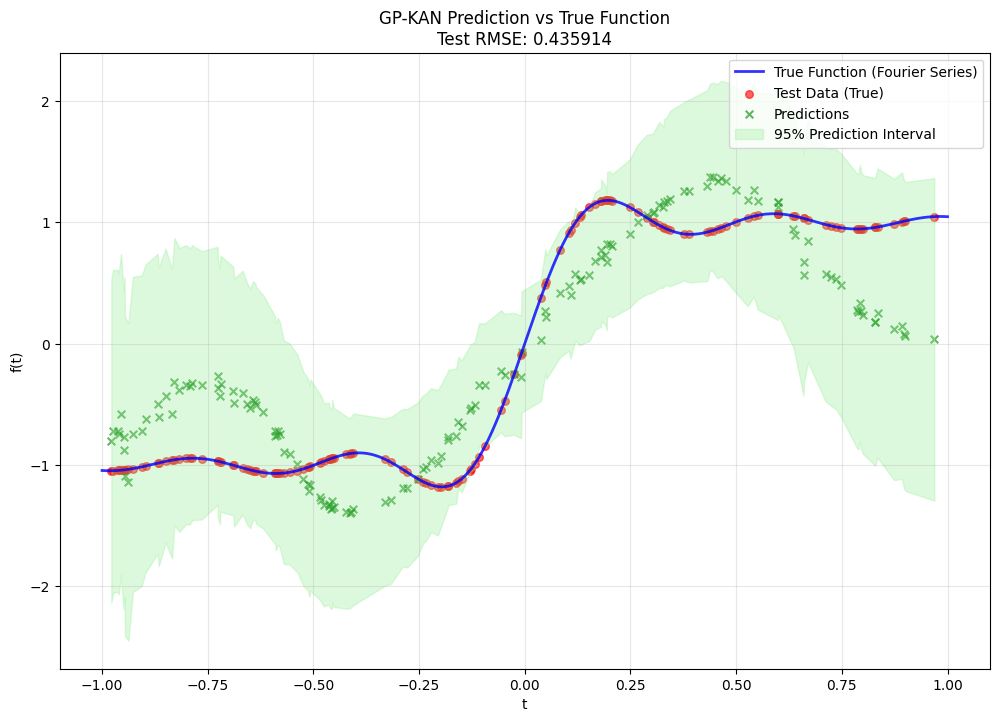

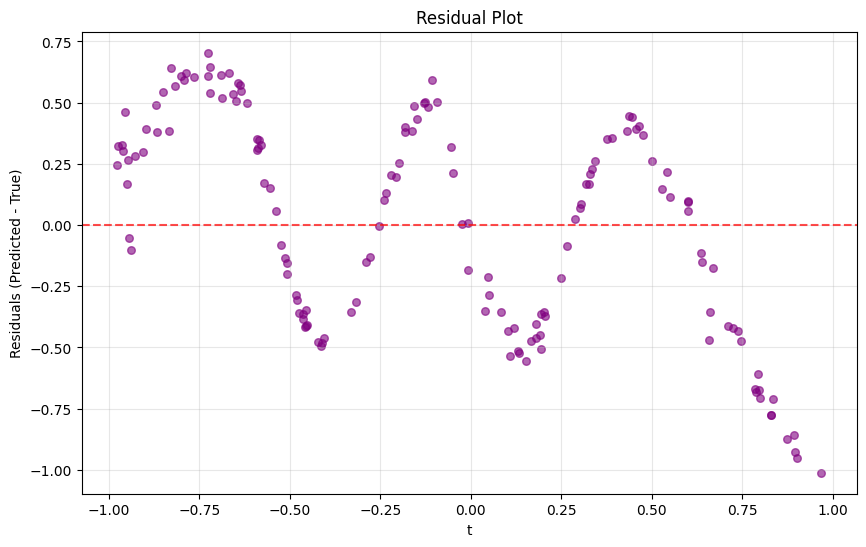


Residual Statistics:
Mean: 0.008355
Std: 0.435834
Min: -1.012020
Max: 0.703820
plot completed
epoch 0  , train negloglik: 0.55943,    val negloglik: 0.61534    accuracy: 0.2478 lr: [0.0001]
epoch 1  , train negloglik: 0.56952,    val negloglik: 0.55593    accuracy: 0.2310 lr: [9e-05]
epoch 2  , train negloglik: 0.56347,    val negloglik: 0.59332    accuracy: 0.2267 lr: [9e-05]
epoch 3  , train negloglik: 0.56289,    val negloglik: 0.55926    accuracy: 0.2039 lr: [9e-05]
epoch 4  , train negloglik: 0.56563,    val negloglik: 0.55527    accuracy: 0.2033 lr: [9e-05]
epoch 5  , train negloglik: 0.54583,    val negloglik: 0.58430    accuracy: 0.2032 lr: [9e-05]
epoch 6  , train negloglik: 0.54895,    val negloglik: 0.54524    accuracy: 0.2082 lr: [9e-05]
epoch 7  , train negloglik: 0.55165,    val negloglik: 0.55771    accuracy: 0.2358 lr: [9e-05]
epoch 8  , train negloglik: 0.54838,    val negloglik: 0.57238    accuracy: 0.2380 lr: [9e-05]
epoch 9  , train negloglik: 0.56188,    val neglo

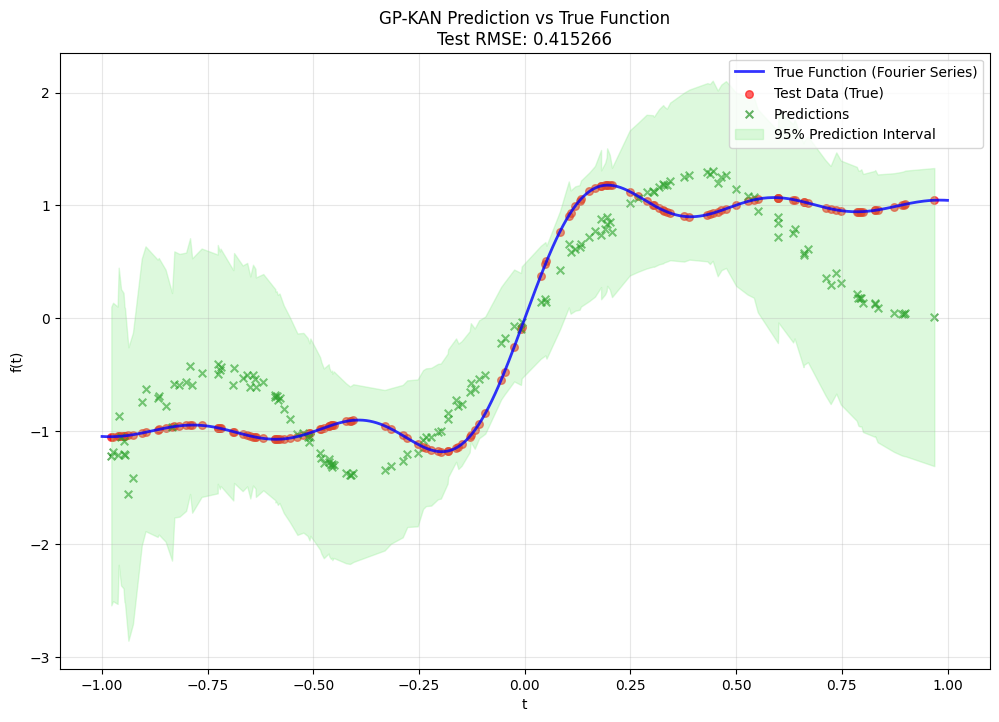

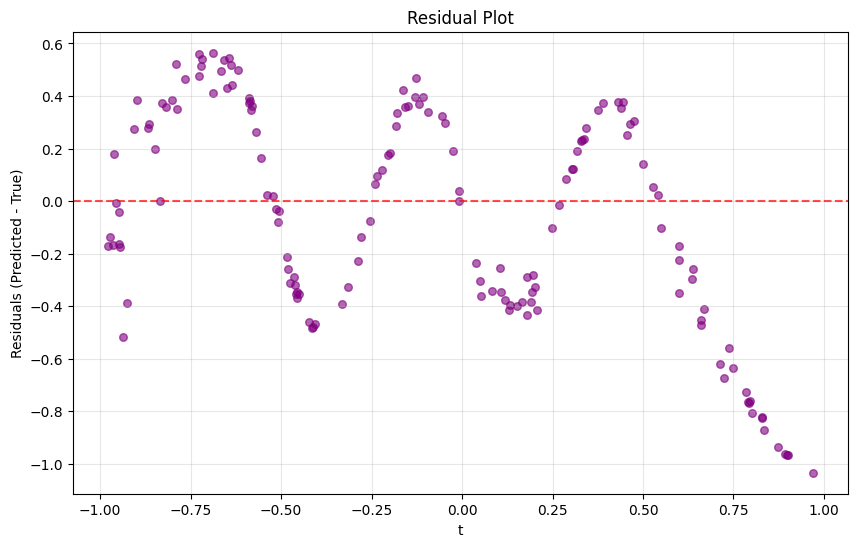


Residual Statistics:
Mean: -0.054194
Std: 0.411715
Min: -1.034655
Max: 0.564829
plot completed
epoch 0  , train negloglik: 0.55711,    val negloglik: 0.57154    accuracy: 0.2040 lr: [0.0001]
epoch 1  , train negloglik: 0.56778,    val negloglik: 0.57963    accuracy: 0.2038 lr: [9e-05]
epoch 2  , train negloglik: 0.56053,    val negloglik: 0.59770    accuracy: 0.2424 lr: [9e-05]
epoch 3  , train negloglik: 0.58061,    val negloglik: 0.56544    accuracy: 0.2392 lr: [9e-05]
epoch 4  , train negloglik: 0.56221,    val negloglik: 0.63823    accuracy: 0.2585 lr: [9e-05]
epoch 5  , train negloglik: 0.56456,    val negloglik: 0.56563    accuracy: 0.2344 lr: [9e-05]
epoch 6  , train negloglik: 0.54076,    val negloglik: 0.57647    accuracy: 0.2399 lr: [9e-05]
epoch 7  , train negloglik: 0.55028,    val negloglik: 0.63084    accuracy: 0.2593 lr: [9e-05]
epoch 8  , train negloglik: 0.55152,    val negloglik: 0.57224    accuracy: 0.2254 lr: [9e-05]
epoch 9  , train negloglik: 0.56544,    val negl

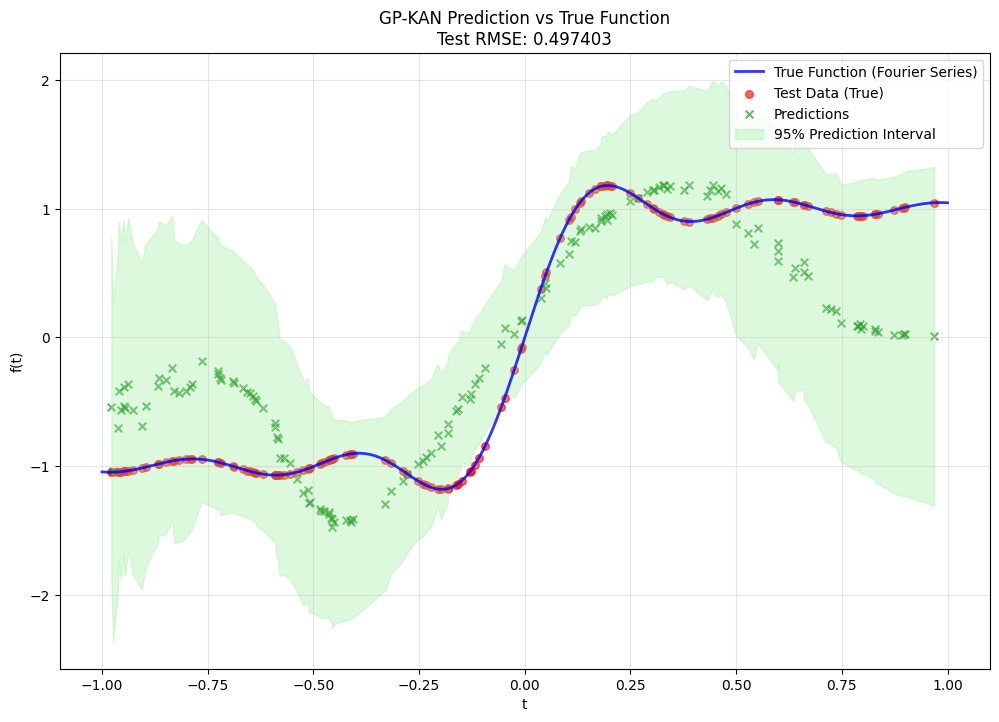

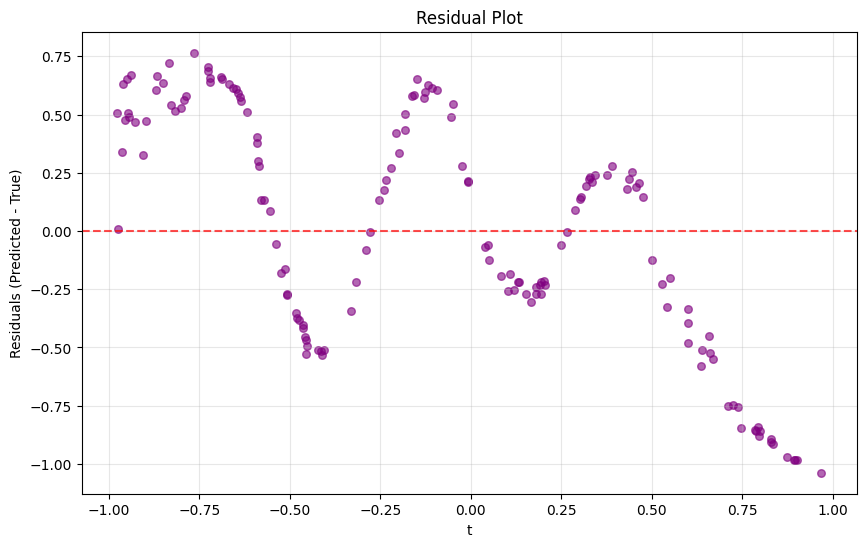


Residual Statistics:
Mean: 0.016626
Std: 0.497125
Min: -1.037891
Max: 0.765262
plot completed
epoch 0  , train negloglik: 0.55439,    val negloglik: 0.59036    accuracy: 0.2758 lr: [0.0001]
epoch 1  , train negloglik: 0.55590,    val negloglik: 0.57874    accuracy: 0.2363 lr: [9e-05]
epoch 2  , train negloglik: 0.54448,    val negloglik: 0.61208    accuracy: 0.2039 lr: [9e-05]
epoch 3  , train negloglik: 0.56001,    val negloglik: 0.61417    accuracy: 0.2492 lr: [9e-05]
epoch 4  , train negloglik: 0.54163,    val negloglik: 0.58380    accuracy: 0.2194 lr: [9e-05]
epoch 5  , train negloglik: 0.53704,    val negloglik: 0.69469    accuracy: 0.2092 lr: [9e-05]
epoch 6  , train negloglik: 0.58630,    val negloglik: 0.57207    accuracy: 0.2208 lr: [9e-05]
epoch 7  , train negloglik: 0.54873,    val negloglik: 0.56800    accuracy: 0.1940 lr: [9e-05]
epoch 8  , train negloglik: 0.55139,    val negloglik: 0.59206    accuracy: 0.2415 lr: [9e-05]
epoch 9  , train negloglik: 0.53125,    val neglo

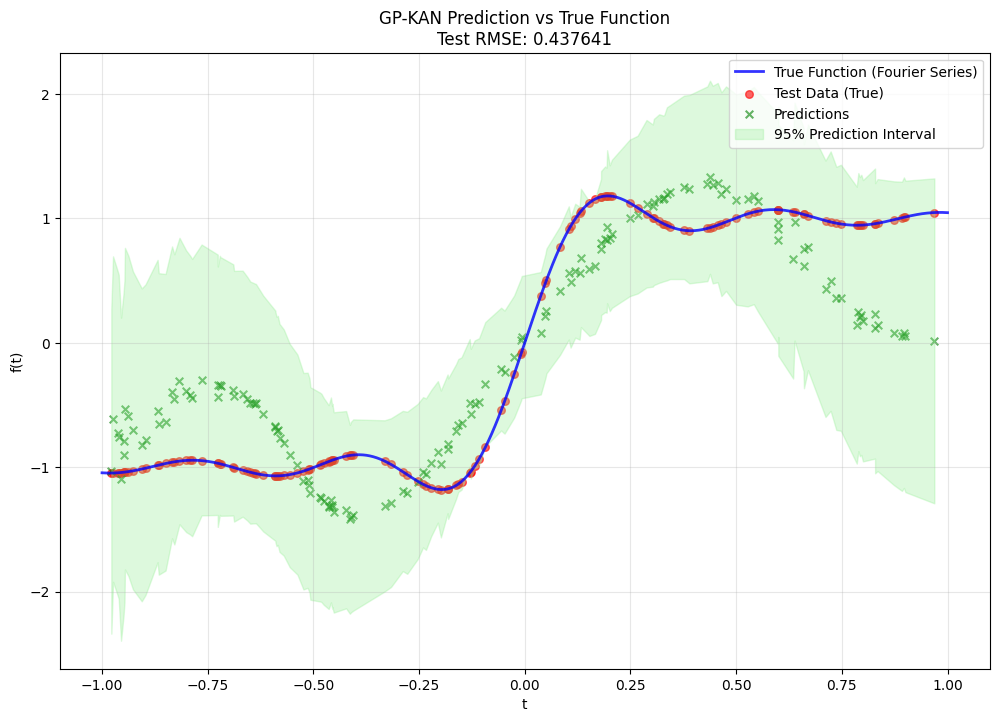

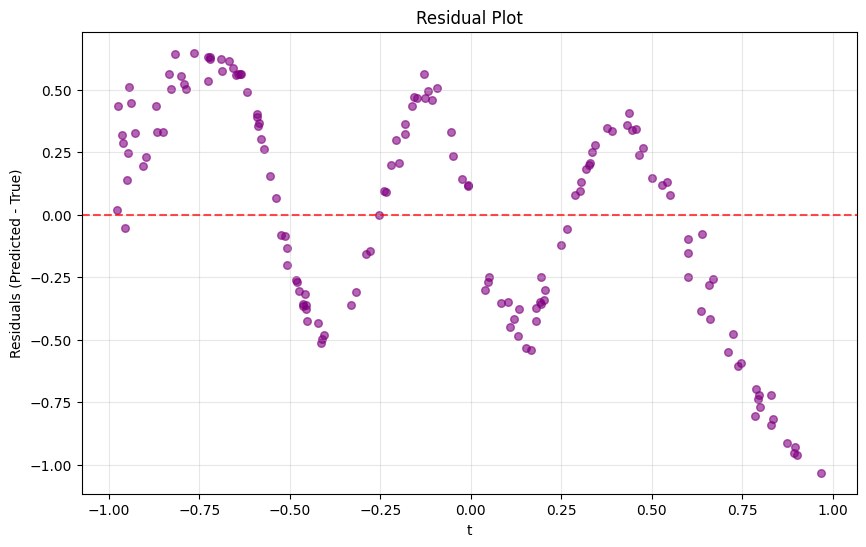


Residual Statistics:
Mean: 0.003933
Std: 0.437624
Min: -1.031345
Max: 0.648117
plot completed
epoch 0  , train negloglik: 0.55861,    val negloglik: 0.65366    accuracy: 0.2668 lr: [0.0001]
epoch 1  , train negloglik: 0.56264,    val negloglik: 0.56212    accuracy: 0.2202 lr: [9e-05]
epoch 2  , train negloglik: 0.53115,    val negloglik: 0.57562    accuracy: 0.2310 lr: [9e-05]
epoch 3  , train negloglik: 0.54171,    val negloglik: 0.59983    accuracy: 0.2228 lr: [9e-05]
epoch 4  , train negloglik: 0.56022,    val negloglik: 0.54417    accuracy: 0.2176 lr: [9e-05]
epoch 5  , train negloglik: 0.57967,    val negloglik: 0.56381    accuracy: 0.2259 lr: [9e-05]
epoch 6  , train negloglik: 0.54416,    val negloglik: 0.65311    accuracy: 0.2661 lr: [9e-05]
epoch 7  , train negloglik: 0.54317,    val negloglik: 0.60407    accuracy: 0.2731 lr: [9e-05]
epoch 8  , train negloglik: 0.53162,    val negloglik: 0.54112    accuracy: 0.2233 lr: [9e-05]
epoch 9  , train negloglik: 0.54180,    val neglo

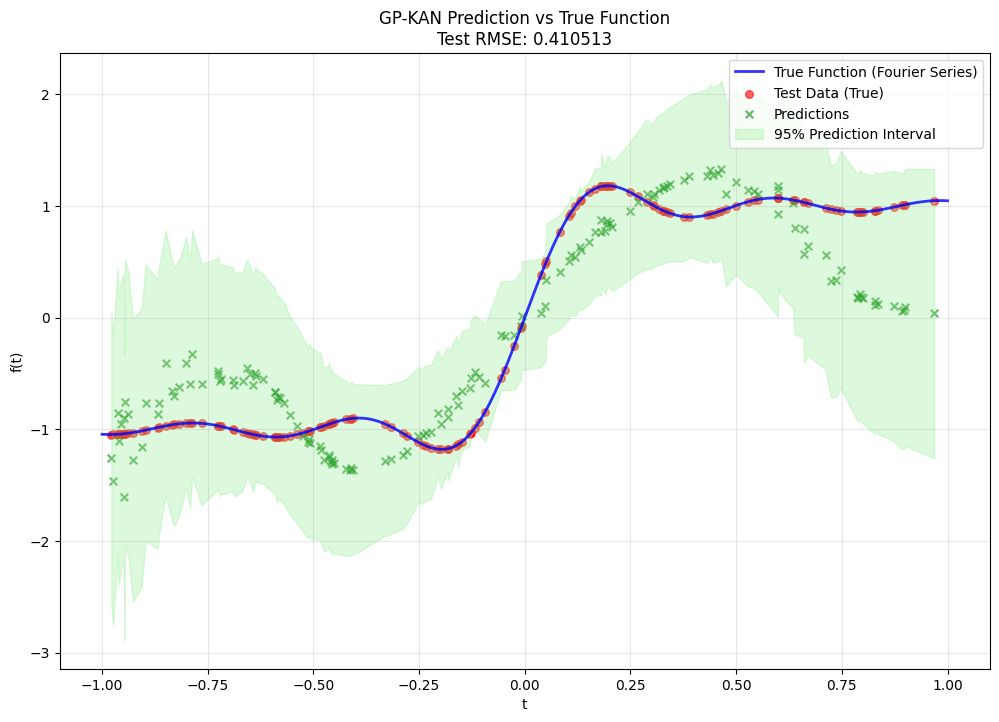

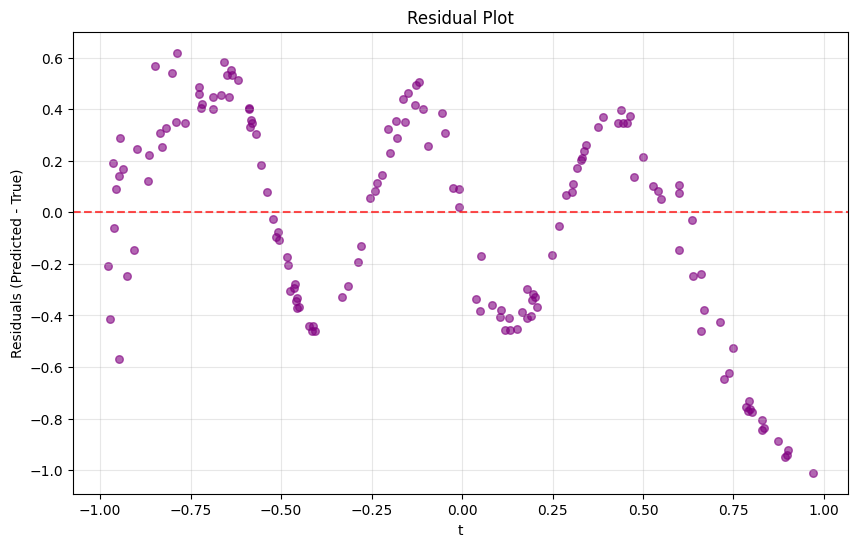


Residual Statistics:
Mean: -0.034139
Std: 0.409091
Min: -1.010256
Max: 0.619064
plot completed
epoch 0  , train negloglik: 0.54608,    val negloglik: 0.53505    accuracy: 0.2132 lr: [0.0001]
epoch 1  , train negloglik: 0.53217,    val negloglik: 0.51357    accuracy: 0.1925 lr: [9e-05]
epoch 2  , train negloglik: 0.53433,    val negloglik: 0.56218    accuracy: 0.2056 lr: [9e-05]
epoch 3  , train negloglik: 0.55204,    val negloglik: 0.56805    accuracy: 0.2155 lr: [9e-05]
epoch 4  , train negloglik: 0.57737,    val negloglik: 0.53196    accuracy: 0.1865 lr: [9e-05]
epoch 5  , train negloglik: 0.53091,    val negloglik: 0.51020    accuracy: 0.1913 lr: [9e-05]
epoch 6  , train negloglik: 0.53866,    val negloglik: 0.53175    accuracy: 0.2124 lr: [9e-05]
epoch 7  , train negloglik: 0.52735,    val negloglik: 0.56684    accuracy: 0.1990 lr: [9e-05]
epoch 8  , train negloglik: 0.56058,    val negloglik: 0.54163    accuracy: 0.1830 lr: [9e-05]
epoch 9  , train negloglik: 0.54842,    val negl

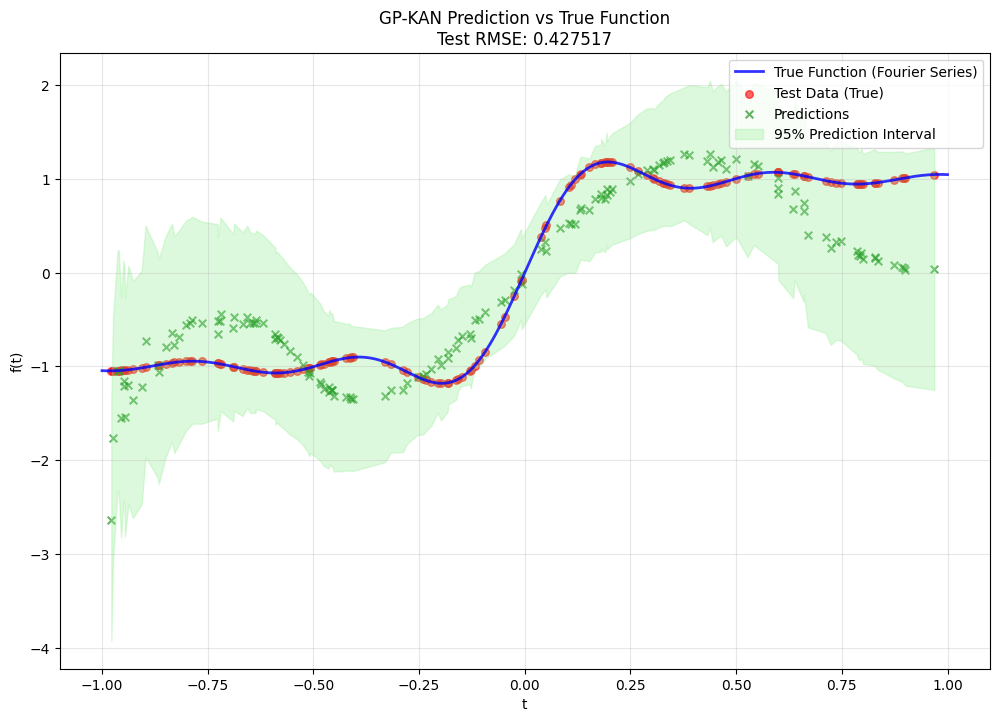

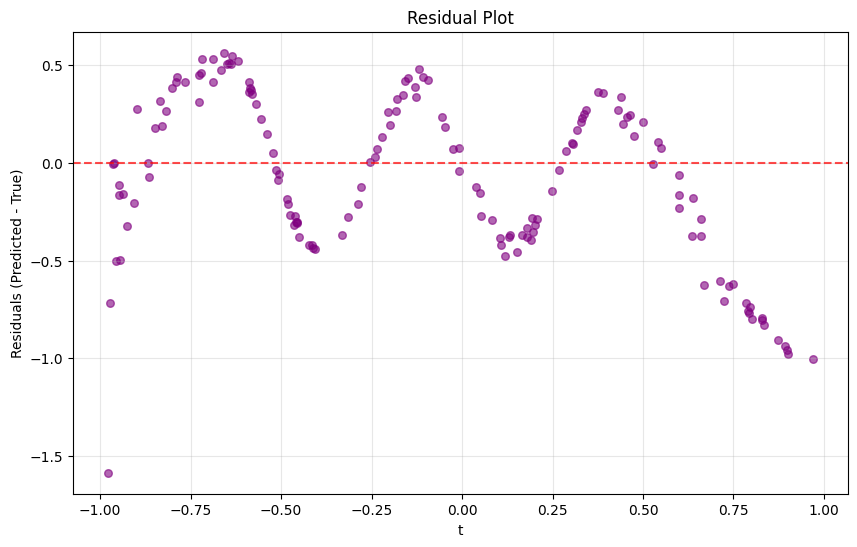


Residual Statistics:
Mean: -0.073479
Std: 0.421155
Min: -1.586440
Max: 0.564045
plot completed


In [ ]:
# 10エポックずつ学習を行い、カーネル行列のランクを可視化する
rank_list_layer0 = []
condition_number_list_layer0 = []
eigenvals_list_layer0 = []

rank_list_layer1 = []
condition_number_list_layer1 = []
eigenvals_list_layer1 = []

for epoch in range(20):
    runner.train_model(
        train_dataloader,
        val_dataloader,
        model,
        epochs=20,
        learning_rate=1e-4,
        use_gpu=False,  # True,
        pretrain=False,  # True,
        global_jitter=1e-3,
        baseline_jitter=1e-3,
    )
    model.save_model()  # optionally save the model after training

    # カーネル行列のランクを計算 (Layer 0)
    rank_0, condition_number_0, eigenvals_0 = compute_kernel_rank(model, depth=0)
    rank_list_layer0.append(rank_0)
    condition_number_list_layer0.append(condition_number_0)
    eigenvals_list_layer0.append(eigenvals_0)

    # カーネル行列のランクを計算 (Layer 1)
    rank_1, condition_number_1, eigenvals_1 = compute_kernel_rank(model, depth=1)
    rank_list_layer1.append(rank_1)
    condition_number_list_layer1.append(condition_number_1)
    eigenvals_list_layer1.append(eigenvals_1)

    # 可視化
    plot_result(model)

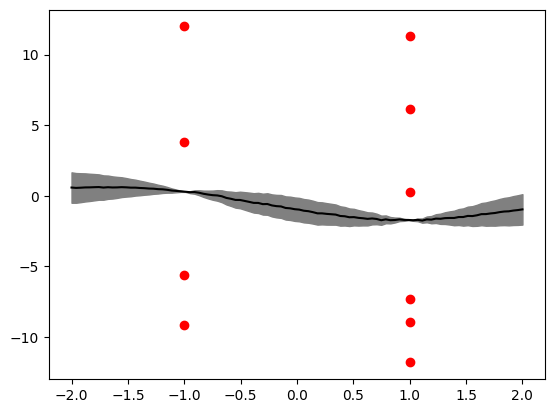

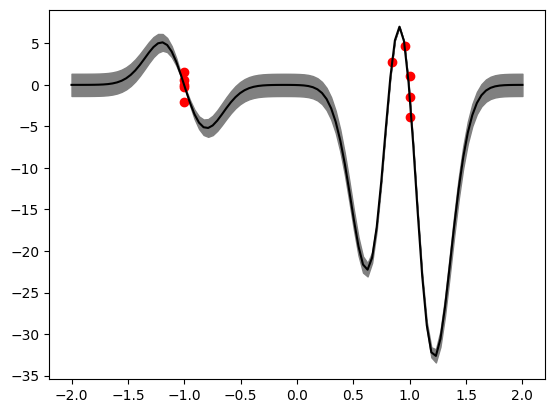

In [ ]:
# 1層目
model.layers[0].save_fig("./outputs/layer_fused0.png")
model.layers[1].save_fig("./outputs/layer_fused1.png")

### 2-3.精度評価

In [ ]:
# 学習における対数周辺尤度の最適化について
print("=== 誘導点最適化の仕組み ===")
print("1. 対数周辺尤度を目的関数として使用")
print("   log p(y|X,θ) = -0.5*y^T*K^(-1)*y - 0.5*log|K| - (n/2)*log(2π)")
print("2. 誘導点の位置 z が K に影響")
print("3. 勾配降下法により z を最適化")
print()

# 学習前後の誘導点位置を比較
print("=== 誘導点位置の変化 ===")
layer0 = model.layers[0]
layer1 = model.layers[1]

print("Layer 0 - 誘導点位置 (tanh変換後):")
z0 = layer0.get_z()  # tanh変換済み
print(f"  GP(0,0): {z0[0,0,:].detach().numpy()}")

print("\nLayer 1 - 誘導点位置 (tanh変換後):")
z1 = layer1.get_z()  # tanh変換済み
print(f"  GP(0,0): {z1[0,0,:].detach().numpy()}")

# 誘導点の初期値と比較するため、理論的初期値を計算
print("\n=== 理論的初期値との比較 ===")
initial_z = torch.linspace(-2, 2, 20)  # 初期化時の値
initial_z_tanh = torch.tanh(initial_z)  # tanh変換後
print(f"理論的初期値 (tanh変換後): {initial_z_tanh.numpy()}")

print("\n学習により誘導点が初期の等間隔配置から、")
print("データ分布により適した位置に移動していることが確認できます。")

=== 誘導点最適化の仕組み ===
1. 対数周辺尤度を目的関数として使用
   log p(y|X,θ) = -0.5*y^T*K^(-1)*y - 0.5*log|K| - (n/2)*log(2π)
2. 誘導点の位置 z が K に影響
3. 勾配降下法により z を最適化

=== 誘導点位置の変化 ===
Layer 0 - 誘導点位置 (tanh変換後):
  GP(0,0): [-0.99999774  1.          1.         -1.         -1.          1.
  1.          1.         -1.          1.        ]

Layer 1 - 誘導点位置 (tanh変換後):
  GP(0,0): [-0.99921584  0.84239143  1.         -1.          1.         -1.
 -1.         -1.          0.95603156  0.99998623]

=== 理論的初期値との比較 ===
理論的初期値 (tanh変換後): [-0.9640276  -0.945705   -0.91843736 -0.87833184 -0.8203526  -0.73858935
 -0.62723345 -0.48255983 -0.3056948  -0.10487608  0.10487608  0.3056948
  0.48255983  0.62723345  0.73858935  0.8203526   0.87833184  0.91843736
  0.945705    0.9640276 ]

学習により誘導点が初期の等間隔配置から、
データ分布により適した位置に移動していることが確認できます。


### 2-4.カーネル逆行列のランク推移

=== カーネル行列のランク推移 ===


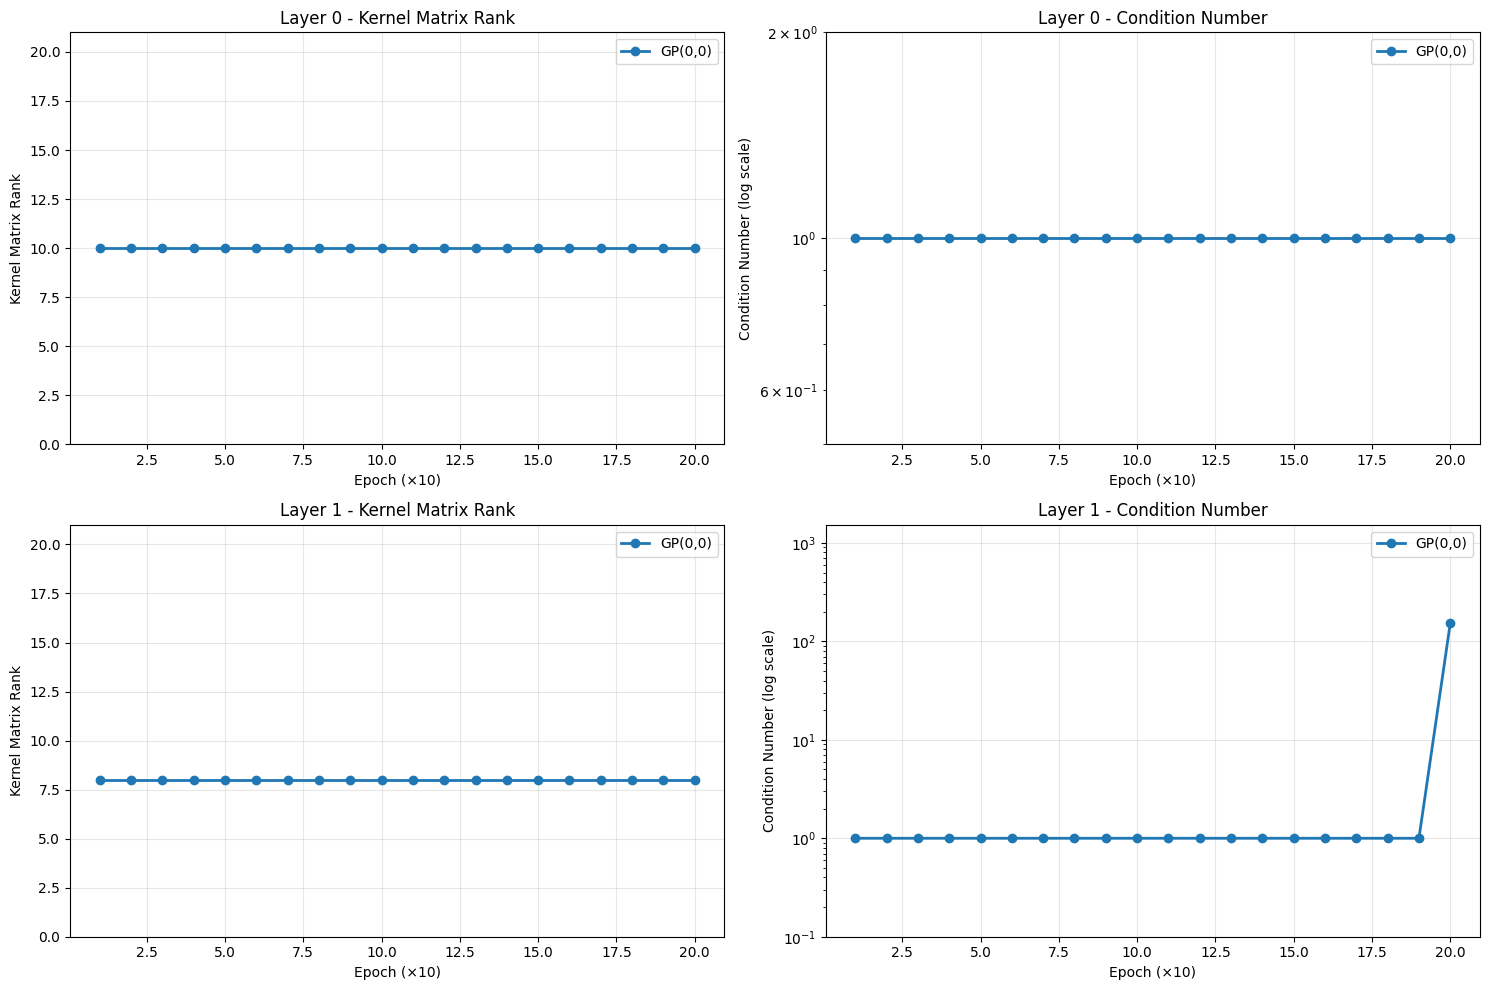


=== 最終エポックでの固有値分布 ===


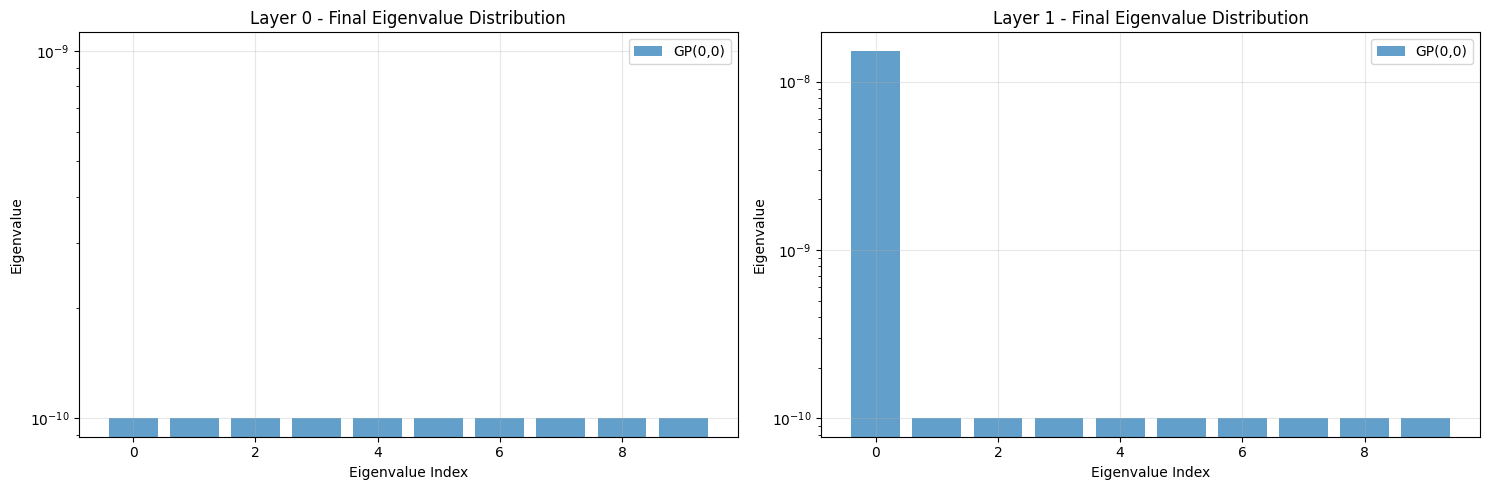


=== 分析結果 ===
1. ランクの変化：学習に伴いカーネル行列の数値的ランクが変化
2. 条件数の変化：誘導点の最適化により条件数が改善/悪化
3. 固有値分布：最適化後の固有値の分布特性
4. これらの変化は対数周辺尤度の最大化により駆動される


In [ ]:
# カーネル行列のランク推移を可視化
import matplotlib.pyplot as plt
import numpy as np

epochs = list(range(1, 21))  # 1-20 epochs

print("=== カーネル行列のランク推移 ===")

# Layer 0のランク推移
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Layer 0 - ランク推移
rank_layer0_gp0 = [ranks[0] for ranks in rank_list_layer0]

axes[0, 0].plot(
    epochs, rank_layer0_gp0, "o-", label="GP(0,0)", linewidth=2, markersize=6
)
axes[0, 0].set_xlabel("Epoch (×10)")
axes[0, 0].set_ylabel("Kernel Matrix Rank")
axes[0, 0].set_title("Layer 0 - Kernel Matrix Rank")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim(0, 21)

# Layer 0 - 条件数推移
cond_layer0_gp0 = [conds[0] for conds in condition_number_list_layer0]

# 条件数の範囲を取得して適切なy軸範囲を設定
min_cond_layer0 = min(cond_layer0_gp0)
max_cond_layer0 = max(cond_layer0_gp0)

axes[0, 1].semilogy(
    epochs, cond_layer0_gp0, "o-", label="GP(0,0)", linewidth=2, markersize=6
)

axes[0, 1].set_xlabel("Epoch (×10)")
axes[0, 1].set_ylabel("Condition Number (log scale)")
axes[0, 1].set_title("Layer 0 - Condition Number")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(min_cond_layer0 * 0.5, max_cond_layer0 * 2)

# Layer 1 - ランク推移
rank_layer1_gp0 = [ranks[0] for ranks in rank_list_layer1]

axes[1, 0].plot(
    epochs, rank_layer1_gp0, "o-", label="GP(0,0)", linewidth=2, markersize=6
)

axes[1, 0].set_xlabel("Epoch (×10)")
axes[1, 0].set_ylabel("Kernel Matrix Rank")
axes[1, 0].set_title("Layer 1 - Kernel Matrix Rank")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim(0, 21)

# Layer 1 - 条件数推移
cond_layer1_gp0 = [conds[0] for conds in condition_number_list_layer1]

# 条件数の範囲を取得して適切なy軸範囲を設定
min_cond_layer1 = min(cond_layer1_gp0)
max_cond_layer1 = max(cond_layer1_gp0)

axes[1, 1].semilogy(
    epochs, cond_layer1_gp0, "o-", label="GP(0,0)", linewidth=2, markersize=6
)

axes[1, 1].set_xlabel("Epoch (×10)")
axes[1, 1].set_ylabel("Condition Number (log scale)")
axes[1, 1].set_title("Layer 1 - Condition Number")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(min_cond_layer1 * 0.1, max_cond_layer1 * 10)

plt.tight_layout()
plt.show()

# 固有値分布の可視化（最終エポック）
print("\n=== 最終エポックでの固有値分布 ===")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Layer 0の固有値分布
eigenvals_layer0_final = eigenvals_list_layer0[-1]
axes[0].bar(
    range(len(eigenvals_layer0_final[0])),
    sorted(eigenvals_layer0_final[0].numpy(), reverse=True),
    alpha=0.7,
    label="GP(0,0)",
)
axes[0].set_xlabel("Eigenvalue Index")
axes[0].set_ylabel("Eigenvalue")
axes[0].set_title("Layer 0 - Final Eigenvalue Distribution")
axes[0].legend()
axes[0].set_yscale("log")
axes[0].grid(True, alpha=0.3)

# Layer 1の固有値分布
eigenvals_layer1_final = eigenvals_list_layer1[-1]
axes[1].bar(
    range(len(eigenvals_layer1_final[0])),
    sorted(eigenvals_layer1_final[0].numpy(), reverse=True),
    alpha=0.7,
    label="GP(0,0)",
)
axes[1].set_xlabel("Eigenvalue Index")
axes[1].set_ylabel("Eigenvalue")
axes[1].set_title("Layer 1 - Final Eigenvalue Distribution")
axes[1].legend()
axes[1].set_yscale("log")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== 分析結果 ===")
print("1. ランクの変化：学習に伴いカーネル行列の数値的ランクが変化")
print("2. 条件数の変化：誘導点の最適化により条件数が改善/悪化")
print("3. 固有値分布：最適化後の固有値の分布特性")
print("4. これらの変化は対数周辺尤度の最大化により駆動される")